# Setup

## Imports

In [22]:
import pandas as pd
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
import time
import importlib
import seaborn as sns
import gc  # garbage collector
import os
import json
import networkx as nx
from sys import getsizeof
from sklearn import metrics
from sklearn.cluster import DBSCAN
from scipy.spatial import distance
from sklearn.metrics import jaccard_score
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from collections import Counter
from matplotlib.lines import Line2D

from typing import List, Dict

import src.utils.utils as dp  # own functions and logic
importlib.reload(dp)  # this makes it so that 
                      # the file with our functions is re-read every time, 
                      # in case we have made modifications

<module 'src.utils.utils' from '/Users/liaras/ADA2024/ada-2024-project-thedataminions/src/utils/utils.py'>

## Paths configuration

In [13]:
#define the path where the YouNiverse dataset is stored

#dataset_root_path = "/media/andreas/Backup Plus/Ada/youniverse_dataset/"   #andreas
#dataset_root_path = "/media/andreas/Backup_Louanne/Youniverse_dataset/"    #Lou-Anne at andreas pc
#dataset_root_path = "D:/ada_project/dataset/"                               #mila
# dataset_root_path = "/Volumes/DISQUE_SAUVEGARDE_MANON_LANDRIEUX/dataset/" #manon
#dataset_root_path = '/Volumes/Expansion/ada_project/dataset/'              #manon at mimi disk
# dataset_root_path = "/Volumes/Backup/Youniverse_dataset/"                 #Lou-Anne 
dataset_root_path = "/Volumes/Disk Horti/Youniverse_dataset/"              #Horti
#dataset_root_path = "/Volumes/Expansion/ada_project/dataset/"              #Lams with mila's disk

In [32]:
#load needed files (already generated in preprocessing.ipynb, only loading the file)

comments_news_pol_selected_channels_filepaths = [
    dataset_root_path + "../generated_data/comments_news_pol_" + channel + ".csv" 
    for channel in ["cnn", "abc","bbc", "aje", "fox"]  
    ]

df_comments_news_pol_cnn = pd.read_csv(comments_news_pol_selected_channels_filepaths[0])
df_comments_news_pol_abc = pd.read_csv(comments_news_pol_selected_channels_filepaths[1])
df_comments_news_pol_bbc = pd.read_csv(comments_news_pol_selected_channels_filepaths[2])
df_comments_news_pol_aje = pd.read_csv(comments_news_pol_selected_channels_filepaths[3])
df_comments_news_pol_fox = pd.read_csv(comments_news_pol_selected_channels_filepaths[4])

df_channels_news_pol = pd.read_csv(dataset_root_path + "../generated_data/channels_in_news_pol.csv")

channel_id_cnn = "UCupvZG-5ko_eiXAupbDfxWw"  # CNN
channel_id_abc = "UCBi2mrWuNuyYy4gbM6fU18Q"  # ABC News
channel_id_bbc = "UC16niRr50-MSBwiO3YDb3RA"  # BBC News
channel_id_aje = "UCNye-wNBqNL5ZzHSJj3l8Bg"  # Al Jazeera English
channel_id_fox = "UCXIJgqnII2ZOINSWNOGFThA"  # Fox News


# Part 1: From creation to reaction - Understanding Youtube’s content dynamics

## How Content is Received by Viewers: The Spark that Ignites Activity

### Activity of Users in the main channels

Let's look at the activity of the users of our main channels.

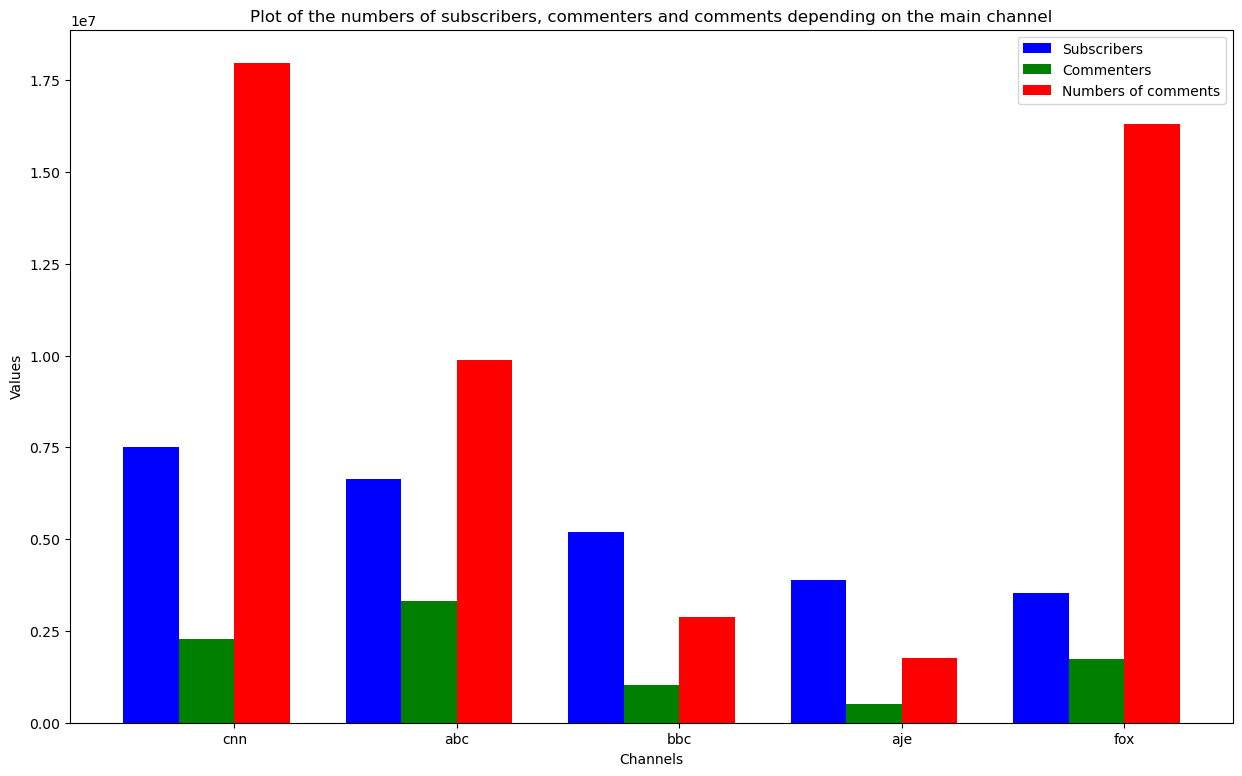

In [5]:
#channel we are interested in (5 top channels)
channels = ['cnn', 'abc', 'bbc', 
                'aje', 'fox']
#total numbers of comments
comments = [len(df_comments_news_pol_cnn), 
            len(df_comments_news_pol_abc), 
            len(df_comments_news_pol_bbc), 
            len(df_comments_news_pol_aje), 
            len(df_comments_news_pol_fox)]
#total numbers of subscribers
subscribers = [df_channels_news_pol[df_channels_news_pol.channel == channel_id_cnn].subscribers_cc.values[0], 
               df_channels_news_pol[df_channels_news_pol.channel == channel_id_abc].subscribers_cc.values[0],
               df_channels_news_pol[df_channels_news_pol.channel == channel_id_bbc].subscribers_cc.values[0], 
               df_channels_news_pol[df_channels_news_pol.channel == channel_id_aje].subscribers_cc.values[0], 
               df_channels_news_pol[df_channels_news_pol.channel == channel_id_fox].subscribers_cc.values[0]]
# Calculate the number of unique authors that commented for each dataframe
commenters = [
    df_comments_news_pol_cnn['author'].nunique(),
    df_comments_news_pol_abc['author'].nunique(),
    df_comments_news_pol_bbc['author'].nunique(),
    df_comments_news_pol_aje['author'].nunique(),
    df_comments_news_pol_fox['author'].nunique()
]

# Bar width
bar_width = 0.25
index = np.arange(len(channels))

# Fig
fig, ax = plt.subplots(figsize=(15, 9))

bar1 = ax.bar(index - bar_width, subscribers, bar_width, label='Subscribers', color='blue')
bar2 = ax.bar(index, commenters, bar_width, label='Commenters', color='green')
bar3 = ax.bar(index + bar_width, comments, bar_width, label='Numbers of comments', color='red')

# Labels and title
ax.set_xlabel('Channels')
ax.set_ylabel('Values')
ax.set_title('Plot of the numbers of subscribers, commenters and comments depending on the main channel')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(channels)

# Legend display
ax.legend()

plt.show()

For each channel the number of commenters is significantly lower than the number of subscriber. However a very high number of comments can be seen compared to number of subscribers and commenters. This likely means that the subscribers which comment are very active.
Also, one can see that AJE has the less commentes, and fox doesn't have a lot of subscribers but a massive number of comments. 
 
Let’s confirm that the subscribers are very active by looking at the distribution of authors per number of comments for each channel.


### Distribution of authors per numbers of comments

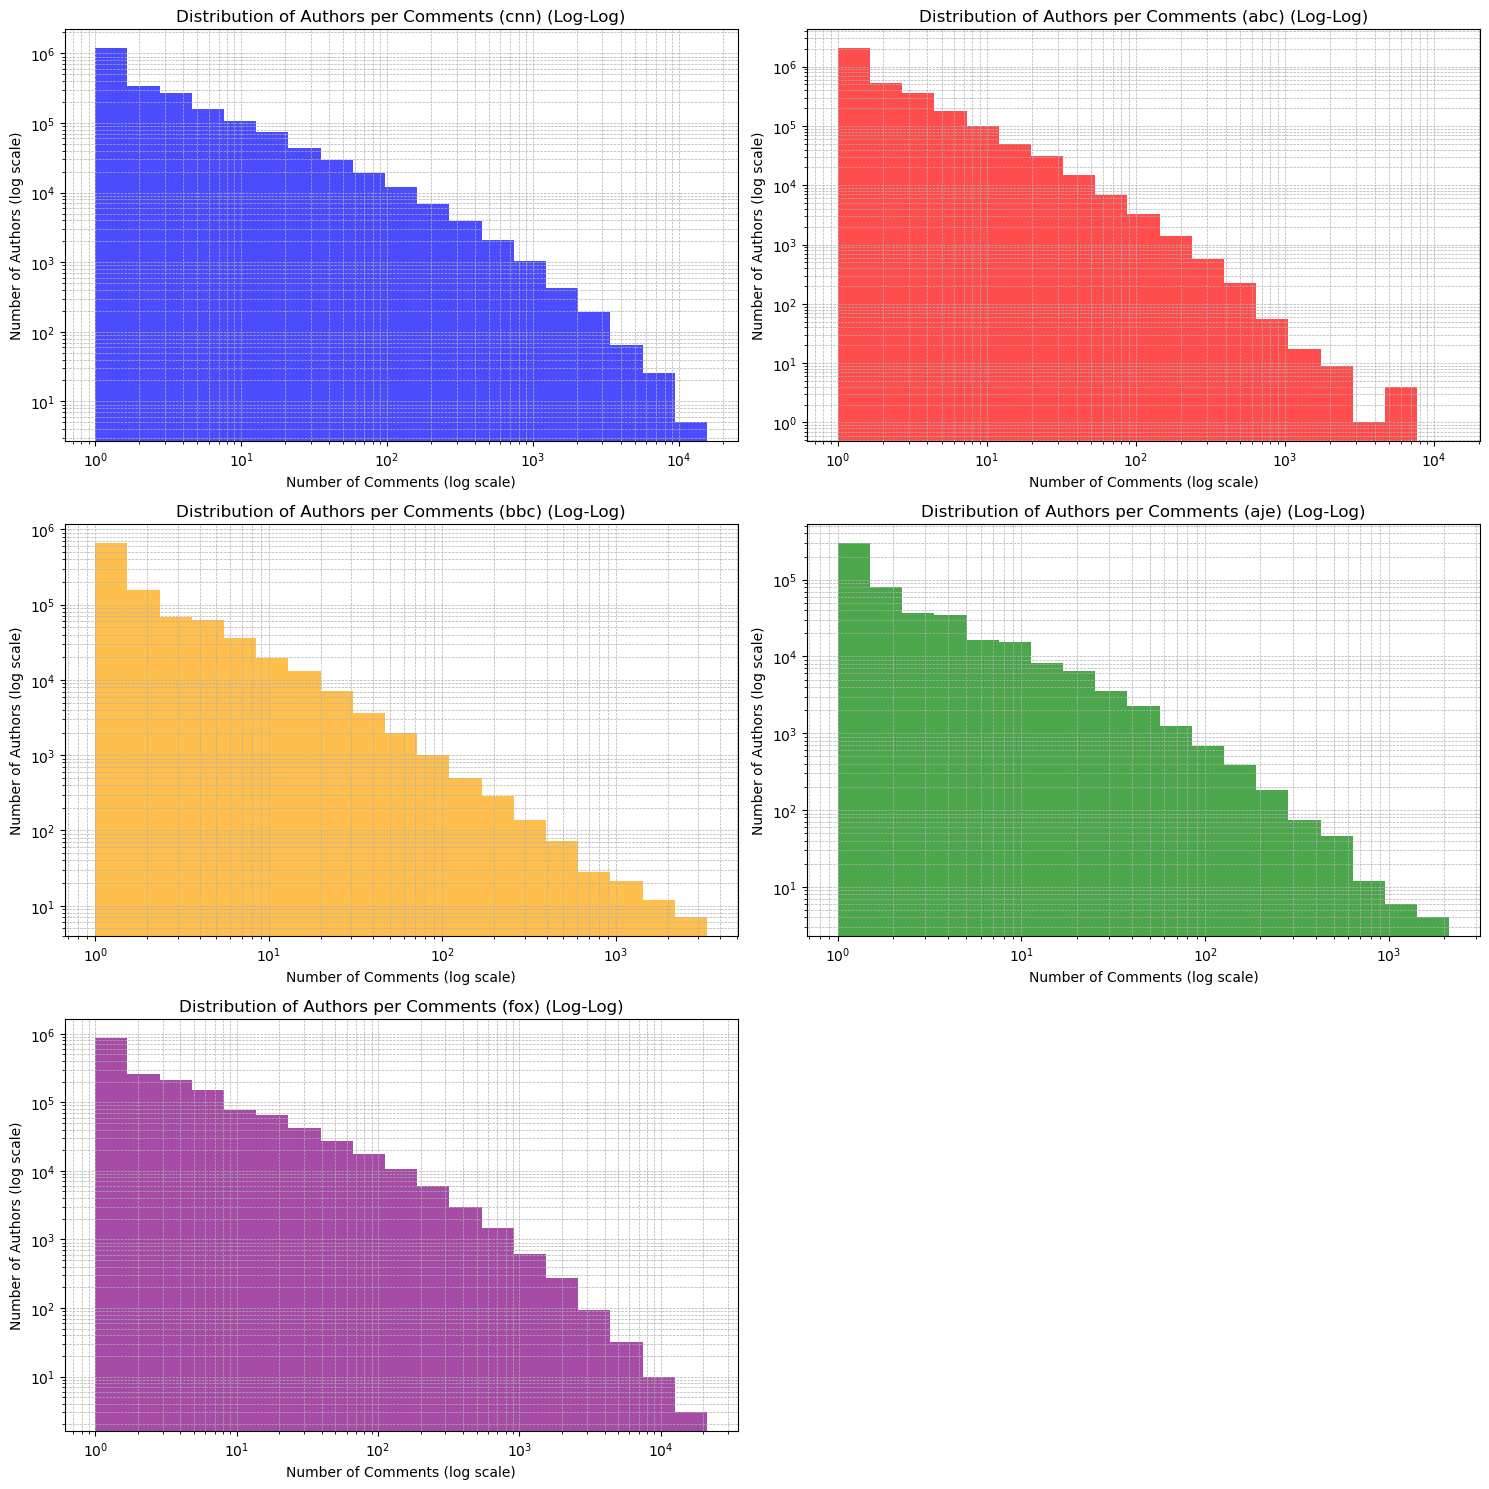

In [6]:
comment_counts_cnn = df_comments_news_pol_cnn.groupby('author').size()
comment_counts_abc = df_comments_news_pol_abc.groupby('author').size()
comment_counts_bbc = df_comments_news_pol_bbc.groupby('author').size()
comment_counts_aje = df_comments_news_pol_aje.groupby('author').size()
comment_counts_fox = df_comments_news_pol_fox.groupby('author').size()

data = [
    (comment_counts_cnn, 'cnn'),
    (comment_counts_abc, 'abc'),
    (comment_counts_bbc, 'bbc'),
    (comment_counts_aje, 'aje'),
    (comment_counts_fox, 'fox')
]
titles = ['cnn', 'abc', 'bbc', 'aje', 'fox']
colors = ['blue', 'red', 'orange', 'green', 'purple']
ylims = [15000, 12500, 40000, 500000, 10000]
dp.plot_log_histo_subplot(data, titles, colors, 2)

The distribution seems to follow a power law, because the log log plots are (more or less) close to a straight line. A power law distribution inherently implies a highly skewed distribution.
Now looking at the channels, ABC takes the crown for having the most users that barely comment, while AJE has the lowest of such commenters.  There isa presence of a long tail for each cluster.  Most users post only a small number of comments, while a small of highly active users contribute significantly more.
These highly active users are perfect candidates for forming distinct clusters based on their activity levels.
We thus decide to define the cluster as the most active users (commenters) of each channel, so we could focus only on the most active users and by the same occasion reduce the number of commenters in order to make the analysis easier and more relevant. 



# Part 2 : Uncovering the patterns of the  power players of YouTube 

### Definition of the threshold to reduce the number of users to the most active users

The first step of the definition of our cluster is to reduce our pool of users to the one we're the most interested in - the users that comment a lot. This decision was made based on the fact that in order to be isolated, a user need to be very active. In order to do this, we need to be able to have a significative amount of users, but not too large. 

Let's first compute the function that will be able to reduce our dataframe based on the thresold we will define. 

In [7]:
#returns df with users_id and total number of comments made in a specific channel

threshold = 0  # decide this based on the distributions of comments for the 5 channels

metadata_commenters_news_pol_selected_channels_filepaths = [
    dataset_root_path + "../generated_data/metadata_commenters_news_pol_" + channel + ".csv" 
    for channel in ["cnn", "abc", "bbc", 
                    "aje", "fox"]
    ]

if np.all([os.path.isfile(filepath) for filepath in metadata_commenters_news_pol_selected_channels_filepaths]):
    metadata_commenters_news_pol_cnn = pd.read_csv(metadata_commenters_news_pol_selected_channels_filepaths[0])
    metadata_commenters_news_pol_abc = pd.read_csv(metadata_commenters_news_pol_selected_channels_filepaths[1])
    metadata_commenters_news_pol_bbc = pd.read_csv(metadata_commenters_news_pol_selected_channels_filepaths[2])
    metadata_commenters_news_pol_aje = pd.read_csv(metadata_commenters_news_pol_selected_channels_filepaths[3])
    metadata_commenters_news_pol_fox = pd.read_csv(metadata_commenters_news_pol_selected_channels_filepaths[4])
    print("Read 5 dfs from file")
else:  # calculate the metadata using the threshold defined above
    # group the comments by channel
    # df_comments_news_pol_manually_selected_grouped = df_comments_news_pol_manually_selected.groupby("channel_id")
    
    # save the groups to new dfs
    (metadata_commenters_news_pol_cnn,
     metadata_commenters_news_pol_abc,
     metadata_commenters_news_pol_bbc,
     metadata_commenters_news_pol_aje,
     metadata_commenters_news_pol_fox) = (dp.get_metadata_commenters(df_comments, threshold)
                                          for df_comments in [df_comments_news_pol_cnn,
                                                              df_comments_news_pol_abc,
                                                              df_comments_news_pol_bbc,
                                                              df_comments_news_pol_aje,
                                                              df_comments_news_pol_fox])
    
    # save the new dfs to csv
    metadata_commenters_news_pol_cnn.to_csv(metadata_commenters_news_pol_selected_channels_filepaths[0], index=False)
    metadata_commenters_news_pol_abc.to_csv(metadata_commenters_news_pol_selected_channels_filepaths[1], index=False)
    metadata_commenters_news_pol_bbc.to_csv(metadata_commenters_news_pol_selected_channels_filepaths[2], index=False)
    metadata_commenters_news_pol_aje.to_csv(metadata_commenters_news_pol_selected_channels_filepaths[3], index=False)
    metadata_commenters_news_pol_fox.to_csv(metadata_commenters_news_pol_selected_channels_filepaths[4], index=False)


Read 5 dfs from file


Now that this is done, we need to evaluate our different thresold to make a choice. 


We will look at relevant statistics: mean, median, 70th, 90th, 95th, 97th abd finally 99th percentile. The defintion of the cluster was handpicked, as after some conversation the utilization of the top 1% users seemed to be the most interesting part, and the easier to compute with the high numbers of commenters

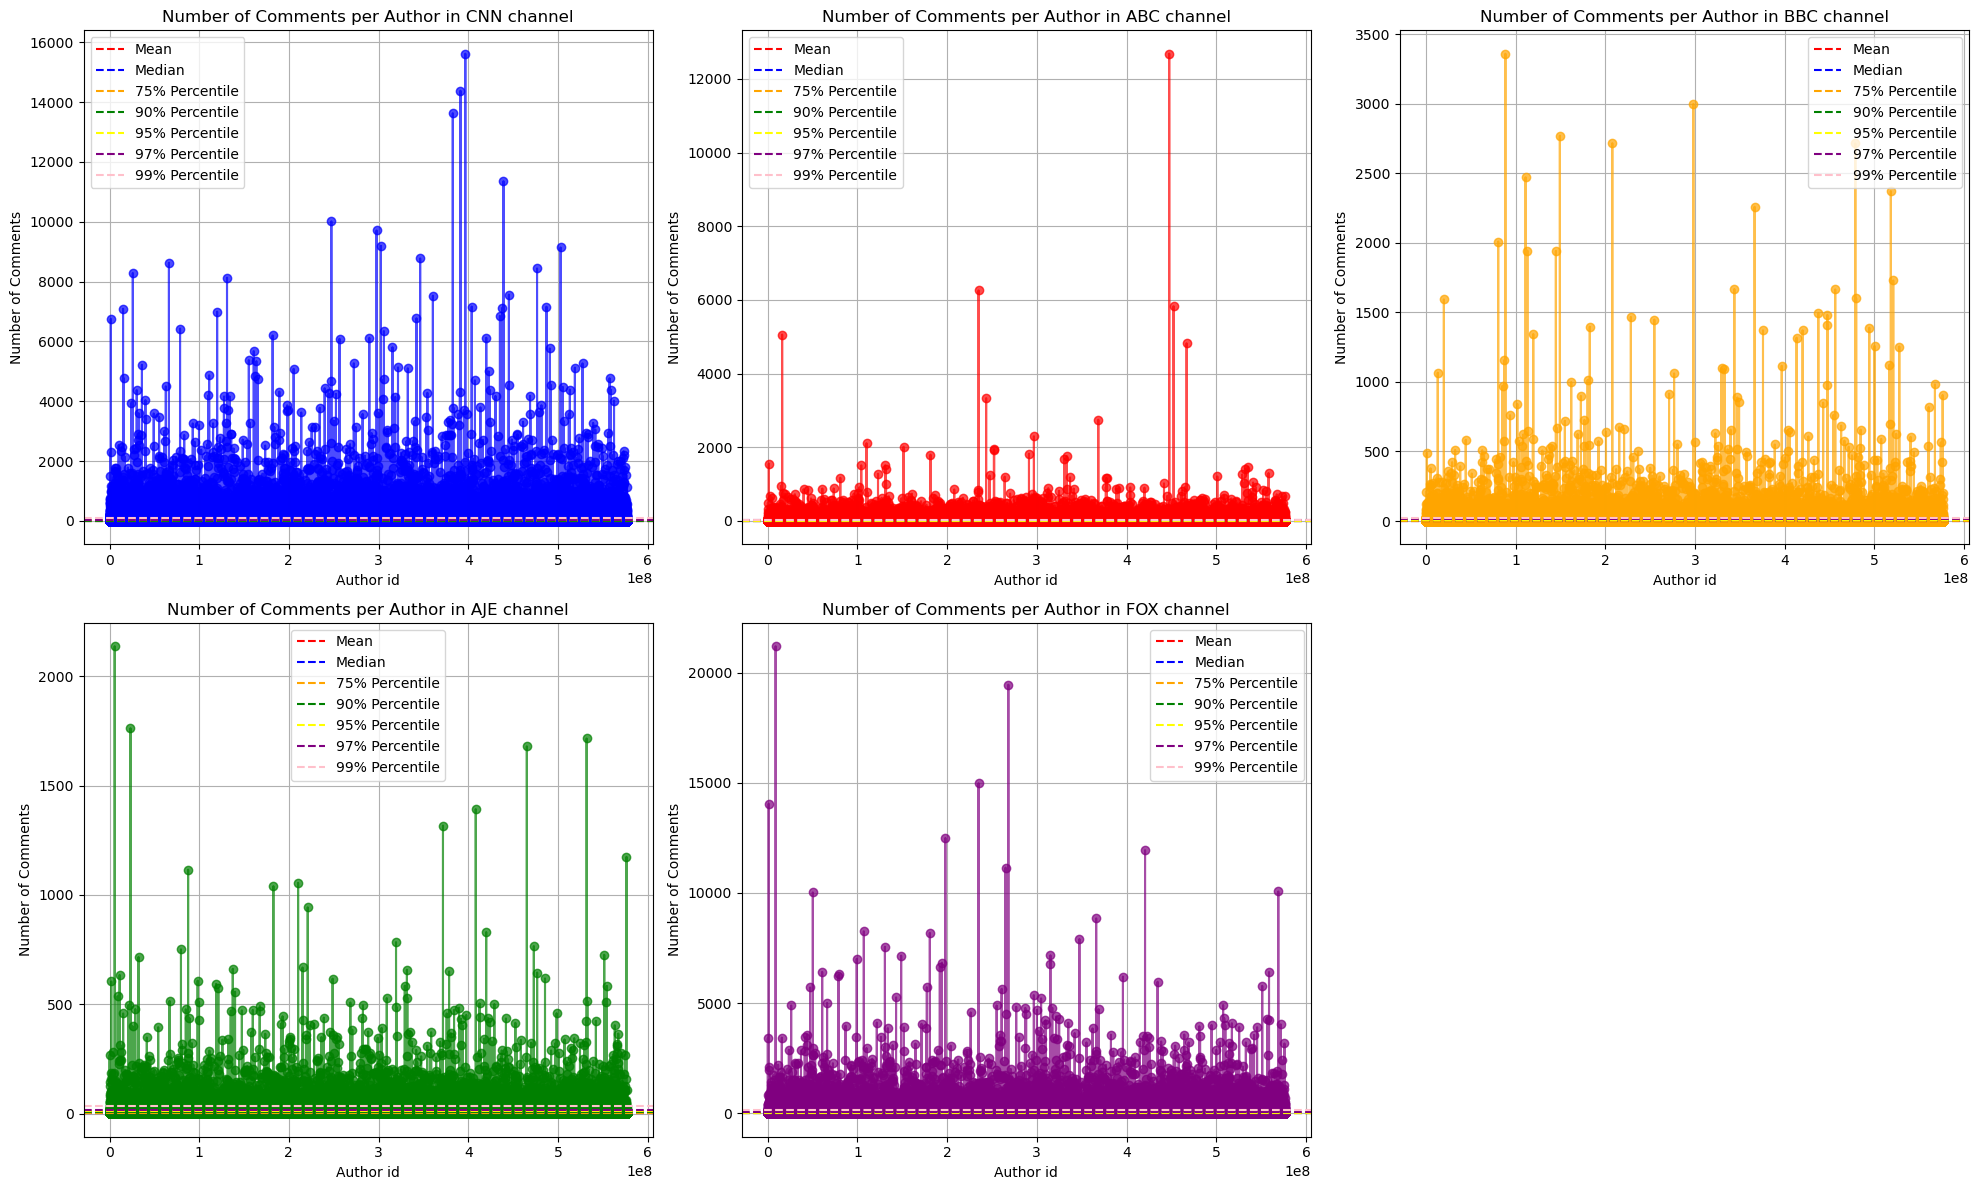

Mean   Median 75% Percentile 90% Percentile 95% Percentile  \
cnn  299899  2268335         728636         245623         114279   
abc  741751  3322207        1264223         385206         177284   
bbc  214495  1028344         370396         107853          55840   
aje   89708   506417         126660          54892          25821   
fox  230079   871759         484027         174226          89201   

    97 % Percentile 99% Percentile  
cnn           69177          22895  
abc          107551          33499  
bbc           31135          10464  
aje           16083           5250  
fox           52211          17372

In [28]:
#this cell is defining different thresold (median, mean, 95th,99th percentile), and calculating the numbers of users above this number
#the aim is to define which thresold we will take for the cluster (e.g. take 1% top users of cnn that have the most commented)


# Threshold DETERMINATION

#make figure for visualisation for each channel (thus subplot)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

# List of 5 main channels
channels = ['cnn', 'abc', 'bbc', 'aje', 'fox']
colors = ['blue', 'red', 'orange', 'green', 'purple']

# Dictionary to store metadata for each channel
metadata_dict = {}

# Different types of threshold
thresholds_df = pd.DataFrame(columns=["Mean", "Median", "75% Percentile", 
                                      "90% Percentile" ,"95% Percentile" , 
                                      "97 % Percentile", "99% Percentile"], index=channels)


for idx, channel in enumerate(channels):
    metadata_dict[channel] = {}

    # Get metadata and comment counts for each channel
    metadata_dict[channel]['metadata'] = globals()[f'metadata_commenters_news_pol_{channel}']
    metadata_dict[channel]['comment_counts'] = globals()[f'comment_counts_{channel}']

    # Calculate thresholds for each channel
    mean_channel = metadata_dict[channel]['metadata'].number_of_comments.mean()
    median_channel = metadata_dict[channel]['metadata'].number_of_comments.median()
    percentile_75 = metadata_dict[channel]['metadata'].number_of_comments.quantile(0.75)
    percentile_90 = metadata_dict[channel]['metadata'].number_of_comments.quantile(0.9)
    percentile_95 = metadata_dict[channel]['metadata'].number_of_comments.quantile(0.95)
    percentile_97 = metadata_dict[channel]['metadata'].number_of_comments.quantile(0.97)
    percentile_99 = metadata_dict[channel]['metadata'].number_of_comments.quantile(0.99)

    # Number of users above the threshold for each channel
    metadata_dict[channel]['metadata_mean'] = dp.get_metadata_commenters(globals()[f'df_comments_news_pol_{channel}'], mean_channel)
    metadata_dict[channel]['metadata_median'] = dp.get_metadata_commenters(globals()[f'df_comments_news_pol_{channel}'], median_channel)
    metadata_dict[channel]['metadata_percentile_75'] = dp.get_metadata_commenters(globals()[f'df_comments_news_pol_{channel}'], percentile_75)
    metadata_dict[channel]['metadata_percentile_90'] = dp.get_metadata_commenters(globals()[f'df_comments_news_pol_{channel}'], percentile_90)
    metadata_dict[channel]['metadata_percentile_95'] = dp.get_metadata_commenters(globals()[f'df_comments_news_pol_{channel}'], percentile_95)
    metadata_dict[channel]['metadata_percentile_97'] = dp.get_metadata_commenters(globals()[f'df_comments_news_pol_{channel}'], percentile_97)
    metadata_dict[channel]['metadata_percentile_99'] = dp.get_metadata_commenters(globals()[f'df_comments_news_pol_{channel}'], percentile_99)

    thresholds_df.loc[channel] = [
        len(metadata_dict[channel]['metadata_mean']),
        len(metadata_dict[channel]['metadata_median']),
        len(metadata_dict[channel]['metadata_percentile_75']),
        len(metadata_dict[channel]['metadata_percentile_90']),
        len(metadata_dict[channel]['metadata_percentile_95']),
        len(metadata_dict[channel]['metadata_percentile_97']),
        len(metadata_dict[channel]['metadata_percentile_99'])]
    
    # Plotting the number of comments per author for each channel
    axes[idx].plot(metadata_dict[channel]['comment_counts'].index, metadata_dict[channel]['comment_counts'], marker='o', color=colors[idx], alpha=0.7)
    axes[idx].set_title(f'Number of Comments per Author in {channel.upper()} channel')
    axes[idx].set_xlabel('Author id')
    axes[idx].set_ylabel('Number of Comments')
    axes[idx].grid(True)
    axes[idx].axhline(y=mean_channel, color='r', linestyle='--', label='Mean')
    axes[idx].axhline(y=median_channel, color='b', linestyle='--', label='Median')
    axes[idx].axhline(y=percentile_75, color='orange', linestyle='--', label='75% Percentile')
    axes[idx].axhline(y=percentile_90, color='green', linestyle='--', label='90% Percentile')
    axes[idx].axhline(y=percentile_95, color='yellow', linestyle='--', label='95% Percentile')
    axes[idx].axhline(y=percentile_97, color='purple', linestyle='--', label='97% Percentile')
    axes[idx].axhline(y=percentile_99, color='pink', linestyle='--', label='99% Percentile')
    axes[idx].legend()


plt.tight_layout()
axes[5].axis('off')
plt.show()



display(thresholds_df)


We will take the thresold: **99th percentile**, as it is already a big set of users. It is statistically relevant because it is taking the most active 1% users for each channels. 

### Generation of the clusters (1% top active users)

In [6]:
#generate the clusters for each channel, taking only the 1% top users
#cluster 

filepath_cnn_cluster= dataset_root_path + "../generated_data/cluster_cnn.csv"
filepath_abc_cluster= dataset_root_path + "../generated_data/cluster_abc.csv"
filepath_bbc_cluster= dataset_root_path + "../generated_data/cluster_bbc.csv"
filepath_aje_cluster= dataset_root_path + "../generated_data/cluster_aje.csv"
filepath_fox_cluster= dataset_root_path + "../generated_data/cluster_fox.csv"

try:
    cluster_cnn = pd.read_csv(filepath_cnn_cluster)
    print("Read data cnn from file")
    cluster_abc = pd.read_csv(filepath_abc_cluster)
    print("Read data abc from file")
    cluster_bbc = pd.read_csv(filepath_bbc_cluster)
    print("Read data bbc from file")
    cluster_aje = pd.read_csv(filepath_aje_cluster)
    print("Read data aje from file")
    cluster_fox = pd.read_csv(filepath_fox_cluster)
    print("Read data fox from file")
except: 

    cluster_cnn = metadata_dict['cnn']['metadata_percentile_99']
    cluster_abc = metadata_dict['abc']['metadata_percentile_99']
    cluster_bbc = metadata_dict['bbc']['metadata_percentile_99']
    cluster_aje = metadata_dict['aje']['metadata_percentile_99']
    cluster_fox = metadata_dict['fox']['metadata_percentile_99']

    
    cluster_cnn.to_csv(filepath_cnn_cluster, index=False)
    cluster_abc.to_csv(filepath_abc_cluster, index=False)
    cluster_bbc.to_csv(filepath_bbc_cluster, index=False)
    cluster_aje.to_csv(filepath_aje_cluster, index=False)
    cluster_fox.to_csv(filepath_fox_cluster, index=False)

    print("Wrote cluster data to 5 files.")

    
display(cluster_cnn, cluster_abc, cluster_bbc, cluster_aje, cluster_fox)

Read data cnn from file
Read data abc from file
Read data bbc from file
Read data aje from file
Read data fox from file


author  number_of_comments  number_of_videos
0          13221                 292                 3
1          17554                 128                56
2          33093                 233                94
3          97609                 737               631
4         139895                 687               581
...          ...                 ...               ...
22890  576458921                 200               180
22891  576489820                 171                 7
22892  576498535                 153               124
22893  576498815                1138               405
22894  576501239                 142                57

[22895 rows x 3 columns]

author  number_of_comments  number_of_videos
0          13217                  48                23
1          16863                  65                30
2          17554                  42                23
3          33985                  53                37
4          52185                  37                25
...          ...                 ...               ...
33494  576456683                 168               122
33495  576457863                  73                29
33496  576472312                  33                 2
33497  576517277                 164               114
33498  576521784                  34                34

[33499 rows x 3 columns]

author  number_of_comments  number_of_videos
0          38628                  31                24
1         155881                 209                87
2         157971                  29                16
3         216669                  26                 8
4         242788                  38                28
...          ...                 ...               ...
10459  576457863                  39                18
10460  576481725                  27                 9
10461  576498815                 156                58
10462  576504620                  25                13
10463  576535745                  31                21

[10464 rows x 3 columns]

author  number_of_comments  number_of_videos
0         83683                  37                24
1         97609                 269               243
2        174608                  51                47
3        511454                  50                12
4        540267                  52                42
...         ...                 ...               ...
5245  575956805                  42                40
5246  576016221                  48                28
5247  576164605                 159                82
5248  576277001                1174               382
5249  576318998                 107                54

[5250 rows x 3 columns]

author  number_of_comments  number_of_videos
0         110797                 176                98
1         155881                3402              1633
2         229428                 146               111
3         232887                 153               139
4         242318                 834               495
...          ...                 ...               ...
17367  576357157                 694               603
17368  576456683                 290               230
17369  576515899                 245                15
17370  576519517                 242               229
17371  576546737                 441               403

[17372 rows x 3 columns]

In [30]:
del metadata_dict
print(gc.collect())

9


### Visualization of the clusters: Venn diagram 

We will like to see how much overlap is there between the clusters, if some users are in both...
For this we generated a Venn diagram. 

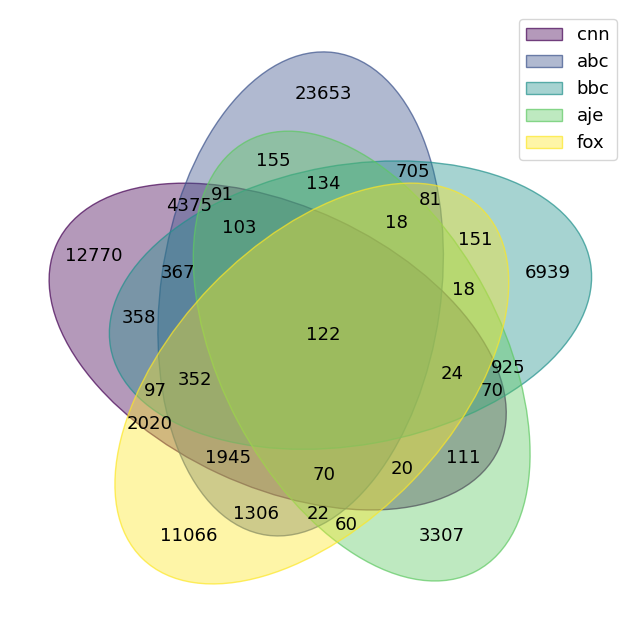

In [31]:
#Venn diagram, in order to see if some authors are in both of some clusters

#venn is a library that take a numbers of set and manipulate it to do a venn diagram of more than 3 sets (matplotlib only do up to 3 sets)
import venn
%matplotlib inline
#define set of users because that's what venn diagram take 
set_cnn = set(cluster_cnn.author)
set_abc = set(cluster_abc.author)
set_bbc = set(cluster_bbc.author)
set_aje = set(cluster_aje.author)
set_fox = set(cluster_fox.author)
sets = {
    "cnn": set_cnn,
    "abc": set_abc,
    "bbc": set_bbc,
    "aje": set_aje,
    "fox": set_fox
}

venn.venn(sets)
plt.show()

One can see that only 122 users are the most active in all 5 channels! Some other overlaps between channels can be seen, but there is still a high number of users that are specific to only one.

# Part 3 : Uncovering shared commenting patterns

## Determining the mean pairwise overlap of commented videos for users in our clusters

Here, we are going to get, for each defined cluster, for each pair of users in the clusters, the lists of videos they have commented on. Then we compare these lists to get the common elements, i.e. videos on which both paired users have commented on. We can then divide this by the shortest length among the two lists of videos, thereby getting the fraction of commented videos the paired users have in common. We call this "pairwise overlap of commented videos".

Then, we can for instance calculate the mean pairwise overlap for all users in each cluster, and compare this among the clusters. In particular, we can use a random sample of YouTube users, define it as a control cluster, and calculate its the mean pairwise overlap as well. By comparing the control mean overlap to the values for each of our original clusters, we can see whether we have a higher mean for users that commented frequently under a specific channel than for a random reference sample of users; suggesting that they might have a larger overlap in their interests or at least YouTube watching behaviour.

It's difficult to make a dataframe with the video ids as rows, the user ids as columns, and the entries as booleans showing whether the user has commented on the video, even though it would be a useful format; as this dataframe would be far too big for the amount of videos and users we're considering at this stage.

But, we can save this information in a **sparse matrix** instead! This matrix contains only stores those values which are True (the case when a user *has* commented on a video), and all other entries are implied to be False. As any user will only have commented on a small fraction of all News and politics videos, this will take far less memory.

For this, there is now a function in the utils file called 'get_video_user_entry_data_for_chunk', which takes comment data and a list of users (i.e., a cluster), and returns the raw data needed to create a sparse boolean matrix where each entry $(i,j)$ indicates whether user $j$ has commented on video $i$.

"Raw data" in this case means: A list of row indices and a list of column entries. The sparse matrix will then be formed such that each pair $(row[k], col[k])$ is a True entry.

However this function only works on single dataframes of comment data, and our comment data (all comments under videos in News and politics) is too big, and we need to read it in chunks.

There is a function 'get_video_user_matrix' in the utils file as well which does this automatically.

There are also further preparation steps which needs to be done, as the functions don't work with the normal video_ids and user_ids; instead they require the id's to correspond to the column and row ids in the matrix.
For example: If the video with id "eh743jss" is in row 312 of the matrix, then the video_id given in the comment data should not be "eh743jss" as it was originally, but it should instead be 312.

(The reason for this is that otherwise, the functions would need to do very time-consuming operations, because for every video they would need to look up in which row it should put a True value. Now instead, it can just put the true value in the row corresponding to the index, no lookup needed)

We define in the utils very useful function that do the mapping and inverse mapping of the video.

### Set filenames

In [14]:
# filenames where we want to save the video-author matrices for our clusters
# (note they are not csv files but npz files, I think that is a numpy file format)
video_author_matrix_cnn_cluster_filename = dataset_root_path + "../generated_data/video_author_matrix_cnn_cluster.npz"
video_author_matrix_abc_cluster_filename = dataset_root_path + "../generated_data/video_author_matrix_abc_cluster.npz"
video_author_matrix_bbc_cluster_filename = dataset_root_path + "../generated_data/video_author_matrix_bbc_cluster.npz"
video_author_matrix_aje_cluster_filename = dataset_root_path + "../generated_data/video_author_matrix_aje_cluster.npz"
video_author_matrix_fox_cluster_filename = dataset_root_path + "../generated_data/video_author_matrix_fox_cluster.npz"

### Generate mapping from video id to integer for all videos in News&Pol

In [36]:
# The function dp.get_video_user_entry_data_for_chunk requires our video id's 
# (in the comment data) to be just a rising range of integers! (0, 1, ..., n_videos).

# (Idea: instead of getting the id's of the videos that someone has commented on, we are getting the positions 
# in the matrix of the videos someone has commented on)

# For this, we generate a mapping which maps the original video ids to integers.
videos_news_pol_display_ids_filepath = dataset_root_path + "../generated_data/videos_news_pol_display_ids.csv"
df_videos_news_pol_display_ids = pd.read_csv(videos_news_pol_display_ids_filepath)
video_ids_news_pol_int_mapping = dp.get_int_mapping(df_videos_news_pol_display_ids.display_id)


### Load or generate the video-user matrices for all clusters

In [15]:
comments_news_pol_videos_filepath = dataset_root_path + "../generated_data/comments_news_pol_videos.csv"
# CNN

# if the file exists, load it
if os.path.isfile(video_author_matrix_cnn_cluster_filename):
    video_author_matrix_cnn_cluster = scipy.sparse.load_npz(video_author_matrix_cnn_cluster_filename)
    print(f"Loaded data from file")
else:  # if not, generate it

    video_author_matrix_cnn_cluster = dp.get_video_user_matrix(
    users_to_consider=cluster_cnn.author,
    comment_data_filepath=comments_news_pol_videos_filepath,
    chunksize=1000000,
    video_id_int_mapping=video_ids_news_pol_int_mapping,
    filename=video_author_matrix_cnn_cluster_filename,
    print_stats=True
                                                               )

# ABC

# if the file exists, load it
if os.path.isfile(video_author_matrix_abc_cluster_filename):
    video_author_matrix_abc_cluster = scipy.sparse.load_npz(video_author_matrix_abc_cluster_filename)
    print(f"Loaded data from file")
else:  # if not, generate it

    video_author_matrix_abc_cluster = dp.get_video_user_matrix(
    users_to_consider=cluster_abc.author,
    comment_data_filepath=comments_news_pol_videos_filepath,
    chunksize=1000000,
    video_id_int_mapping=video_ids_news_pol_int_mapping,
    filename=video_author_matrix_abc_cluster_filename,
    print_stats=True
                                                               )
    
# BBC

# if the file exists, load it
if os.path.isfile(video_author_matrix_bbc_cluster_filename):
    video_author_matrix_bbc_cluster = scipy.sparse.load_npz(video_author_matrix_bbc_cluster_filename)
    print(f"Loaded data from file")
else:  # if not, generate it

    video_author_matrix_bbc_cluster = dp.get_video_user_matrix(
    users_to_consider=cluster_bbc.author,
    comment_data_filepath=comments_news_pol_videos_filepath,
    chunksize=1000000,
    video_id_int_mapping=video_ids_news_pol_int_mapping,
    filename=video_author_matrix_bbc_cluster_filename,
    print_stats=True
                                                               )
    
# AJE

# if the file exists, load it
if os.path.isfile(video_author_matrix_aje_cluster_filename):
    video_author_matrix_aje_cluster = scipy.sparse.load_npz(video_author_matrix_aje_cluster_filename)
    print(f"Loaded data from file")
else:  # if not, generate it

    video_author_matrix_aje_cluster = dp.get_video_user_matrix(
    users_to_consider=cluster_aje.author,
    comment_data_filepath=comments_news_pol_videos_filepath,
    chunksize=1000000,
    video_id_int_mapping=video_ids_news_pol_int_mapping,
    filename=video_author_matrix_aje_cluster_filename,
    print_stats=True
                                                               )

# FOX

# if the file exists, load it
if os.path.isfile(video_author_matrix_fox_cluster_filename):
    video_author_matrix_fox_cluster = scipy.sparse.load_npz(video_author_matrix_fox_cluster_filename)
    print(f"Loaded data from file")
else:  # if not, generate it

    video_author_matrix_fox_cluster = dp.get_video_user_matrix(
    users_to_consider=cluster_fox.author,
    comment_data_filepath=comments_news_pol_videos_filepath,
    chunksize=1000000,
    video_id_int_mapping=video_ids_news_pol_int_mapping,
    filename=video_author_matrix_fox_cluster_filename,
    print_stats=True
                                                               )
    

Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file


### Creating mappings to recover the original video and user id's (will be used after in the code)

In [37]:
# If we need to recover the original video id, we can use the following mapping:

recover_original_video_id_news_pol = dp.get_inverse_int_mapping(video_ids_news_pol_int_mapping)

In [35]:
# If we need to recover the original user id's, we can use the following mappings:

# CNN
recover_original_user_ids_cnn_cluster = dp.get_inverse_int_mapping(dp.get_int_mapping(cluster_cnn.author))
# ABC
recover_original_user_ids_abc_cluster = dp.get_inverse_int_mapping(dp.get_int_mapping(cluster_abc.author))
# BBC
recover_original_user_ids_bbc_cluster = dp.get_inverse_int_mapping(dp.get_int_mapping(cluster_bbc.author))
# AJE
recover_original_user_ids_aje_cluster = dp.get_inverse_int_mapping(dp.get_int_mapping(cluster_aje.author))
# FOX
recover_original_user_ids_fox_cluster = dp.get_inverse_int_mapping(dp.get_int_mapping(cluster_fox.author))

## Getting the random sample of users

We are selecting a random sample of Youtube commenters in the news and politics category in order to compare our clusters to it.  

In [49]:
#getting the average size of the main channels clusters as size for the control sample
control_size = ((len(cluster_cnn)+len(cluster_abc)+len(cluster_aje)+len(cluster_abc)+len(cluster_fox))/5).__round__()
control_size

22503

In [50]:
#getting the total number of commenters in the NP category

authors_in_news_pol_filename = dataset_root_path + "../generated_data/authors_in_news_pol.csv"

try:
    authors_in_news_pol = pd.read_csv(authors_in_news_pol_filename, header=0, names=['author']) #file with the news and politics author ids  
except FileNotFoundError:
    authors_in_news_pol = []
    for chunk in pd.read_csv(dataset_root_path + "../generated_data/comments_news_pol_videos.csv", chunksize=1000000 ):
            authors_in_news_pol.extend(chunk['author'].unique().tolist())  # Get the author id in each chunck 
    authors_in_news_pol = pd.Series(authors_in_news_pol, name='author')

    authors_in_news_pol.to_csv(authors_in_news_pol_filename, index=False)

num_of_authors_news_pol = len(authors_in_news_pol) #the length of the list corresponds to the number of unique commenters in News and Politics category

print(f"There are {num_of_authors_news_pol} authors in news and politics.")

There are 35870979 authors in news and politics.


In [ ]:
#generating a ramdom list of numbers for the control sample, size of the list corresponds to size of the random sample (22503). Those random numbers corresponds
#to the index of the author id in the list of all user ids.
import random

control_sample_indices_filename = dataset_root_path + "../generated_data/control_sample_indices.csv"

try:
    control_sample_indices = pd.read_csv(control_sample_indices_filename)
except FileNotFoundError:
    control_sample_indices = random.sample(range(0,num_of_authors_news_pol), k=control_size)
    control_sample_indices = pd.Series(control_sample_indices)
    control_sample_indices.to_csv(control_sample_indices_filename, index=False)



In [ ]:
#generating the control sample by retriving the author ids corresponding to index given by the random control index generated above
control_sample_author_ids_filename = dataset_root_path + "../generated_data/control_sample_author_ids.csv"

try:
    control_sample_author_ids = pd.read_csv(control_sample_author_ids_filename, header=0, names=['author'])
    print("Read data from file")
except FileNotFoundError:
    control_sample_author_ids = authors_in_news_pol.iloc[control_sample_indices]
    control_sample_author_ids.to_csv(control_sample_author_ids_filename, index=False)

# control_sample_author_ids = [authors[i] for i in control_sample_indexes]


In [27]:
# get video user matrix for control sample
# filename where we want to save the video-author matrix for the cluster
video_author_matrix_random_sample_filename = dataset_root_path + "../generated_data/video_author_matrix_random_sample.npz"

In [54]:
# The function dp.get_video_user_entry_data_for_chunk requires our video id's 
# (in the comment data) to be just a rising range of integers! (0, 1, ..., n_videos).

# (Idea: instead of getting the id's of the videos that someone has commented on, we are getting the positions 
# in the matrix of the videos someone has commented on)

# For this, we generate a mapping which maps the original video ids to integers.

video_ids_news_pol_int_mapping = dp.get_int_mapping(df_videos_news_pol_display_ids.display_id)

In [28]:
# random sample sparse matrix creation

# if the file exists, load it
if os.path.isfile(video_author_matrix_random_sample_filename):
    video_author_matrix_random_sample = scipy.sparse.load_npz(video_author_matrix_random_sample_filename)
    print(f"Loaded data from file")
else:  # if not, generate it

    video_author_matrix_random_sample = dp.get_video_user_matrix(
    users_to_consider=control_sample_author_ids.author,
    comment_data_filepath=comments_news_pol_videos_filepath,
    chunksize=1000000,
    video_id_int_mapping=video_ids_news_pol_int_mapping,
    filename=video_author_matrix_random_sample_filename,
    print_stats=True
                                                               )


Loaded data from file


## Getting jaccard index matrices

This corresponds to our "pairwise overlap".

### Testing overlap calculations

We coded 2 ways to calculate a mean of jaccard indexes within two small clusters. This calculation corresponds to our overlap calculation. Those functions (using sklearn function and calculation by hand) are used here to verify the values obtained by a third function, calculating th same thing but by using matrix operations, which is way more efficient than the two others. In that way we verify as we can the results of our mean jaccard indexes between clusters.

In [56]:
#comparison between the three functions to get jaccard index to verify their results, tested on small clusters

#troncation of CNN and BBC clusters to have smaller clusters for the test
troncate_matrix_cnn = video_author_matrix_cnn_cluster[:, :5]
troncate_matrix_bbc = video_author_matrix_bbc_cluster[:, :3]

#jaccard index using sklearn function
jaccard_cnn_bbc_sklearn, jaccard_list_cnn_bbc_sklearn = dp.get_jacc_between_two_clusters_and_get_mean_sklearn_function(troncate_matrix_cnn,
                                                                         troncate_matrix_bbc,
                                                                         recover_original_user_ids_cnn_cluster,
                                                                         recover_original_user_ids_bbc_cluster)
jaccard_cnn_cnn_sklearn, jaccard_list_cnn_cnn_sklearn = dp.get_jacc_between_same_cluster_and_get_mean_sklearn_function(troncate_matrix_cnn,)
print(f"Jaccard index between CNN and BBC using jaccard_score function from sklearn.metrics is {jaccard_cnn_bbc_sklearn} .")
print(f"Jaccard index within CNN using jaccard_score function from sklearn.metrics is {jaccard_cnn_cnn_sklearn} .")

#jaccard index calculated by hand 
jaccard_cnn_bbc_by_hand, jaccard_list_cnn_bbc_by_hand = dp.get_jacc_between_two_clusters_and_get_mean_by_hand(troncate_matrix_cnn,
                                                                         troncate_matrix_bbc,
                                                                         recover_original_user_ids_cnn_cluster,
                                                                         recover_original_user_ids_bbc_cluster)
jaccard_cnn_cnn_by_hand, jaccard_list_cnn_cnn_by_hand = dp.get_jacc_between_same_cluster_and_get_mean_by_hand(troncate_matrix_cnn,)
print(f"Jaccard index between CNN and BBC calculated by hand is {jaccard_cnn_bbc_by_hand} .")
print(f"Jaccard index within CNN calculated by hand is {jaccard_cnn_cnn_by_hand} .")

#jaccard index using matrix calculations
df_mean_jaccard_value_test_cnn_bbc = dataset_root_path + "../generated_data/test_jaccard_index_matrix_calculations_different_clusters.csv"
df_mean_jaccard_value_test_cnn = dataset_root_path + "../generated_data/test_jaccard_index_matrix_calculations_same_cluster.csv"
jaccard_cnn_bbc_matrix_calc = dp.get_jacc_between_two_clusters_and_get_mean(matrix_1=troncate_matrix_cnn,
                                                                         matrix_2=troncate_matrix_bbc,
                                                                         users_to_consider_1=recover_original_user_ids_cnn_cluster.iloc[:5],
                                                                         users_to_consider_2=recover_original_user_ids_bbc_cluster.iloc[:3],filename = df_mean_jaccard_value_test_cnn_bbc)
jaccard_cnn_cnn_matrix_calc = dp.get_jacc_between_same_cluster_and_get_mean(troncate_matrix_cnn,filename = df_mean_jaccard_value_test_cnn)
print(f"Jaccard index between CNN and BBC using jaccard_score function from sklearn.metrics is {jaccard_cnn_bbc_matrix_calc} .")
print(f"Jaccard index within CNN using jaccard_score function from sklearn.metrics is {jaccard_cnn_cnn_matrix_calc} .")




Jaccard index between CNN and BBC using jaccard_score function from sklearn.metrics is 0.0006492785415590793 .
Jaccard index within CNN using jaccard_score function from sklearn.metrics is 0.004674281805159816 .
Jaccard index between CNN and BBC calculated by hand is 0.0006492785415590803 .
Jaccard index within CNN calculated by hand is 0.0046742818051598075 .
    Jaccard index matrix does not exist yet, generating....
    Done.
    Jaccard index matrix does not exist yet, generating....
    Done.
    Calculating mean of jaccard index matrix, excluding the diagonal....
    Done.
Jaccard index between CNN and BBC using jaccard_score function from sklearn.metrics is 0.0006492785488565763 .
Jaccard index within CNN using jaccard_score function from sklearn.metrics is 0.0046742819249629974 .


We have the same results with our 3 ways of calculating the mean jaccard index between two clusters or within one cluster. The most effective method for big clusters is the one using matrix calculations. That's why we will continue with this one for our results.

### Generating mean jaccard index table for 5 main clusters and random sample
We are generating tables containing the mean jaccard index for the different clusters.

Index calculated for a cluster with itself = how close users within a cluster are

Index calculated between two clusters = how close the users between two clusters are = how non-isolated are users in a cluster from users in another

Loaded mean jaccard value table from file


cnn       abc       bbc       aje       fox       rdm
cnn  0.00542  0.002183  0.001241  0.001047  0.002977  0.000034
abc  0.00000  0.001944  0.000956  0.000769  0.001741  0.000053
bbc  0.00000  0.000000  0.001577  0.001197  0.001078  0.000037
aje  0.00000  0.000000  0.000000  0.002042  0.000866  0.000025
fox  0.00000  0.000000  0.000000  0.000000  0.005043  0.000031
rdm  0.00000  0.000000  0.000000  0.000000  0.000000  0.000163

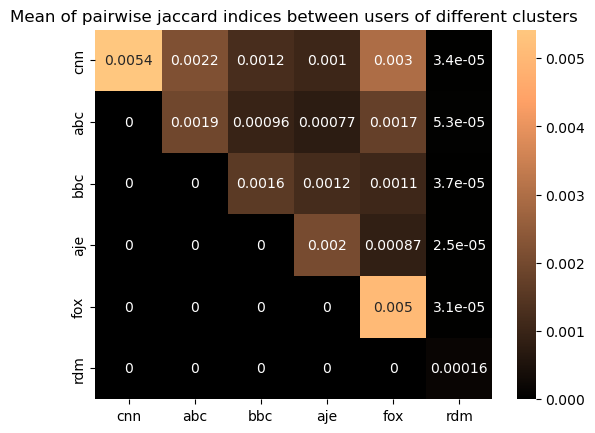

In [35]:
df_mean_jaccard_value_table_main_clusters_filename = dataset_root_path + "../generated_data/mean_jaccard_value_table_main_clusters.csv"

try:
    df_mean_jaccard_value_table_main_clusters = pd.read_csv(df_mean_jaccard_value_table_main_clusters_filename,
                                                            index_col=0)
    print("Loaded mean jaccard value table from file")
except FileNotFoundError:
    
    users_in_clusters = {'cnn': cluster_cnn.author,
                         'abc': cluster_abc.author,
                         'bbc': cluster_bbc.author,
                         'aje': cluster_aje.author,
                         'fox': cluster_fox.author,
                         'rdm': control_sample_author_ids.author}

    video_author_matrices = {'cnn': video_author_matrix_cnn_cluster,
                             'abc': video_author_matrix_abc_cluster,
                             'bbc': video_author_matrix_bbc_cluster,
                             'aje': video_author_matrix_aje_cluster,
                             'fox': video_author_matrix_fox_cluster,
                             'rdm': video_author_matrix_random_sample}
    
    jaccard_filenames = {name1 + "_" + name2: (dataset_root_path 
                               + f'../generated_data/jaccard_matrix_{name1}_{name2}.npy') 
                         for i, name1 in enumerate(['cnn', 'abc', 'bbc', 'aje', 'fox', 'rdm'])
                         for name2 in ['cnn', 'abc', 'bbc', 'aje', 'fox', 'rdm'][i:]}
    
    df_mean_jaccard_value_table_main_clusters = dp.get_mean_jaccard_value_table(video_author_matrices,
                                                                                users_in_clusters,
                                                                                jaccard_filenames,
                                                                                df_mean_jaccard_value_table_main_clusters_filename)

display(df_mean_jaccard_value_table_main_clusters)

sns.heatmap(df_mean_jaccard_value_table_main_clusters, annot=True, cmap='copper')
_ = plt.title("Mean of pairwise jaccard indices between users of different clusters")

### Generating median and other percentile jaccard index table for 5 main clusters and random sample

Generating the same table as above but instead of taking the mean jaccard index for the cluster, we take the median or other percentile jaccard index.

#### Median

Loaded median jaccard value table from file


cnn       abc  bbc       aje       fox  rdm
cnn  0.003738  0.000867  0.0  0.000000  0.001541  0.0
abc  0.000000  0.000649  0.0  0.000000  0.000553  0.0
bbc  0.000000  0.000000  0.0  0.000000  0.000000  0.0
aje  0.000000  0.000000  0.0  0.000747  0.000000  0.0
fox  0.000000  0.000000  0.0  0.000000  0.003434  0.0
rdm  0.000000  0.000000  0.0  0.000000  0.000000  0.0

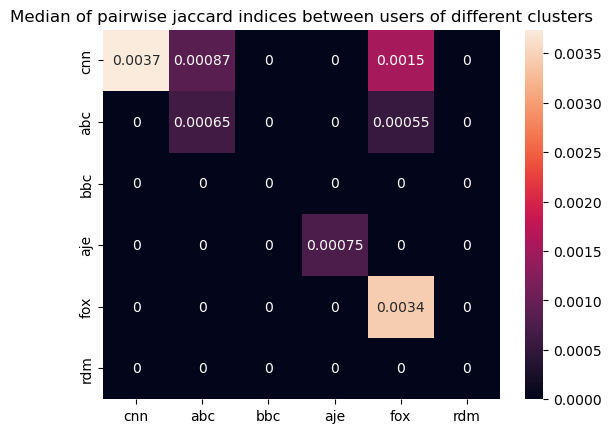

In [58]:
df_median_jaccard_value_table_main_clusters_filename = dataset_root_path + "../generated_data/median_jaccard_value_table_main_clusters.csv"

try:
    df_median_jaccard_value_table_main_clusters = pd.read_csv(df_median_jaccard_value_table_main_clusters_filename,
                                                              index_col=0)
    print("Loaded median jaccard value table from file")
except FileNotFoundError:
    
    users_in_clusters = {'cnn': cluster_cnn.author,
                         'abc': cluster_abc.author,
                         'bbc': cluster_bbc.author,
                         'aje': cluster_aje.author,
                         'fox': cluster_fox.author,
                         'rdm': control_sample_author_ids.author}

    video_author_matrices = {'cnn': video_author_matrix_cnn_cluster,
                             'abc': video_author_matrix_abc_cluster,
                             'bbc': video_author_matrix_bbc_cluster,
                             'aje': video_author_matrix_aje_cluster,
                             'fox': video_author_matrix_fox_cluster,
                             'rdm': video_author_matrix_random_sample}
    
    jaccard_filenames = {name1 + "_" + name2: (dataset_root_path 
                               + f'../generated_data/jaccard_matrix_{name1}_{name2}.npy') 
                         for i, name1 in enumerate(['cnn', 'abc', 'bbc', 'aje', 'fox', 'rdm'])
                         for name2 in ['cnn', 'abc', 'bbc', 'aje', 'fox', 'rdm'][i:]}
    
    df_median_jaccard_value_table_main_clusters = dp.get_mean_jaccard_value_table(video_author_matrices,
                                                                                users_in_clusters,
                                                                                jaccard_filenames,
                                                                                df_median_jaccard_value_table_main_clusters_filename,
                                                                                mode='percentile',
                                                                                percentile=50.)

display(df_median_jaccard_value_table_main_clusters)

sns.heatmap(df_median_jaccard_value_table_main_clusters, annot=True)
_ = plt.title("Median of pairwise jaccard indices between users of different clusters")

#### 70th percentile

Getting Jaccard matrix for cluster cnn with cluster cnn...
    Loaded jaccard index matrix from file
    Calculating percentile of jaccard index matrix, excluding the diagonal....
    Done.
Done.
Getting Jaccard matrix for cluster cnn with cluster abc...
    Loaded jaccard index matrix from file
    Calculating the percentile of the jaccard index matrix....
    Done.
Done.
Getting Jaccard matrix for cluster cnn with cluster bbc...
    Loaded jaccard index matrix from file
    Calculating the percentile of the jaccard index matrix....
    Done.
Done.
Getting Jaccard matrix for cluster cnn with cluster aje...
    Loaded jaccard index matrix from file
    Calculating the percentile of the jaccard index matrix....
    Done.
Done.
Getting Jaccard matrix for cluster cnn with cluster fox...
    Loaded jaccard index matrix from file
    Calculating the percentile of the jaccard index matrix....
    Done.
Done.
Getting Jaccard matrix for cluster cnn with cluster rdm...
    Loaded jaccard index 

cnn       abc       bbc       aje       fox  rdm
cnn  0.006525  0.002288  0.001074  0.000900  0.003295  0.0
abc  0.002288  0.002196  0.000816  0.000560  0.001744  0.0
bbc  0.001074  0.000816  0.001534  0.001125  0.000961  0.0
aje  0.000900  0.000560  0.001125  0.002147  0.000745  0.0
fox  0.003295  0.001744  0.000961  0.000745  0.006112  0.0
rdm  0.000000  0.000000  0.000000  0.000000  0.000000  0.0

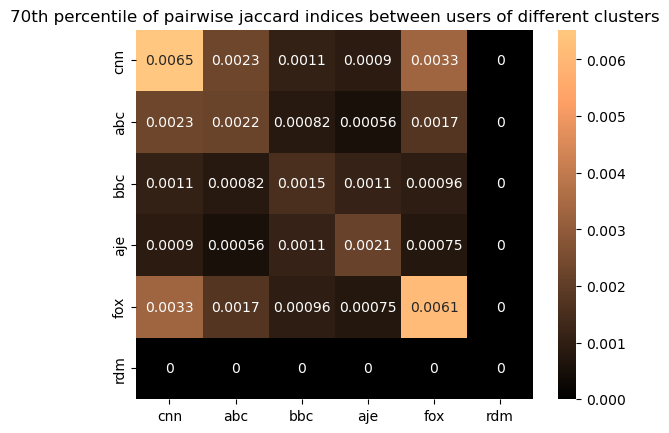

In [59]:
df_70perc_jaccard_value_table_main_clusters_filename = dataset_root_path + "../generated_data/70perc_jaccard_value_table_main_clusters.csv"

try:
    df_70perc_jaccard_value_table_main_clusters = pd.read_csv(df_70perc_jaccard_value_table_main_clusters_filename,
                                                              index_col=0)
    print("Loaded 70perc jaccard value table from file")
except FileNotFoundError:
    
    users_in_clusters = {'cnn': cluster_cnn.author,
                         'abc': cluster_abc.author,
                         'bbc': cluster_bbc.author,
                         'aje': cluster_aje.author,
                         'fox': cluster_fox.author,
                         'rdm': control_sample_author_ids.author}

    video_author_matrices = {'cnn': video_author_matrix_cnn_cluster,
                             'abc': video_author_matrix_abc_cluster,
                             'bbc': video_author_matrix_bbc_cluster,
                             'aje': video_author_matrix_aje_cluster,
                             'fox': video_author_matrix_fox_cluster,
                             'rdm': video_author_matrix_random_sample}
    
    jaccard_filenames = {name1 + "_" + name2: (dataset_root_path 
                               + f'../generated_data/jaccard_matrix_{name1}_{name2}.npy') 
                         for i, name1 in enumerate(['cnn', 'abc', 'bbc', 'aje', 'fox', 'rdm'])
                         for name2 in ['cnn', 'abc', 'bbc', 'aje', 'fox', 'rdm'][i:]}
    
    df_70perc_jaccard_value_table_main_clusters = dp.get_mean_jaccard_value_table(video_author_matrices,
                                                                                  users_in_clusters,
                                                                                  jaccard_filenames,
                                                                                  df_70perc_jaccard_value_table_main_clusters_filename,
                                                                                  mode='percentile',
                                                                                  percentile=70.)

display(df_70perc_jaccard_value_table_main_clusters)

sns.heatmap(df_70perc_jaccard_value_table_main_clusters, annot=True, cmap='copper')
_ = plt.title("70th percentile of pairwise jaccard indices between users of different clusters")

#### 80th percentile

Loaded 80perc jaccard value table from file


cnn       abc       bbc       aje       fox  rdm
cnn  0.008734  0.003559  0.001890  0.001608  0.004848  0.0
abc  0.003559  0.003356  0.001603  0.001279  0.002793  0.0
bbc  0.001890  0.001603  0.002564  0.001964  0.001658  0.0
aje  0.001608  0.001279  0.001964  0.003328  0.001332  0.0
fox  0.004848  0.002793  0.001658  0.001332  0.008216  0.0
rdm  0.000000  0.000000  0.000000  0.000000  0.000000  0.0

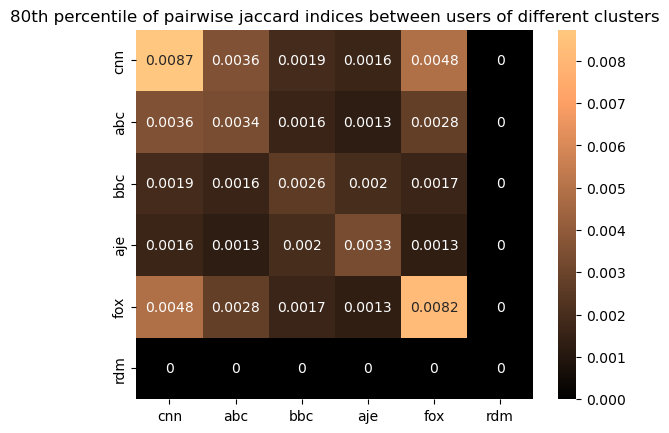

In [47]:
df_80perc_jaccard_value_table_main_clusters_filename = dataset_root_path + "../generated_data/80perc_jaccard_value_table_main_clusters.csv"

try:
    df_80perc_jaccard_value_table_main_clusters = pd.read_csv(df_80perc_jaccard_value_table_main_clusters_filename,
                                                              index_col=0)
    print("Loaded 80perc jaccard value table from file")
except FileNotFoundError:
    
    users_in_clusters = {'cnn': cluster_cnn.author,
                         'abc': cluster_abc.author,
                         'bbc': cluster_bbc.author,
                         'aje': cluster_aje.author,
                         'fox': cluster_fox.author,
                         'rdm': control_sample_author_ids.author}

    video_author_matrices = {'cnn': video_author_matrix_cnn_cluster,
                             'abc': video_author_matrix_abc_cluster,
                             'bbc': video_author_matrix_bbc_cluster,
                             'aje': video_author_matrix_aje_cluster,
                             'fox': video_author_matrix_fox_cluster,
                             'rdm': video_author_matrix_random_sample}
    
    jaccard_filenames = {name1 + "_" + name2: (dataset_root_path 
                               + f'../generated_data/jaccard_matrix_{name1}_{name2}.npy') 
                         for i, name1 in enumerate(['cnn', 'abc', 'bbc', 'aje', 'fox', 'rdm'])
                         for name2 in ['cnn', 'abc', 'bbc', 'aje', 'fox', 'rdm'][i:]}
    
    df_80perc_jaccard_value_table_main_clusters = dp.get_mean_jaccard_value_table(video_author_matrices,
                                                                                  users_in_clusters,
                                                                                  jaccard_filenames,
                                                                                  df_80perc_jaccard_value_table_main_clusters_filename,
                                                                                  mode='percentile',
                                                                                  percentile=80.)

display(df_80perc_jaccard_value_table_main_clusters)

sns.heatmap(df_80perc_jaccard_value_table_main_clusters, annot=True, cmap='copper')
_ = plt.title("80th percentile of pairwise jaccard indices between users of different clusters")

#### 90th percentile

Loaded 90perc jaccard value table from file


cnn       abc       bbc       aje       fox  rdm
cnn  0.012589  0.006067  0.003636  0.003091  0.007772  0.0
abc  0.006067  0.005525  0.002996  0.002454  0.004932  0.0
bbc  0.003636  0.002996  0.004571  0.003575  0.003145  0.0
aje  0.003091  0.002454  0.003575  0.005658  0.002557  0.0
fox  0.007772  0.004932  0.003145  0.002557  0.011846  0.0
rdm  0.000000  0.000000  0.000000  0.000000  0.000000  0.0

Text(0.5, 1.0, '90th percentile of pairwise jaccard indices between users of different clusters')

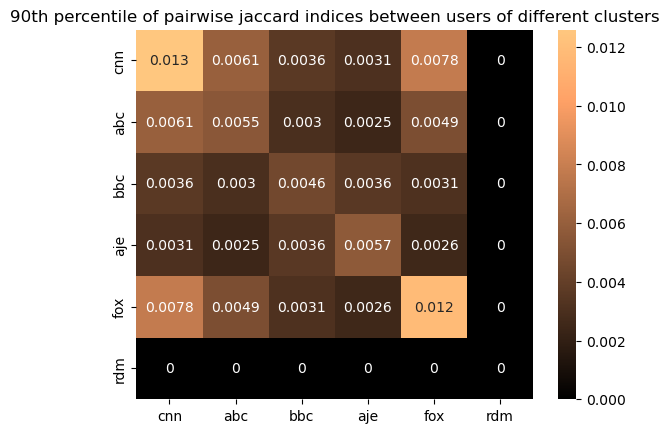

In [46]:
df_90perc_jaccard_value_table_main_clusters_filename = dataset_root_path + "../generated_data/90perc_jaccard_value_table_main_clusters.csv"

try:
    df_90perc_jaccard_value_table_main_clusters = pd.read_csv(df_90perc_jaccard_value_table_main_clusters_filename,
                                                              index_col=0)
    print("Loaded 90perc jaccard value table from file")
except FileNotFoundError:
    
    users_in_clusters = {'cnn': cluster_cnn.author,
                         'abc': cluster_abc.author,
                         'bbc': cluster_bbc.author,
                         'aje': cluster_aje.author,
                         'fox': cluster_fox.author,
                         'rdm': control_sample_author_ids.author}

    video_author_matrices = {'cnn': video_author_matrix_cnn_cluster,
                             'abc': video_author_matrix_abc_cluster,
                             'bbc': video_author_matrix_bbc_cluster,
                             'aje': video_author_matrix_aje_cluster,
                             'fox': video_author_matrix_fox_cluster,
                             'rdm': video_author_matrix_random_sample}
    
    jaccard_filenames = {name1 + "_" + name2: (dataset_root_path 
                               + f'../generated_data/jaccard_matrix_{name1}_{name2}.npy') 
                         for i, name1 in enumerate(['cnn', 'abc', 'bbc', 'aje', 'fox', 'rdm'])
                         for name2 in ['cnn', 'abc', 'bbc', 'aje', 'fox', 'rdm'][i:]}
    
    df_90perc_jaccard_value_table_main_clusters = dp.get_mean_jaccard_value_table(video_author_matrices,
                                                                                  users_in_clusters,
                                                                                  jaccard_filenames,
                                                                                  df_90perc_jaccard_value_table_main_clusters_filename,
                                                                                  mode='percentile',
                                                                                  percentile=90.)

display(df_90perc_jaccard_value_table_main_clusters)

sns.heatmap(df_90perc_jaccard_value_table_main_clusters, annot=True, cmap='copper')
_ = plt.title("90th percentile of pairwise jaccard indices between users of different clusters")

### Generating lin-log and log-log histograms displaying the distribution of the jaccard indices of all pairs within a cluster or between two clusters

In [60]:
users_in_clusters = {'cnn': cluster_cnn.author,
                         'abc': cluster_abc.author,
                         'bbc': cluster_bbc.author,
                         'aje': cluster_aje.author,
                         'fox': cluster_fox.author,
                         'rdm': control_sample_author_ids.author}

video_author_matrices = {'cnn': video_author_matrix_cnn_cluster,
                            'abc': video_author_matrix_abc_cluster,
                            'bbc': video_author_matrix_bbc_cluster,
                            'aje': video_author_matrix_aje_cluster,
                            'fox': video_author_matrix_fox_cluster,
                            'rdm': video_author_matrix_random_sample}

jaccard_filenames = {name1 + "_" + name2: (dataset_root_path 
                                           + f'../generated_data/jaccard_matrix_{name1}_{name2}.npy') 
                     for i, name1 in enumerate(['cnn', 'abc', 'bbc', 'aje', 'fox', 'rdm'])
                     for name2 in ['cnn', 'abc', 'bbc', 'aje', 'fox', 'rdm'][i:]}

#### Creating separate plots for each cluster combination

Getting Jaccard index histograms for cluster cnn with cluster cnn...
Plots are already existing, skipping...
Getting Jaccard index histograms for cluster cnn with cluster abc...
Plots are already existing, skipping...
Getting Jaccard index histograms for cluster cnn with cluster bbc...
Plots are already existing, skipping...
Getting Jaccard index histograms for cluster cnn with cluster aje...
Plots are already existing, skipping...
Getting Jaccard index histograms for cluster cnn with cluster fox...
Plots are already existing, skipping...
Getting Jaccard index histograms for cluster cnn with cluster rdm...
Plots are already existing, skipping...
Getting Jaccard index histograms for cluster abc with cluster abc...
Plots are already existing, skipping...
Getting Jaccard index histograms for cluster abc with cluster bbc...
Plots are already existing, skipping...
Getting Jaccard index histograms for cluster abc with cluster aje...
Plots are already existing, skipping...
Getting Jaccard ind

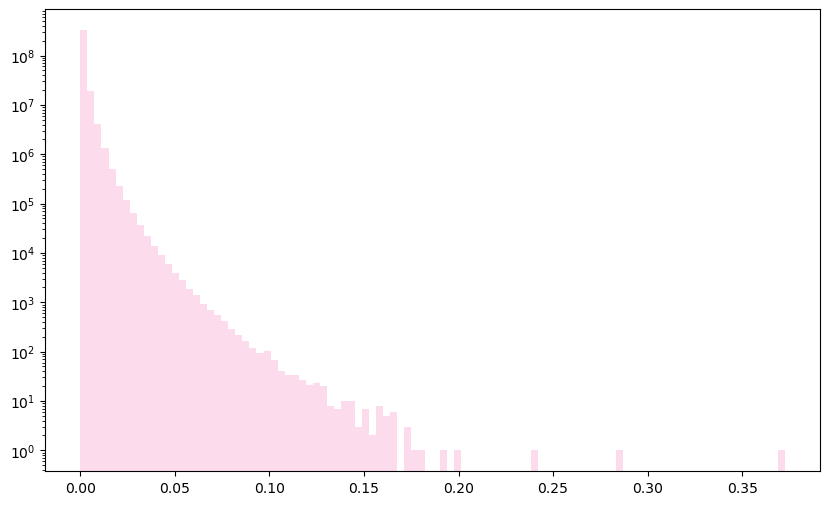

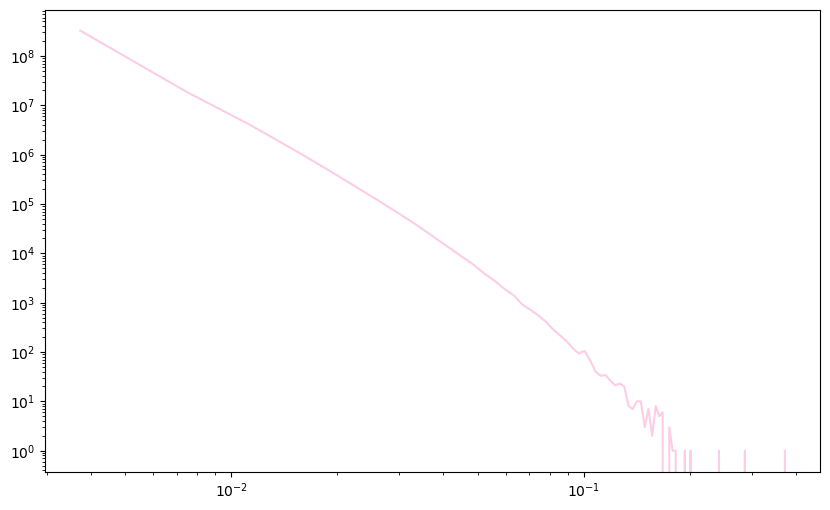

In [ ]:
dp.create_jaccard_index_histograms_for_all_cluster_combinations(video_author_matrices, 
                                                                users_in_clusters, 
                                                                jaccard_filenames,
                                                                base_filename="src/figures/hist_of_pairwise_jacc_index",
                                                                show=True)

#### Creating subplot figures containing histograms for all cluster combinations

Getting Jaccard index histograms for cluster cnn with cluster cnn...
Jaccard index matrix loaded.
Jaccard dtype is float32
Jaccard dtype is float16
Done.
Getting Jaccard index histograms for cluster cnn with cluster abc...
Jaccard index matrix loaded.
Jaccard dtype is float32
Jaccard dtype is float16
Done.
Getting Jaccard index histograms for cluster cnn with cluster bbc...
Jaccard index matrix loaded.
Jaccard dtype is float32
Jaccard dtype is float16
Done.
Getting Jaccard index histograms for cluster cnn with cluster aje...
Jaccard index matrix loaded.
Jaccard dtype is float32
Jaccard dtype is float16
Done.
Getting Jaccard index histograms for cluster cnn with cluster fox...
Jaccard index matrix loaded.
Jaccard dtype is float32
Jaccard dtype is float16
Done.
Getting Jaccard index histograms for cluster cnn with cluster rdm...
Jaccard index matrix loaded.
Jaccard dtype is float32
Jaccard dtype is float16
Done.
Getting Jaccard index histograms for cluster abc with cluster abc...
Jaccard

/home/andreas/Nextcloud/Dokumente/Uni/Module/3sem-EPFL/ada/Project/ada-2024-project-thedataminions/src/utils/utils.py:2116: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_linlog.show()


Saved loglog plot in file src/figures/subplots_loglog_hist_of_pairwise_jacc_index_test.png.


/home/andreas/Nextcloud/Dokumente/Uni/Module/3sem-EPFL/ada/Project/ada-2024-project-thedataminions/src/utils/utils.py:2122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_loglog.show()


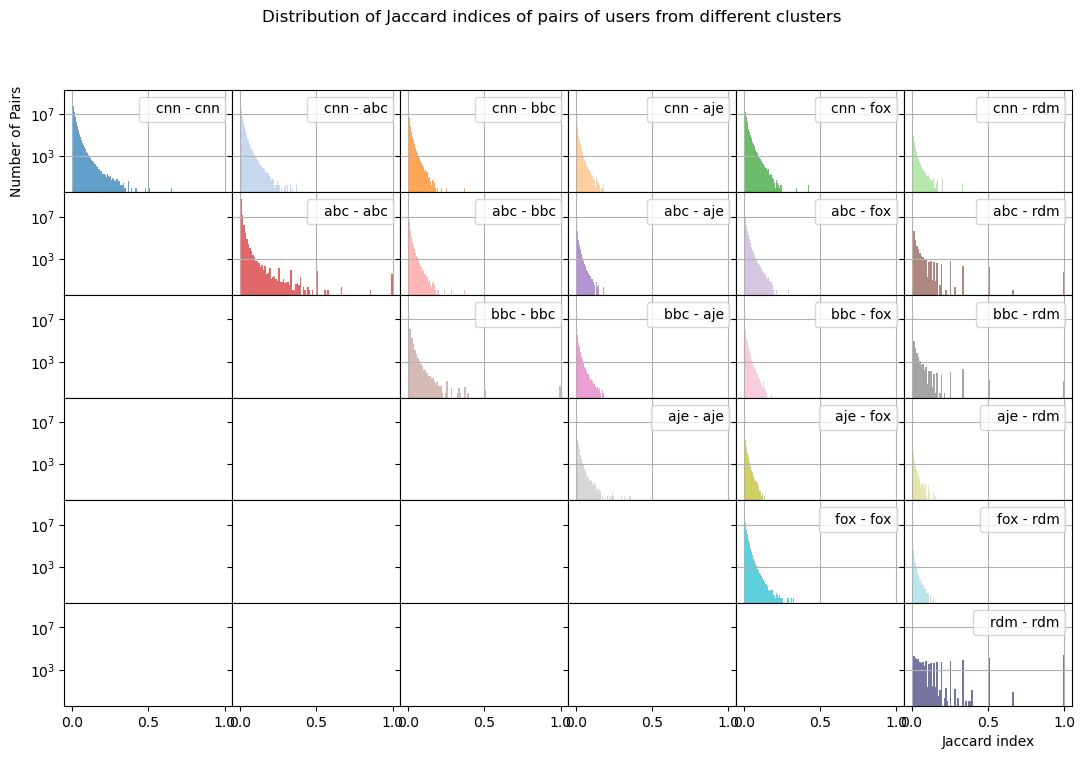

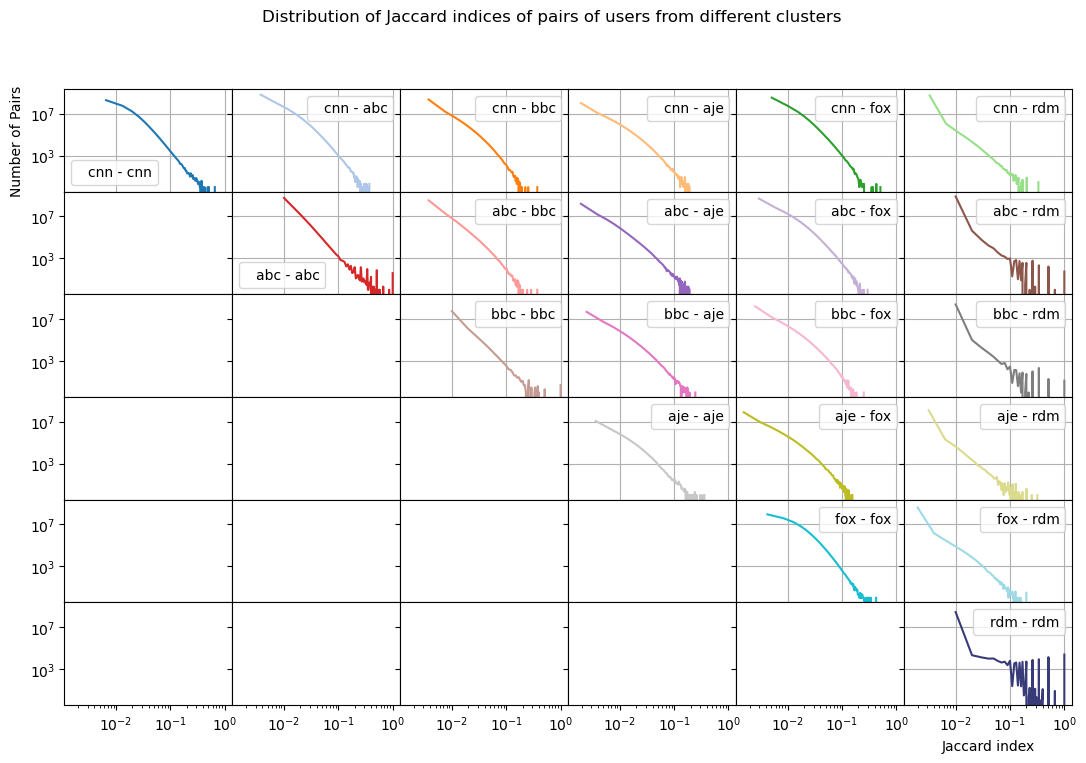

In [17]:
dp.make_subplot_grid_with_jaccard_index_histograms(video_author_matrices, 
                                                   users_in_clusters, 
                                                   jaccard_filenames,
                                                   mode='both',
                                                   linlog_filename="src/figures/subplots_linlog_hist_of_pairwise_jacc_index_test.png",
                                                   loglog_filename="src/figures/subplots_loglog_hist_of_pairwise_jacc_index_test.png",
                                                   show=True)

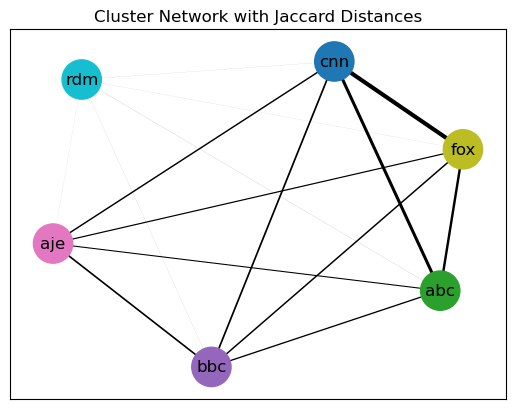

In [16]:
#plotting network graph of clusters
dp.network_graph_clusters(df_mean_jaccard_value_table_main_clusters)

## Examine whether there are multiple users' bubbles within a cluster

Now we are looking for users' bubbles in the same cluster based on the **similarity of commented videos**, using DBSCAN algorithm. 

Here are the steps :

- Take Andrea's sparse matrix of a cluster (columns = users, rows = videos), where booleans indicate if the user has commented on a video or not

- Transform the sparse matrix to a distance matrix using the Cosine distance method, which returns a jxj matrix ( j = number of users of the cluster ) containing integers between 0-1, which indicate the distance between each pair of users in terms of commenting behavior (0=close=similar, 1=distant=not similar)

- Choose the optimal **min_samples** parameter for DBSCAN, i.e the minimum number of users in a bubble (minimum bubble size).

- Choose the optimal **eps** parameter for DBSCAN, i.e the minimum distance between two users for them to be considered in the same cluster. If eps is too low, many users will be classified as outliers (bubble '-1').

- Run DBSCAN on the distance matrix: what is returned, 'labels', is the assigned bubble for each user (1D list of integers, and '-1' bubble is for outliers). The user id is not specified, but this 'label' list is in the same order as the columns in the input distance matrix.

- Visualize bubbles (I tested PCA, t-SNE, but they aren't very nice. Will try with the Netkokx, which should be much nicer !)

- Generate a sparse matrix (columns = users, rows = videos), like the initil one, but for each bubble. Saved them with paths.


In [16]:
video_author_matrices = {'cnn': video_author_matrix_cnn_cluster,
                            'abc': video_author_matrix_abc_cluster,
                            'bbc': video_author_matrix_bbc_cluster,
                            'aje': video_author_matrix_aje_cluster,
                            'fox': video_author_matrix_fox_cluster }

In [21]:
# Calculate pairwise distances (cosine distances between users)
# Using the video-author matrix transposed as your input matrix
distance_matrices = {}

for key in video_author_matrices.keys():
    distance_matrix = pairwise_distances(video_author_matrices[key].T, metric='cosine')
    distance_matrices[key] = distance_matrix

In the following cells, we explore users' commenting data in the 5 defined clusters (CNN, ABC, BBC, AJE and FOX) to help us choose the optimal eps and min_samples for further DBSCAN clustering. 

For each cluster, we first have a look at the sparsity between users, then check the max and min (Cosine) distance is.

##### Sparsity of each cluster

In [23]:
for key in video_author_matrices.keys():
    # Measure sparsity of the data
    nonzero_elements = video_author_matrices[key].nnz
    total_elements = video_author_matrices[key].shape[0] * video_author_matrices[key].shape[1]
    sparsity = 1 - (nonzero_elements / total_elements)

    print(f"Sparsity of {key} cluster: {sparsity:.4f}")

    # Adjust DBSCAN parameters based on sparsity
    if sparsity > 0.70:
        print("Data is sparse. Consider smaller eps and min_samples.")
    else:
        print("Data is dense. Consider larger eps and min_samples.")

Sparsity of cnn cluster: 0.9999
Data is sparse. Consider smaller eps and min_samples.
Sparsity of abc cluster: 0.9999
Data is sparse. Consider smaller eps and min_samples.
Sparsity of bbc cluster: 0.9999
Data is sparse. Consider smaller eps and min_samples.
Sparsity of aje cluster: 0.9999
Data is sparse. Consider smaller eps and min_samples.
Sparsity of fox cluster: 0.9999
Data is sparse. Consider smaller eps and min_samples.


##### Minimum and maximum distance between two users, in each cluster

In [63]:
# Get the minimum and maximum cosine distance values to know in which range EPS has to be
for key in distance_matrices.keys():
    print(key, 'cluster:')
    print(f"Minimum Cosine Distance: {np.min(distance_matrices[key])}")
    print(f"Maximum Cosine Distance: {np.max(distance_matrices[key])}")

cnn cluster:
Minimum Cosine Distance: 0.0
Maximum Cosine Distance: 1.0
abc cluster:
Minimum Cosine Distance: 0.0
Maximum Cosine Distance: 1.0
bbc cluster:
Minimum Cosine Distance: 0.0
Maximum Cosine Distance: 1.0
aje cluster:
Minimum Cosine Distance: 0.0
Maximum Cosine Distance: 1.0
fox cluster:
Minimum Cosine Distance: 0.0
Maximum Cosine Distance: 1.0


##### Test DBSCAN clustering with relevant eps/min_samples combinations (on FOX)

First, we try bubbling FOX's users with some eps/min_samples combinations until we obtain a satisfactory result, i.e having some bubbles and not too many outliers.

In [110]:
eps_values = [0.6, 0.8, 0.9]
min_samples_values = [4, 5, 10, 50, 100]

for eps in eps_values:
    for min_samples in min_samples_values:
        model = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        labels = model.fit_predict(video_author_matrix_fox_cluster.T)

        #count bubbles and outliers
        n_bubbles = len(set(labels)) - (1 if -1 in labels else 0)
        n_outliers = list(labels).count(-1)

        print(f"eps={eps:.6f}, min_samples={min_samples}: {n_bubbles} clusters, {n_outliers} outliers")

eps=0.600000, min_samples=4: 0 clusters, 17372 outliers
eps=0.600000, min_samples=5: 0 clusters, 17372 outliers
eps=0.600000, min_samples=10: 0 clusters, 17372 outliers
eps=0.600000, min_samples=50: 0 clusters, 17372 outliers
eps=0.600000, min_samples=100: 0 clusters, 17372 outliers
eps=0.800000, min_samples=4: 8 clusters, 17014 outliers
eps=0.800000, min_samples=5: 5 clusters, 17031 outliers
eps=0.800000, min_samples=10: 3 clusters, 17056 outliers
eps=0.800000, min_samples=50: 2 clusters, 17180 outliers
eps=0.800000, min_samples=100: 0 clusters, 17372 outliers
eps=0.900000, min_samples=4: 7 clusters, 11834 outliers
eps=0.900000, min_samples=5: 6 clusters, 11868 outliers
eps=0.900000, min_samples=10: 3 clusters, 11989 outliers
eps=0.900000, min_samples=50: 1 clusters, 12555 outliers
eps=0.900000, min_samples=100: 1 clusters, 12863 outliers


We can see that min_sample = 50 and 100 give very few bubbles, indicating that the minimum size is too high. We thus continue our tests with 4, 5 and 10, while zooming in eps_values between 0.85 and 0.95.

In [111]:
# added some more values
eps_values = [0.85, 0.88, 0.89, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
min_samples_values = [2, 3, 4, 5, 8, 10, 13, 15, 18, 20, 25, 30, 40, 50, 100]

for eps in eps_values:
    for min_samples in min_samples_values:
        model = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        labels = model.fit_predict(video_author_matrix_fox_cluster.T)

        #count bubbles and outliers
        n_bubbles = len(set(labels)) - (1 if -1 in labels else 0)
        n_outliers = list(labels).count(-1)
        gc.collect()
        print(f"eps={eps:.6f}, min_samples={min_samples}: {n_bubbles} clusters, {n_outliers} outliers")

eps=0.850000, min_samples=4: 15 clusters, 15963 outliers
eps=0.850000, min_samples=5: 11 clusters, 15985 outliers
eps=0.850000, min_samples=10: 4 clusters, 16109 outliers
eps=0.880000, min_samples=4: 12 clusters, 14200 outliers
eps=0.880000, min_samples=5: 7 clusters, 14240 outliers
eps=0.880000, min_samples=10: 3 clusters, 14356 outliers
eps=0.890000, min_samples=4: 6 clusters, 13148 outliers
eps=0.890000, min_samples=5: 6 clusters, 13174 outliers
eps=0.890000, min_samples=10: 3 clusters, 13310 outliers
eps=0.910000, min_samples=4: 3 clusters, 10239 outliers
eps=0.910000, min_samples=5: 2 clusters, 10274 outliers
eps=0.910000, min_samples=10: 2 clusters, 10390 outliers
eps=0.930000, min_samples=4: 4 clusters, 6149 outliers
eps=0.930000, min_samples=5: 2 clusters, 6177 outliers
eps=0.930000, min_samples=10: 1 clusters, 6288 outliers
eps=0.950000, min_samples=4: 1 clusters, 2012 outliers
eps=0.950000, min_samples=5: 1 clusters, 2024 outliers
eps=0.950000, min_samples=10: 1 clusters, 205

Interesting parameter combinations for FOX:

    eps=0.890000, min_samples=4: 6 clusters, 13148 outliers
    eps=0.900000, min_samples=4: 7 clusters, 11834 outliers
    eps=0.910000, min_samples=4: 3 clusters, 10239 outliers

Parameters chosen for all clusters: 

    eps = 0.9 
    min_samples = 8 (4 was too low for the other clusters)    

In [19]:
opt_eps = 0.9
opt_min_samples = 8

#initialize dict to store labels from dbscan
labels_dict = {}

#initialize dict to store number of bubbles 
n_bubbles_dict = {}

#iterate on the 5 clusters
for key in distance_matrices.keys():

    #define clustring model
    model = DBSCAN(eps=opt_eps, min_samples=opt_min_samples, metric='precomputed')

    #1D array containing the bubble to which each user belongs, in the same order of the users of sparse matrix
    labels = model.fit_predict(distance_matrices[key])  
    
    #add labels to dict
    labels_dict[key] = labels      

    #count the bubbles (excluding outliers)
    unique_bubbles = set(labels) - {-1}  # Exclude the outlier label (-1)
    n_bubbles_dict[key] = len(unique_bubbles)                           

    #print the number of users in each bubble
    bubble_counts = Counter(labels)
    print("Number of users in each bubble,", key, ":")
    for bubble, count in bubble_counts.items():
        if bubble == -1:
            print(f"Outliers: {count} users")
        else:
            print(f"Bubble {bubble}: {count} users")


Number of users in each bubble, cnn :
Outliers: 14326 users
Bubble 0: 8518 users
Bubble 2: 16 users
Bubble 1: 9 users
Bubble 4: 8 users
Bubble 5: 10 users
Bubble 3: 8 users
Number of users in each bubble, abc :
Outliers: 25983 users
Bubble 0: 7238 users
Bubble 8: 16 users
Bubble 20: 6 users
Bubble 7: 9 users
Bubble 13: 9 users
Bubble 2: 36 users
Bubble 12: 26 users
Bubble 16: 6 users
Bubble 14: 5 users
Bubble 1: 15 users
Bubble 11: 8 users
Bubble 9: 5 users
Bubble 6: 10 users
Bubble 3: 13 users
Bubble 19: 18 users
Bubble 21: 6 users
Bubble 4: 7 users
Bubble 22: 7 users
Bubble 10: 18 users
Bubble 5: 6 users
Bubble 23: 10 users
Bubble 18: 9 users
Bubble 15: 11 users
Bubble 17: 7 users
Bubble 24: 5 users
Bubble 25: 10 users
Number of users in each bubble, bbc :
Outliers: 7988 users
Bubble 0: 2254 users
Bubble 12: 19 users
Bubble 1: 59 users
Bubble 19: 9 users
Bubble 3: 8 users
Bubble 5: 9 users
Bubble 4: 8 users
Bubble 2: 8 users
Bubble 14: 4 users
Bubble 11: 10 users
Bubble 6: 10 users
B

#### Trying different visualizations on FOX bubbles (PCA, t-SNE, and Networkx)

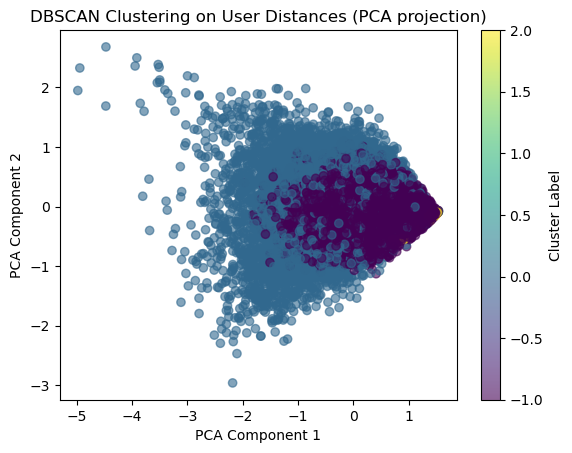

In [114]:
#visualize bubbles using PCA

from sklearn.decomposition import PCA

# Get the distance matrix for a given subset (e.g., for key = 'subset_1')
distance_matrix = distance_matrices['fox']

# Apply PCA to reduce to 2D (or 3D if you prefer)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(distance_matrix)

# Plotting the 2D representation
plt.scatter(pca_result[:, 0][labels_dict['fox'] == -1], pca_result[:, 1][labels_dict['fox'] == -1], c=labels_dict['fox'][labels_dict['fox'] == -1], cmap='viridis', alpha=0.05)
plt.scatter(pca_result[:, 0][labels_dict['fox'] != -1], pca_result[:, 1][labels_dict['fox'] != -1], c=labels_dict['fox'][labels_dict['fox'] != -1], cmap='viridis', alpha=0.9)
plt.title('DBSCAN Clustering on User Distances (PCA projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [65]:
from sklearn.manifold import TSNE

distance_matrix = distance_matrices['fox']

# Apply t-SNE to the distance matrix (you can also use PCA first if needed)
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(distance_matrix)

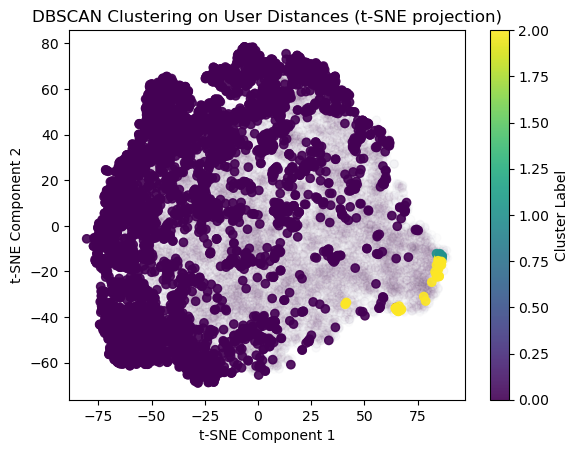

In [66]:
# Plotting the 2D t-SNE result
plt.scatter(tsne_result[:, 0][labels_dict['fox'] == -1], tsne_result[:, 1][labels_dict['fox'] == -1], c=labels_dict['fox'][labels_dict['fox'] == -1], cmap='viridis', alpha = 0.01)
plt.scatter(tsne_result[:, 0][labels_dict['fox'] != -1], tsne_result[:, 1][labels_dict['fox'] != -1], c=labels_dict['fox'][labels_dict['fox'] != -1], cmap='viridis', alpha = 0.9)
plt.title('DBSCAN Clustering on User Distances (t-SNE projection)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [23]:
#define the dict to store paths
bubbles_paths = {}

#use a dictionary comprehension to generate the paths dynamically
for channel, count in n_bubbles_dict.items():
    paths = []
    for i in range(count):
        path = f"{dataset_root_path}../generated_data/video_author_matrix_{channel}_b{i}.npz"
        paths.append(path)
        bubbles_paths[channel] = paths

##### Generate sparse matrices for each bubble (or read from files)

In [24]:
#define dict to store sparse matrices of the bubbles
bubbles_video_author_matrices = {}

#iterate on clusters 
for key in bubbles_paths.keys():
        print(key)

        #define liste of matrices
        matrices = []

        #iterate on bubbles of the cluster
        for bubble in range(len(bubbles_paths[key])):
                # if the file exists, load it in the dict
                if os.path.isfile(bubbles_paths[key][bubble]):
                        #load and add matrix to list
                        matrices.append(scipy.sparse.load_npz(bubbles_paths[key][bubble]))
                        print(f"Loaded data from file")
                
                # if not, generate it
                else:
                        #get id of bubbles in the cluster
                        bubbles_id = np.unique(labels_dict[key])
                        bubbles_id = bubbles_id[bubbles_id != -1]  # Exclude -1 for outliers

                        #get users of the bubble
                        users = np.where(labels_dict[key] == id)[0]
                        
                        #slice users from the sparse matrix of the cluster
                        matrix = video_author_matrices[key][:, users]

                        #add matrix to list
                        matrices.append(matrix)
                        
                        #save matrix in
                        scipy.sparse.save_npz(bubbles_paths[key][id], matrix)

                        print(f"Saved file {bubbles_paths[key][id]}")

                        print(f"Bubble {id}: {matrix.shape} (videos x users)")

        #add list of matrices to dict 
        bubbles_video_author_matrices[key] = matrices

cnn
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
abc
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
bbc
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from file
Loaded data from fil

In [ ]:
dp.network_graph_bubbles(distance_matrices, labels_dict)

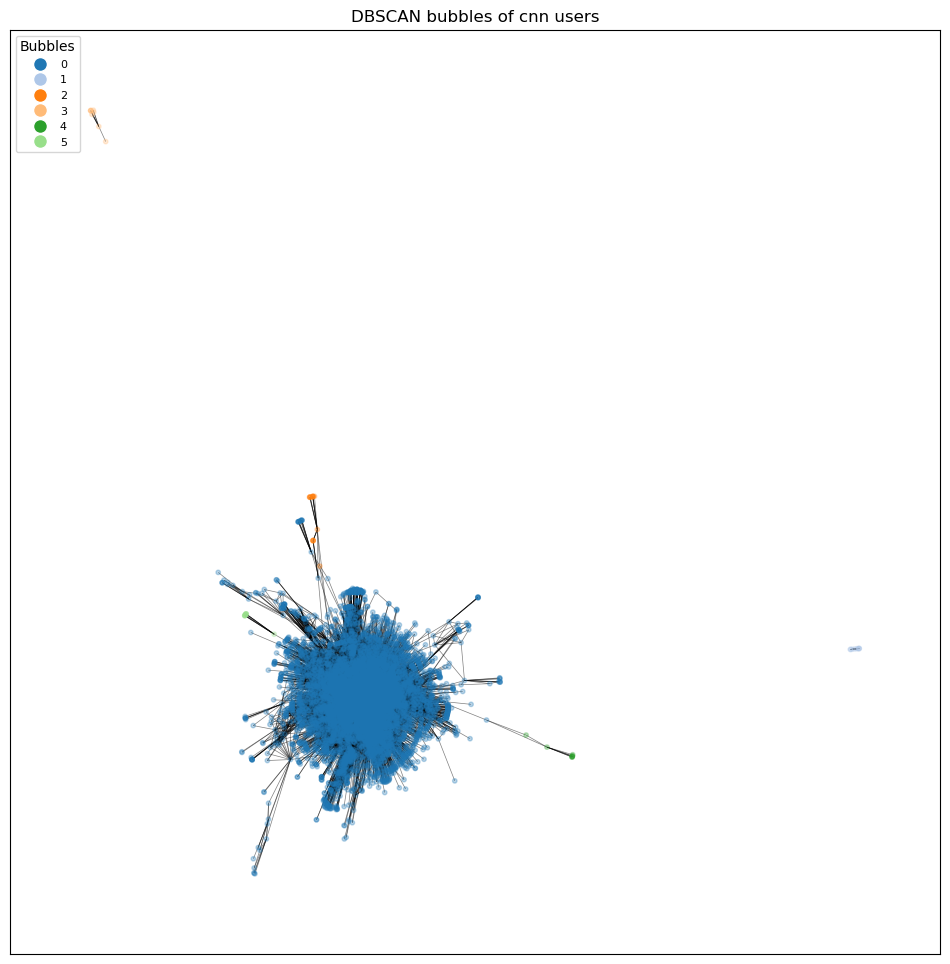

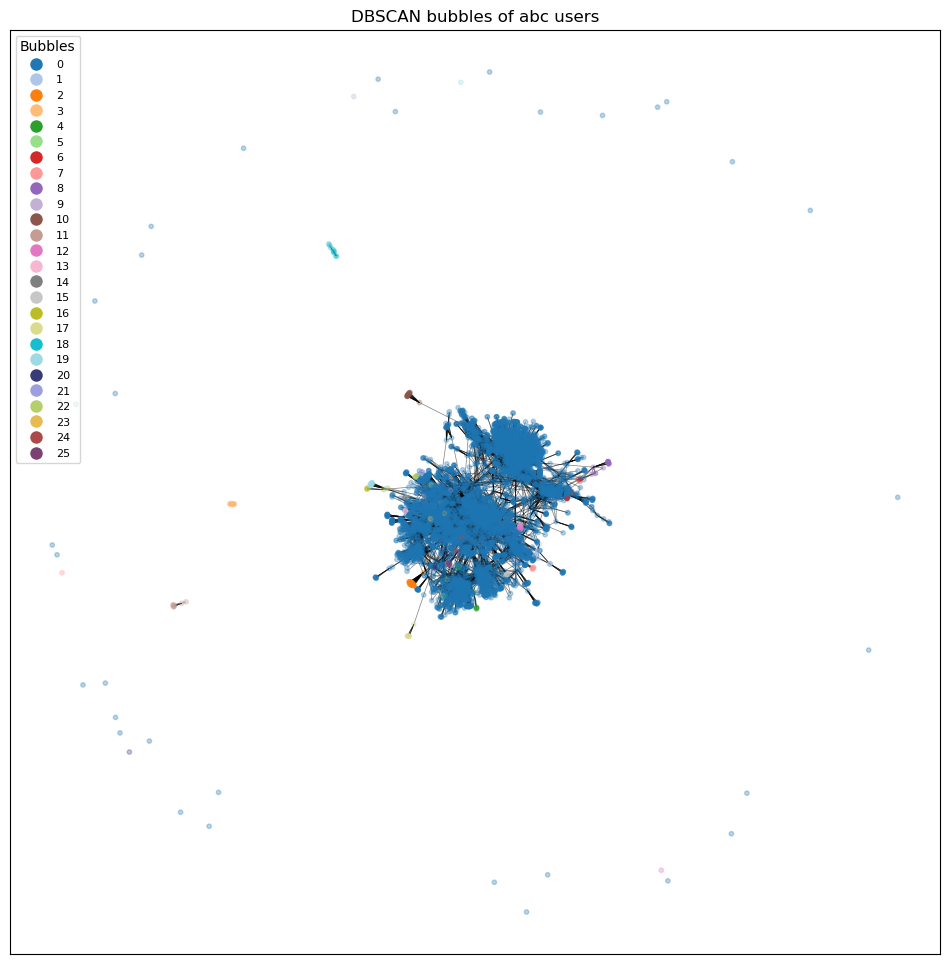

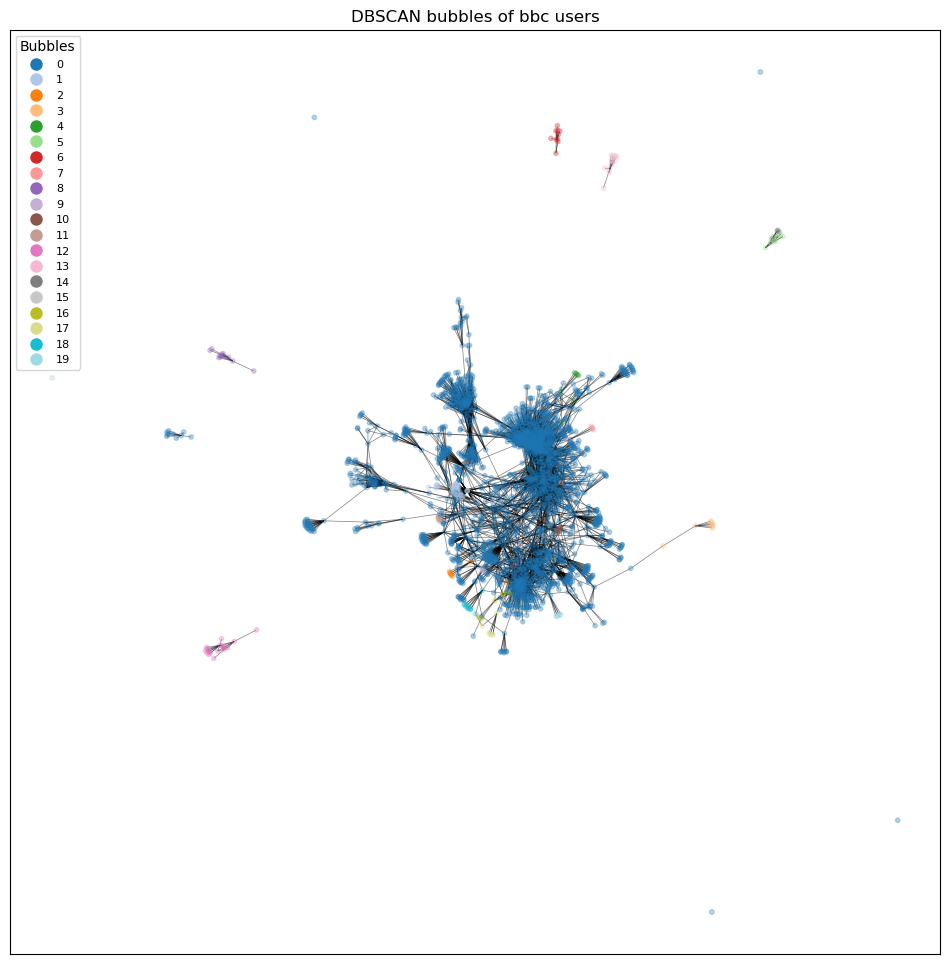

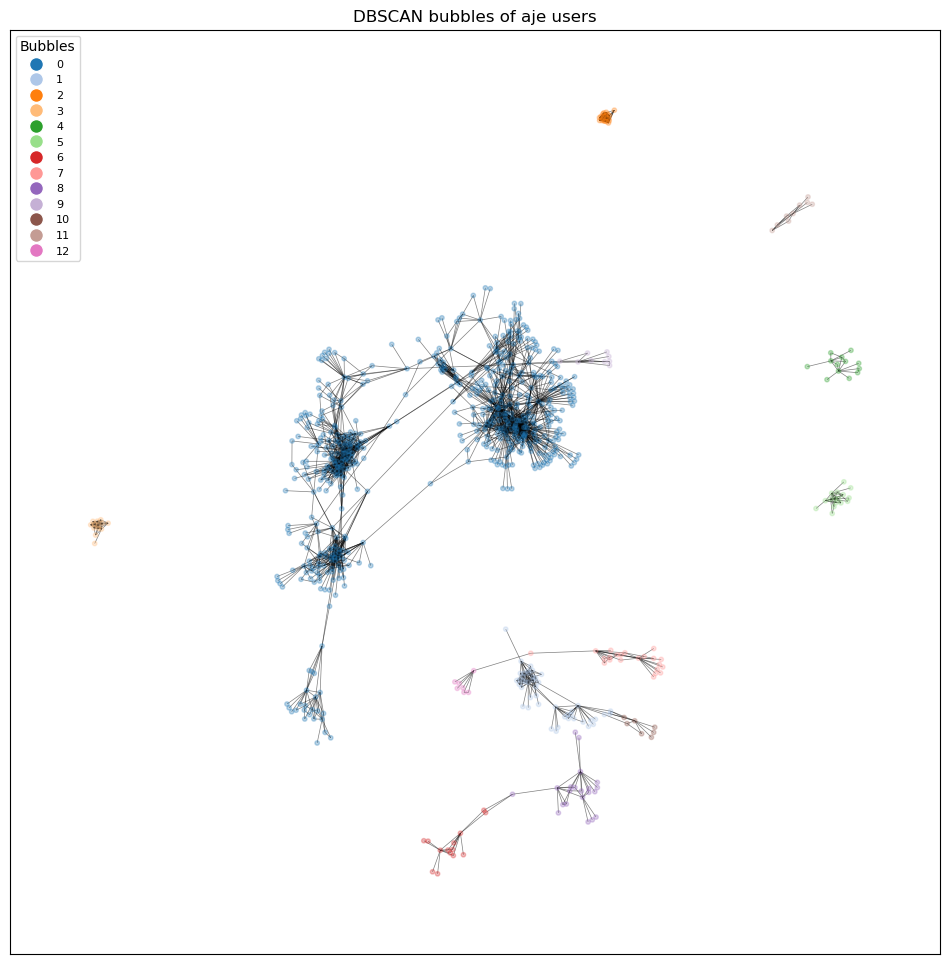

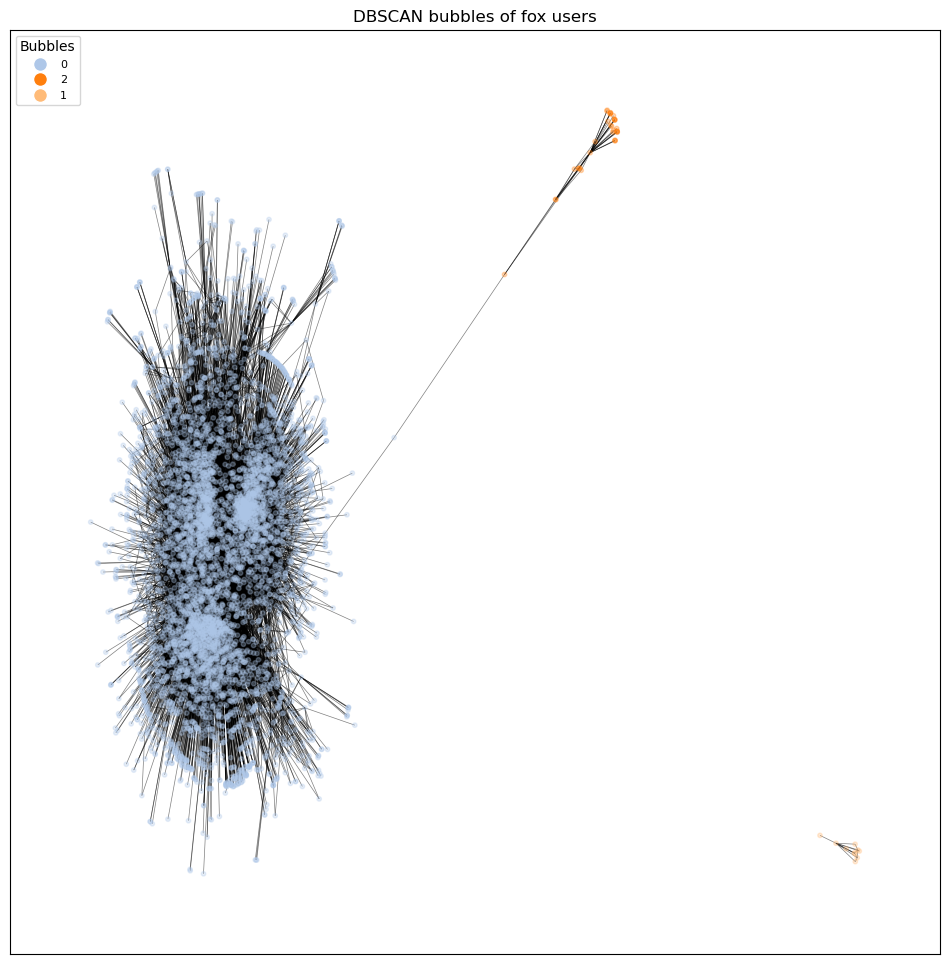

In [23]:
dp.network_graph_bubbles_without_outliers(distance_matrices, labels_dict)

## Perform pairwise overlap on the bubbles defined by DBSCAN

- We will now use the sparse video-user matrices containing commenting information of the users for each bubble computed above useing DBSCAN. The sparse matrices have columns = users and rows = videos; if a user has commented on a video, the stored value is True. 

- Using these, we will do similar mean jaccard index tables/heatmaps as we did before for the 5 main clusters, but now for different combinations of bubbles found by DBSCAN.

### Box plot of mean jaccard index for users within the bubbles of each cluster

In [70]:
channel_averages= dp.average_pairwise_overlap(bubbles_video_author_matrices)

First, we create a box plot, which shows the distributions of the mean jaccard index of users within each bubble found above using DBSCAN.

That is, for each bubble, the jaccard index is calculated for each pair of users contained in the bubble, and the mean is calculated. The box plot then shows how these values are distributed.

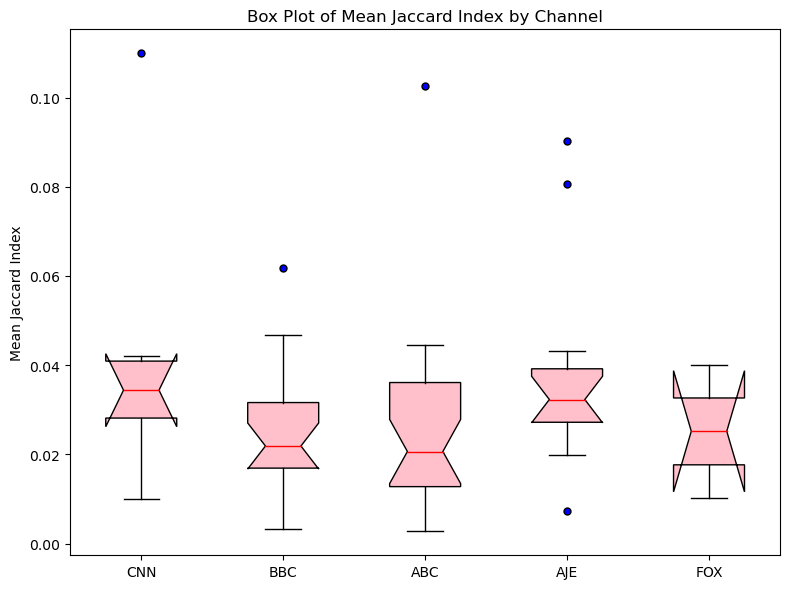

In [71]:
# Create a box plot for the data
data_list = [
    channel_averages['cnn'],   
    channel_averages['bbc'],   
    channel_averages['abc'],   
    channel_averages['aje'],   
    channel_averages['fox']  
]

channels = ["CNN", "BBC", "ABC", "AJE", "FOX"]

fig, ax = plt.subplots(figsize=(8, 6))

# Create the box plot
ax.boxplot(data_list, vert=True, patch_artist=True, notch=True, 
           boxprops=dict(facecolor='pink'),
           flierprops=dict(markerfacecolor='blue', marker='o', markersize=5),
           medianprops=dict(color='red'))

ax.set_xticklabels(channels)
ax.set_ylabel("Mean Jaccard Index")
ax.set_title("Box Plot of Mean Jaccard Index by Channel")

plt.tight_layout()
plt.show()

### Calculating mean jaccard value table for the bubbles

#### For the main bubble of each cluster

We saw above that for each cluster, we always found one bubble which was significantly larger than all other. This could be interpreted as a subgroup of users from the cluster which shows particularly similar commenting behaviour. 

We will now create a mean jaccard index value table and heatmap for these 5 main bubbles (1 per cluster) and the random sample, in the same way as we did earlier for the original clusters. This will allow us to compare the mean jaccard index of these subgroups to the mean jaccard indices we found for our original clusters defined manually.

In [ ]:
def extract_user_id (cluster, channel_name ):
    channel_bubbles_user_id = {}
    
    num_bubbles = len(set(labels_dict[channel_name]))  # Number of unique bubbles for this channel
    
    for i in range(num_bubbles-1):
        # Extract user IDs corresponding to the current bubble
        user_ids = list(cluster.author.iloc[(labels_dict[channel_name] == i).nonzero()])
        channel_bubbles_user_id[i] = user_ids
    
    return channel_bubbles_user_id

Getting Jaccard matrix for cluster cnn-b0 with cluster cnn-b0...
    Loaded jaccard index matrix from file
    Calculating mean of jaccard index matrix, excluding the diagonal....
    Done.
Done.
Getting Jaccard matrix for cluster cnn-b0 with cluster abc-b0...
    Loaded jaccard index matrix from file
Done.
Getting Jaccard matrix for cluster cnn-b0 with cluster bbc-b0...
    Jaccard index matrix does not exist yet, generating....
    Done.
Done.
Getting Jaccard matrix for cluster cnn-b0 with cluster aje-b0...
    Jaccard index matrix does not exist yet, generating....
    Done.
Done.
Getting Jaccard matrix for cluster cnn-b0 with cluster fox-b0...
    Jaccard index matrix does not exist yet, generating....
    Done.
Done.
Getting Jaccard matrix for cluster cnn-b0 with cluster rdm...
    Jaccard index matrix does not exist yet, generating....
    Done.
Done.
Getting Jaccard matrix for cluster abc-b0 with cluster abc-b0...
    Jaccard index matrix does not exist yet, generating....
    D

cnn-b0    abc-b0    bbc-b0    aje-b0    fox-b0       rdm
cnn-b0  0.009958  0.003926  0.001698  0.000549  0.004989  0.000032
abc-b0  0.003926  0.002734  0.000962  0.000334  0.002707  0.000060
bbc-b0  0.001698  0.000962  0.003303  0.001785  0.001342  0.000034
aje-b0  0.000549  0.000334  0.001785  0.007354  0.000505  0.000022
fox-b0  0.004989  0.002707  0.001342  0.000505  0.010132  0.000033
rdm     0.000032  0.000060  0.000034  0.000022  0.000033  0.000163

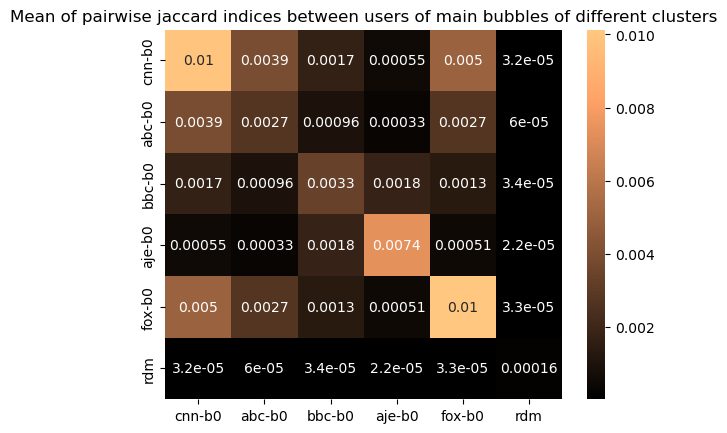

In [33]:
df_mean_jaccard_value_table_main_bubble_of_main_clusters_filename = dataset_root_path + "../generated_data/mean_jaccard_value_table_main_bubbles_main_clusters.csv"

try:
    df_mean_jaccard_value_table_main_bubble_of_main_clusters = pd.read_csv(df_mean_jaccard_value_table_main_bubble_of_main_clusters_filename,
                                                                           index_col=0)
    print("Loaded mean jaccard value table from file")
except FileNotFoundError:
    
    users_in_clusters = {'cnn-b0': pd.Series(extract_user_id(cluster_cnn, 'cnn')[0]),
                         'abc-b0': pd.Series(extract_user_id(cluster_abc, 'abc')[0]),
                         'bbc-b0': pd.Series(extract_user_id(cluster_bbc, 'bbc')[0]),
                         'aje-b0': pd.Series(extract_user_id(cluster_aje, 'aje')[0]),
                         'fox-b0': pd.Series(extract_user_id(cluster_fox, 'fox')[0]),
                         'rdm': control_sample_author_ids.author}

    video_author_matrices = {'cnn-b0': bubbles_video_author_matrices['cnn'][0],
                             'abc-b0': bubbles_video_author_matrices['abc'][0],
                             'bbc-b0': bubbles_video_author_matrices['bbc'][0],
                             'aje-b0': bubbles_video_author_matrices['aje'][0],
                             'fox-b0': bubbles_video_author_matrices['fox'][0],
                             'rdm': video_author_matrix_random_sample}
    
    jaccard_filenames = {name1 + "_" + name2: (dataset_root_path 
                               + f'../generated_data/jaccard_matrix_{name1}_{name2}.npy') 
                         for i, name1 in enumerate(['cnn-b0', 'abc-b0', 'bbc-b0', 'aje-b0', 'fox-b0', 'rdm'])
                         for name2 in ['cnn-b0', 'abc-b0', 'bbc-b0', 'aje-b0', 'fox-b0', 'rdm'][i:]}
    
    df_mean_jaccard_value_table_main_bubbles_main_clusters = dp.get_mean_jaccard_value_table(video_author_matrices,
                                                                                             users_in_clusters,
                                                                                             jaccard_filenames,
                                                                                             df_mean_jaccard_value_table_main_bubble_of_main_clusters_filename)

display(df_mean_jaccard_value_table_main_bubbles_main_clusters)

sns.heatmap(df_mean_jaccard_value_table_main_bubbles_main_clusters, annot=True, cmap='copper')
_ = plt.title("Mean of pairwise jaccard indices between users of main bubbles of different clusters")

As we can see, we have a much stronger difference between the mean jaccard index for users within the same bubble and for users from two different bubble than what we had in the heatmap for the original clusters defined by us. The only exception is again the bubble abc_b0, which again has a larger mean jaccard index when comparing its users to cnn-b0 users, than when comparing abc-b0 users to other users from the same cluster. This is similar to what we saw before in the mean jaccard values for the original clusters.

#### For the top 3 bubbles per cluster

##### Getting the top 3 bubbles per cluster

It would also be interesting to compare the mean jaccard indices for all bubbles found within one cluster. However, as we could see before, there are often very many bubbles found, which mostly contain only a very small number of users. Comparing these would not give much information, as such a small bubble is not representative.

Therefore, we define a way to define the three most important bubbles per original cluster:

- First, we consider the main bubble for each cluster, i.e., the one with the largest number of users,  to be one of the three most important bubbles of this cluster.
- Afterwards, we compare the mean jaccard index for pairs of users from each bubble, for each bubble which has at least 10 users. Then we select the two bubbles with the highest mean jaccard index to be part of our most important bubbles per cluster.

In [22]:
# define filenames where the jaccard matrices will be saved
jaccard_filenames_bubbles = {channel: [dataset_root_path + f"../generated_data/jaccard_matrix_{channel}_b{i}.npy" for i in range(len(bubbles_paths[channel]))] for channel in bubbles_paths.keys()}

# initialize dict of empty lists, where the mean jaccard values of each bubble will be stored
mean_jaccard_values_bubbles = {channel: [] for channel in bubbles_paths.keys()}

# go through all clusters
for channel, channel_bubble_matrices_list in bubbles_video_author_matrices.items():
    # go through all of the bubbles found for this cluster
    for i, matrix in enumerate(channel_bubble_matrices_list):
        filename = jaccard_filenames_bubbles[channel][i]

        # get mean jaccard index for this bubble and write it to the dict
        mean_jacc_index_for_bubble = dp.get_jacc_between_same_cluster_and_get_mean(matrix, filename=filename)
        mean_jaccard_values_bubbles[channel].append(mean_jacc_index_for_bubble)
        print(f"Mean jacc index for channel {channel}, bubble number {i}: {mean_jacc_index_for_bubble}")


    Loaded jaccard index matrix from file
    Calculating mean of jaccard index matrix, excluding the diagonal....
    Done.
Mean jacc index for channel cnn, bubble number 0: 0.009957614354789257
    Loaded jaccard index matrix from file
    Calculating mean of jaccard index matrix, excluding the diagonal....
    Done.
Mean jacc index for channel cnn, bubble number 1: 0.10993573069572449
    Loaded jaccard index matrix from file
    Calculating mean of jaccard index matrix, excluding the diagonal....
    Done.
Mean jacc index for channel cnn, bubble number 2: 0.027064021676778793
    Loaded jaccard index matrix from file
    Calculating mean of jaccard index matrix, excluding the diagonal....
    Done.
Mean jacc index for channel cnn, bubble number 3: 0.042074985802173615
    Loaded jaccard index matrix from file
    Calculating mean of jaccard index matrix, excluding the diagonal....
    Done.
Mean jacc index for channel cnn, bubble number 4: 0.037406861782073975
    Loaded jaccard in

In [29]:
# print the mean jaccard indices for the bubbles, sorted by values, per channel
for channel, mean_jacc_list in mean_jaccard_values_bubbles.items():
    print(channel)
    print(pd.Series(mean_jacc_list).sort_values())

cnn
0    0.009958
2    0.027064
5    0.031368
4    0.037407
3    0.042075
1    0.109936
dtype: float32
abc
0     0.002734
7     0.009910
4     0.010983
12    0.011155
19    0.011183
2     0.011579
9     0.012697
24    0.012972
15    0.013317
5     0.013949
25    0.018152
22    0.018224
23    0.019603
20    0.021681
16    0.024361
21    0.028035
8     0.028141
17    0.034375
1     0.035183
10    0.036413
13    0.037862
14    0.040105
11    0.041026
6     0.042533
18    0.044521
3     0.102670
dtype: float32
bbc
0     0.003303
7     0.009781
9     0.012450
11    0.012648
2     0.014059
1     0.017867
10    0.018285
18    0.019168
17    0.019212
3     0.021384
19    0.022366
15    0.023848
12    0.025704
4     0.029026
13    0.030944
8     0.033637
16    0.038696
6     0.041579
5     0.046843
14    0.061820
dtype: float32
aje
0     0.007354
7     0.019946
1     0.026430
6     0.027197
8     0.027319
4     0.030432
9     0.032296
12    0.038015
10    0.038400
5     0.039185
11    0.043266


Looking at these sorted jaccard indices, and choosing the largest two for each cluster which corresponds to a cluster of size at least 10, we get the following bubbles as top 3 bubbles:

- CNN: bubbles 2 and 5
- ABC: bubbles 3 and 6
- BBC: bubbles 6 and 8
- AJE: bubbles 2 and 3
- FOX: bubbles 1 and 2

Additionally, bubble 0 is included among the top 3 of each cluster, as bubble 0 is always the largest one.

Now that we have the top 3 most important bubbles for each cluster, we generate the mean jaccard index table and heatmap for these bubbles, once per cluster:

##### CNN

Getting Jaccard matrix for cluster cnn-b0 with cluster cnn-b0...
    Loaded jaccard index matrix from file
    Calculating mean of jaccard index matrix, excluding the diagonal....
    Done.
Done.
Getting Jaccard matrix for cluster cnn-b0 with cluster cnn-b2...
    Jaccard index matrix does not exist yet, generating....
    Done.
Done.
Getting Jaccard matrix for cluster cnn-b0 with cluster cnn-b5...
    Jaccard index matrix does not exist yet, generating....
    Done.
Done.
Getting Jaccard matrix for cluster cnn-b0 with cluster rdm...
    Loaded jaccard index matrix from file
Done.
Getting Jaccard matrix for cluster cnn-b2 with cluster cnn-b2...
    Jaccard index matrix does not exist yet, generating....
    Done.
    Calculating mean of jaccard index matrix, excluding the diagonal....
    Done.
Done.
Getting Jaccard matrix for cluster cnn-b2 with cluster cnn-b5...
    Jaccard index matrix does not exist yet, generating....
    Done.
Done.
Getting Jaccard matrix for cluster cnn-b2 with 

cnn-b0    cnn-b2    cnn-b5       rdm
cnn-b0  0.009958  0.003929  0.003532  0.000032
cnn-b2  0.003929  0.027064  0.002494  0.000043
cnn-b5  0.003532  0.002494  0.031368  0.000057
rdm     0.000032  0.000043  0.000057  0.000163

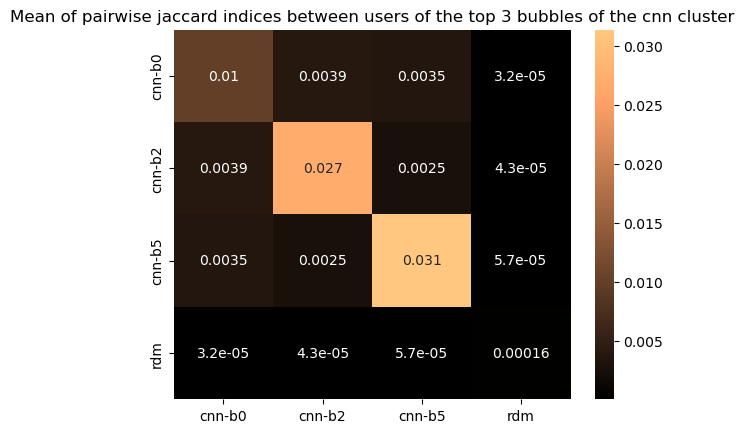

In [29]:
df_mean_jaccard_value_table_top3_bubbles_of_cnn_cluster_filename = dataset_root_path + "../generated_data/mean_jaccard_value_table_top3_bubbles_cnn_cluster.csv"

try:
    df_mean_jaccard_value_table_top3_bubbles_of_cnn_cluster = pd.read_csv(df_mean_jaccard_value_table_top3_bubbles_of_cnn_cluster_filename,
                                                                          index_col=0)
    print("Loaded mean jaccard value table from file")
except FileNotFoundError:
    
    users_in_clusters = {'cnn-b0': pd.Series(extract_user_id(cluster_cnn, 'cnn')[0]),
                         'cnn-b2': pd.Series(extract_user_id(cluster_cnn, 'cnn')[2]),
                         'cnn-b5': pd.Series(extract_user_id(cluster_cnn, 'cnn')[5]),
                         'rdm': control_sample_author_ids.author}

    video_author_matrices = {'cnn-b0': bubbles_video_author_matrices['cnn'][0],
                             'cnn-b2': bubbles_video_author_matrices['cnn'][2],
                             'cnn-b5': bubbles_video_author_matrices['cnn'][5],
                             'rdm': video_author_matrix_random_sample}
    
    jaccard_filenames = {name1 + "_" + name2: (dataset_root_path 
                               + f'../generated_data/jaccard_matrix_{name1}_{name2}.npy') 
                         for i, name1 in enumerate(['cnn-b0', 'cnn-b2', 'cnn-b5', 'rdm'])
                         for name2 in ['cnn-b0', 'cnn-b2', 'cnn-b5', 'rdm'][i:]}
    
    df_mean_jaccard_value_table_top3_bubbles_of_cnn_cluster = dp.get_mean_jaccard_value_table(video_author_matrices,
                                                                                              users_in_clusters,
                                                                                              jaccard_filenames,
                                                                                              df_mean_jaccard_value_table_top3_bubbles_of_cnn_cluster_filename)

display(df_mean_jaccard_value_table_top3_bubbles_of_cnn_cluster)

sns.heatmap(df_mean_jaccard_value_table_top3_bubbles_of_cnn_cluster, annot=True, cmap='copper')
_ = plt.title("Mean of pairwise jaccard indices between users of the top 3 bubbles of the cnn cluster")

##### ABC

Getting Jaccard matrix for cluster abc-b0 with cluster abc-b0...
    Loaded jaccard index matrix from file
    Calculating mean of jaccard index matrix, excluding the diagonal....
    Done.
Done.
Getting Jaccard matrix for cluster abc-b0 with cluster abc-b3...
    Jaccard index matrix does not exist yet, generating....
    Done.
Done.
Getting Jaccard matrix for cluster abc-b0 with cluster abc-b6...
    Jaccard index matrix does not exist yet, generating....
    Done.
Done.
Getting Jaccard matrix for cluster abc-b0 with cluster rdm...
    Loaded jaccard index matrix from file
Done.
Getting Jaccard matrix for cluster abc-b3 with cluster abc-b3...
    Jaccard index matrix does not exist yet, generating....
    Done.
    Calculating mean of jaccard index matrix, excluding the diagonal....
    Done.
Done.
Getting Jaccard matrix for cluster abc-b3 with cluster abc-b6...
    Jaccard index matrix does not exist yet, generating....
    Done.
Done.
Getting Jaccard matrix for cluster abc-b3 with 

abc-b0    abc-b3    abc-b6       rdm
abc-b0  0.002734  0.000928  0.000632  0.000060
abc-b3  0.000928  0.102670  0.000103  0.000019
abc-b6  0.000632  0.000103  0.042533  0.000026
rdm     0.000060  0.000019  0.000026  0.000163

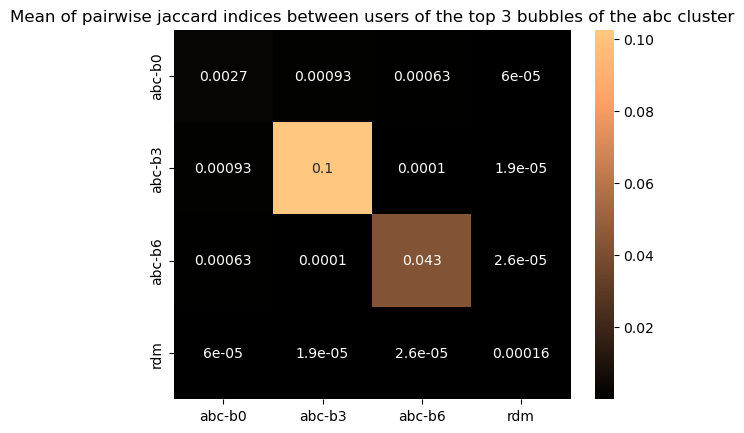

In [30]:
df_mean_jaccard_value_table_top3_bubbles_of_abc_cluster_filename = dataset_root_path + "../generated_data/mean_jaccard_value_table_top3_bubbles_abc_cluster.csv"

try:
    df_mean_jaccard_value_table_top3_bubbles_of_abc_cluster = pd.read_csv(df_mean_jaccard_value_table_top3_bubbles_of_abc_cluster_filename,
                                                                          index_col=0)
    print("Loaded mean jaccard value table from file")
except FileNotFoundError:
    
    users_in_clusters = {'abc-b0': pd.Series(extract_user_id(cluster_abc, 'abc')[0]),
                         'abc-b3': pd.Series(extract_user_id(cluster_abc, 'abc')[3]),
                         'abc-b6': pd.Series(extract_user_id(cluster_abc, 'abc')[6]),
                         'rdm': control_sample_author_ids.author}

    video_author_matrices = {'abc-b0': bubbles_video_author_matrices['abc'][0],
                             'abc-b3': bubbles_video_author_matrices['abc'][3],
                             'abc-b6': bubbles_video_author_matrices['abc'][6],
                             'rdm': video_author_matrix_random_sample}
    
    jaccard_filenames = {name1 + "_" + name2: (dataset_root_path 
                               + f'../generated_data/jaccard_matrix_{name1}_{name2}.npy') 
                         for i, name1 in enumerate(['abc-b0', 'abc-b3', 'abc-b6', 'rdm'])
                         for name2 in ['abc-b0', 'abc-b3', 'abc-b6', 'rdm'][i:]}
    
    df_mean_jaccard_value_table_top3_bubbles_of_abc_cluster = dp.get_mean_jaccard_value_table(video_author_matrices,
                                                                                              users_in_clusters,
                                                                                              jaccard_filenames,
                                                                                              df_mean_jaccard_value_table_top3_bubbles_of_abc_cluster_filename)

display(df_mean_jaccard_value_table_top3_bubbles_of_abc_cluster)

sns.heatmap(df_mean_jaccard_value_table_top3_bubbles_of_abc_cluster, annot=True, cmap='copper')
_ = plt.title("Mean of pairwise jaccard indices between users of the top 3 bubbles of the abc cluster")

##### BBC

Getting Jaccard matrix for cluster bbc-b0 with cluster bbc-b0...
    Loaded jaccard index matrix from file
    Calculating mean of jaccard index matrix, excluding the diagonal....
    Done.
Done.
Getting Jaccard matrix for cluster bbc-b0 with cluster bbc-b6...
    Jaccard index matrix does not exist yet, generating....
    Done.
Done.
Getting Jaccard matrix for cluster bbc-b0 with cluster bbc-b8...
    Jaccard index matrix does not exist yet, generating....
    Done.
Done.
Getting Jaccard matrix for cluster bbc-b0 with cluster rdm...
    Loaded jaccard index matrix from file
Done.
Getting Jaccard matrix for cluster bbc-b6 with cluster bbc-b6...
    Jaccard index matrix does not exist yet, generating....
    Done.
    Calculating mean of jaccard index matrix, excluding the diagonal....
    Done.
Done.
Getting Jaccard matrix for cluster bbc-b6 with cluster bbc-b8...
    Jaccard index matrix does not exist yet, generating....
    Done.
Done.
Getting Jaccard matrix for cluster bbc-b6 with 

bbc-b0    bbc-b6    bbc-b8       rdm
bbc-b0  0.003303  0.000894  0.000070  0.000034
bbc-b6  0.000894  0.041579  0.000303  0.000022
bbc-b8  0.000070  0.000303  0.033637  0.000038
rdm     0.000034  0.000022  0.000038  0.000163

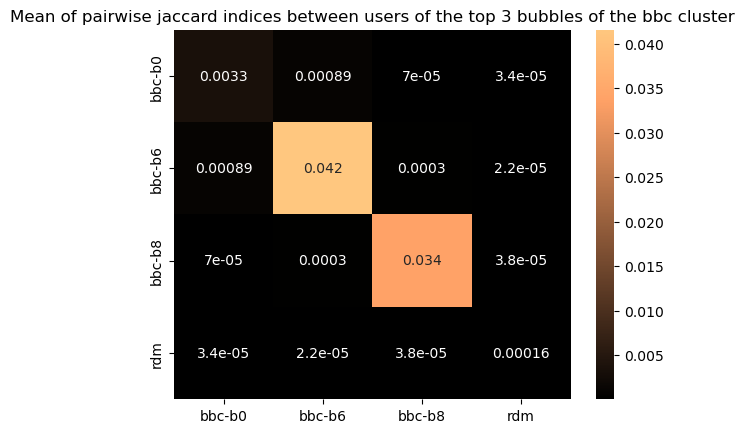

In [31]:
df_mean_jaccard_value_table_top3_bubbles_of_bbc_cluster_filename = dataset_root_path + "../generated_data/mean_jaccard_value_table_top3_bubbles_bbc_cluster.csv"

try:
    df_mean_jaccard_value_table_top3_bubbles_of_bbc_cluster = pd.read_csv(df_mean_jaccard_value_table_top3_bubbles_of_bbc_cluster_filename,
                                                                          index_col=0)
    print("Loaded mean jaccard value table from file")
except FileNotFoundError:
    
    users_in_clusters = {'bbc-b0': pd.Series(extract_user_id(cluster_bbc, 'bbc')[0]),
                         'bbc-b6': pd.Series(extract_user_id(cluster_bbc, 'bbc')[6]),
                         'bbc-b8': pd.Series(extract_user_id(cluster_bbc, 'bbc')[8]),
                         'rdm': control_sample_author_ids.author}

    video_author_matrices = {'bbc-b0': bubbles_video_author_matrices['bbc'][0],
                             'bbc-b6': bubbles_video_author_matrices['bbc'][6],
                             'bbc-b8': bubbles_video_author_matrices['bbc'][8],
                             'rdm': video_author_matrix_random_sample}
    
    jaccard_filenames = {name1 + "_" + name2: (dataset_root_path 
                               + f'../generated_data/jaccard_matrix_{name1}_{name2}.npy') 
                         for i, name1 in enumerate(['bbc-b0', 'bbc-b6', 'bbc-b8', 'rdm'])
                         for name2 in ['bbc-b0', 'bbc-b6', 'bbc-b8', 'rdm'][i:]}
    
    df_mean_jaccard_value_table_top3_bubbles_of_bbc_cluster = dp.get_mean_jaccard_value_table(video_author_matrices,
                                                                                              users_in_clusters,
                                                                                              jaccard_filenames,
                                                                                              df_mean_jaccard_value_table_top3_bubbles_of_bbc_cluster_filename)

display(df_mean_jaccard_value_table_top3_bubbles_of_bbc_cluster)

sns.heatmap(df_mean_jaccard_value_table_top3_bubbles_of_bbc_cluster, annot=True, cmap='copper')
_ = plt.title("Mean of pairwise jaccard indices between users of the top 3 bubbles of the bbc cluster")

##### AJE

Getting Jaccard matrix for cluster aje-b0 with cluster aje-b0...
    Loaded jaccard index matrix from file
    Calculating mean of jaccard index matrix, excluding the diagonal....
    Done.
Done.
Getting Jaccard matrix for cluster aje-b0 with cluster aje-b2...
    Jaccard index matrix does not exist yet, generating....
    Done.
Done.
Getting Jaccard matrix for cluster aje-b0 with cluster aje-b3...
    Jaccard index matrix does not exist yet, generating....
    Done.
Done.
Getting Jaccard matrix for cluster aje-b0 with cluster rdm...
    Loaded jaccard index matrix from file
Done.
Getting Jaccard matrix for cluster aje-b2 with cluster aje-b2...
    Jaccard index matrix does not exist yet, generating....
    Done.
    Calculating mean of jaccard index matrix, excluding the diagonal....
    Done.
Done.
Getting Jaccard matrix for cluster aje-b2 with cluster aje-b3...
    Jaccard index matrix does not exist yet, generating....
    Done.
Done.
Getting Jaccard matrix for cluster aje-b2 with 

aje-b0    aje-b2    aje-b3       rdm
aje-b0  0.007354  0.000238  0.000579  0.000022
aje-b2  0.000238  0.090243  0.000478  0.000018
aje-b3  0.000579  0.000478  0.080618  0.000026
rdm     0.000022  0.000018  0.000026  0.000163

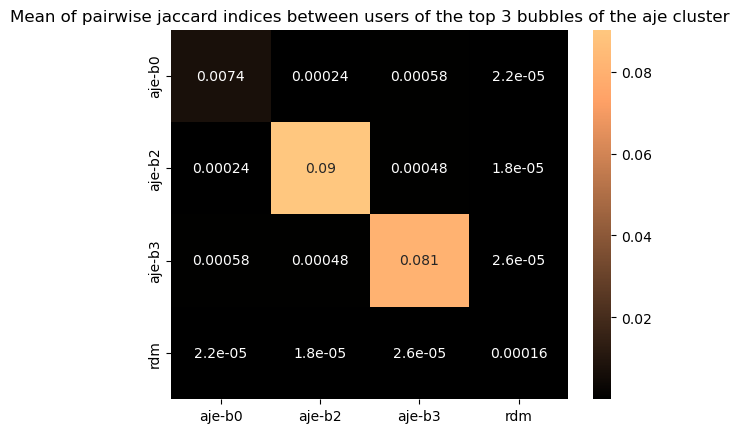

In [32]:
df_mean_jaccard_value_table_top3_bubbles_of_aje_cluster_filename = dataset_root_path + "../generated_data/mean_jaccard_value_table_top3_bubbles_aje_cluster.csv"

try:
    df_mean_jaccard_value_table_top3_bubbles_of_aje_cluster = pd.read_csv(df_mean_jaccard_value_table_top3_bubbles_of_aje_cluster_filename,
                                                                          index_col=0)
    print("Loaded mean jaccard value table from file")
except FileNotFoundError:
    
    users_in_clusters = {'aje-b0': pd.Series(extract_user_id(cluster_aje, 'aje')[0]),
                         'aje-b2': pd.Series(extract_user_id(cluster_aje, 'aje')[2]),
                         'aje-b3': pd.Series(extract_user_id(cluster_aje, 'aje')[3]),
                         'rdm': control_sample_author_ids.author}

    video_author_matrices = {'aje-b0': bubbles_video_author_matrices['aje'][0],
                             'aje-b2': bubbles_video_author_matrices['aje'][2],
                             'aje-b3': bubbles_video_author_matrices['aje'][3],
                             'rdm': video_author_matrix_random_sample}
    
    jaccard_filenames = {name1 + "_" + name2: (dataset_root_path 
                               + f'../generated_data/jaccard_matrix_{name1}_{name2}.npy') 
                         for i, name1 in enumerate(['aje-b0', 'aje-b2', 'aje-b3', 'rdm'])
                         for name2 in ['aje-b0', 'aje-b2', 'aje-b3', 'rdm'][i:]}
    
    df_mean_jaccard_value_table_top3_bubbles_of_aje_cluster = dp.get_mean_jaccard_value_table(video_author_matrices,
                                                                                              users_in_clusters,
                                                                                              jaccard_filenames,
                                                                                              df_mean_jaccard_value_table_top3_bubbles_of_aje_cluster_filename)

display(df_mean_jaccard_value_table_top3_bubbles_of_aje_cluster)

sns.heatmap(df_mean_jaccard_value_table_top3_bubbles_of_aje_cluster, annot=True, cmap='copper')
_ = plt.title("Mean of pairwise jaccard indices between users of the top 3 bubbles of the aje cluster")

##### Fox

Getting Jaccard matrix for cluster fox-b0 with cluster fox-b0...
    Loaded jaccard index matrix from file
    Calculating mean of jaccard index matrix, excluding the diagonal....
    Done.
Done.
Getting Jaccard matrix for cluster fox-b0 with cluster fox-b1...
    Jaccard index matrix does not exist yet, generating....
    Done.
Done.
Getting Jaccard matrix for cluster fox-b0 with cluster fox-b2...
    Jaccard index matrix does not exist yet, generating....
    Done.
Done.
Getting Jaccard matrix for cluster fox-b0 with cluster rdm...
    Loaded jaccard index matrix from file
Done.
Getting Jaccard matrix for cluster fox-b1 with cluster fox-b1...
    Jaccard index matrix does not exist yet, generating....
    Done.
    Calculating mean of jaccard index matrix, excluding the diagonal....
    Done.
Done.
Getting Jaccard matrix for cluster fox-b1 with cluster fox-b2...
    Jaccard index matrix does not exist yet, generating....
    Done.
Done.
Getting Jaccard matrix for cluster fox-b1 with 

fox-b0    fox-b1    fox-b2       rdm
fox-b0  0.010132  0.000368  0.001035  0.000033
fox-b1  0.000368  0.040106  0.012642  0.000006
fox-b2  0.001035  0.012642  0.025181  0.000010
rdm     0.000033  0.000006  0.000010  0.000163

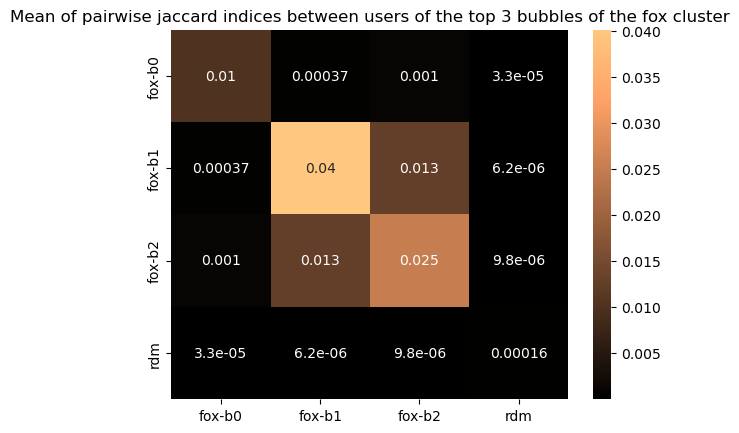

In [33]:
df_mean_jaccard_value_table_top3_bubbles_of_fox_cluster_filename = dataset_root_path + "../generated_data/mean_jaccard_value_table_top3_bubbles_fox_cluster.csv"

try:
    df_mean_jaccard_value_table_top3_bubbles_of_fox_cluster = pd.read_csv(df_mean_jaccard_value_table_top3_bubbles_of_fox_cluster_filename,
                                                                          index_col=0)
    print("Loaded mean jaccard value table from file")
except FileNotFoundError:
    
    users_in_clusters = {'fox-b0': pd.Series(extract_user_id(cluster_fox, 'fox')[0]),
                         'fox-b1': pd.Series(extract_user_id(cluster_fox, 'fox')[1]),
                         'fox-b2': pd.Series(extract_user_id(cluster_fox, 'fox')[2]),
                         'rdm': control_sample_author_ids.author}

    video_author_matrices = {'fox-b0': bubbles_video_author_matrices['fox'][0],
                             'fox-b1': bubbles_video_author_matrices['fox'][1],
                             'fox-b2': bubbles_video_author_matrices['fox'][2],
                             'rdm': video_author_matrix_random_sample}
    
    jaccard_filenames = {name1 + "_" + name2: (dataset_root_path 
                               + f'../generated_data/jaccard_matrix_{name1}_{name2}.npy') 
                         for i, name1 in enumerate(['fox-b0', 'fox-b1', 'fox-b2', 'rdm'])
                         for name2 in ['fox-b0', 'fox-b1', 'fox-b2', 'rdm'][i:]}
    
    df_mean_jaccard_value_table_top3_bubbles_of_fox_cluster = dp.get_mean_jaccard_value_table(video_author_matrices,
                                                                                              users_in_clusters,
                                                                                              jaccard_filenames,
                                                                                              df_mean_jaccard_value_table_top3_bubbles_of_fox_cluster_filename)

display(df_mean_jaccard_value_table_top3_bubbles_of_fox_cluster)

sns.heatmap(df_mean_jaccard_value_table_top3_bubbles_of_fox_cluster, annot=True, cmap='copper')
_ = plt.title("Mean of pairwise jaccard indices between users of the top 3 bubbles of the fox cluster")

Comparing the average jaccard index , which is indicative of the pairwise overlapping, between the bubbles and the one within the bubbles for each channels, we  see that for each the overlap is quite low as expected. Furthermore as expected the users overlap between the bubbles in a channel is much lower (factor of 10) than the overlap of users within a bubble. This shows that the bubbles are correctly clustered and doesnt overlap each other in a channel. Users interested by similar videos dont really mix with users in other clusters having other interests. 

# Part 4: Peering into the bubbles 

## Exploring content and source diversity

First let's load what we need.

In [4]:
#loading videos_new_pol
video_filepath = dataset_root_path + "../generated_data/videos_in_news_pol.csv"
videos_new_pol = pd.read_csv(video_filepath)

In [14]:
# Bubbles
bubbles_channels = {
    'CNN': video_author_matrix_cnn_cluster,
    'BBC': video_author_matrix_bbc_cluster,
    'ABC': video_author_matrix_abc_cluster,
    'AJE': video_author_matrix_aje_cluster,
    'FOX': video_author_matrix_fox_cluster
}

main_channel_ids = {
    'CNN': channel_id_cnn,
    'BBC': channel_id_bbc,
    'AJE': channel_id_aje,
    'FOX': channel_id_fox,
    'ABC': channel_id_abc
}

### Diversification of sources 

 What are the main videos our bubbles look at ? Are they related to their channel for the big bubbles ? 

#### Pie chart of media repartition for each cluster

We want to verify if the commenters in our clusters actually diversify their sources. That's why we are plotting a pie chart for each cluster, showing the repartition of commented videos by the cluster's members between the several News and Politics channels. We can set a threshold if we want to take into account videos that have been commented by a certain percentage of the cluster e.g. set the threshold at 1% if you want to see the repartition of videos that have been commented by at least 1% of the cluster's members.

679447 out of 679447 total viceos commented are taken into account in this pie chart


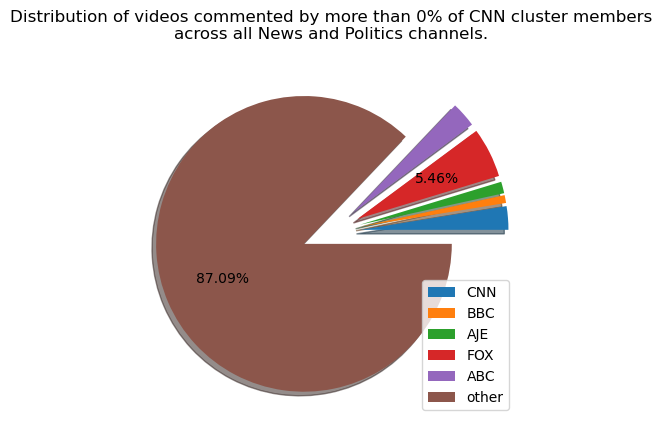

679921 out of 679921 total viceos commented are taken into account in this pie chart


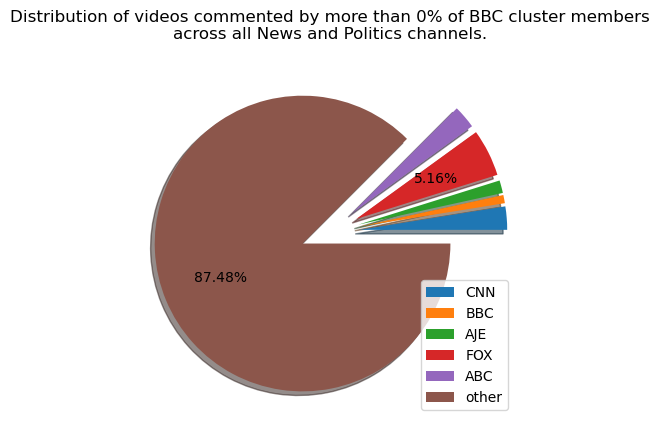

737843 out of 737843 total viceos commented are taken into account in this pie chart


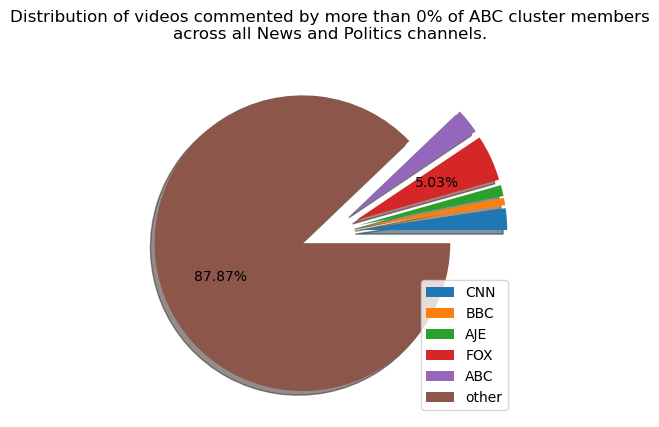

589119 out of 589119 total viceos commented are taken into account in this pie chart


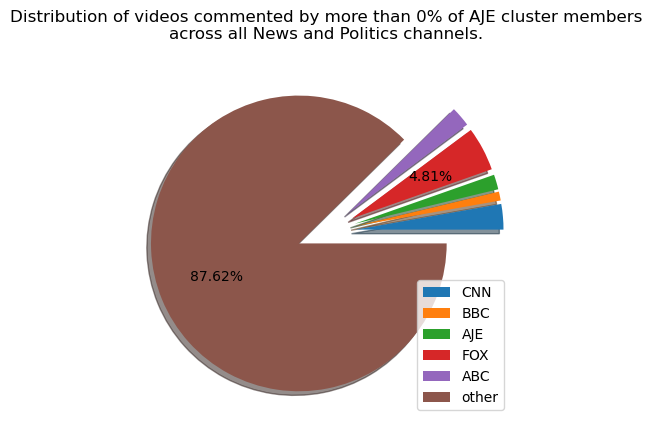

654572 out of 654572 total viceos commented are taken into account in this pie chart


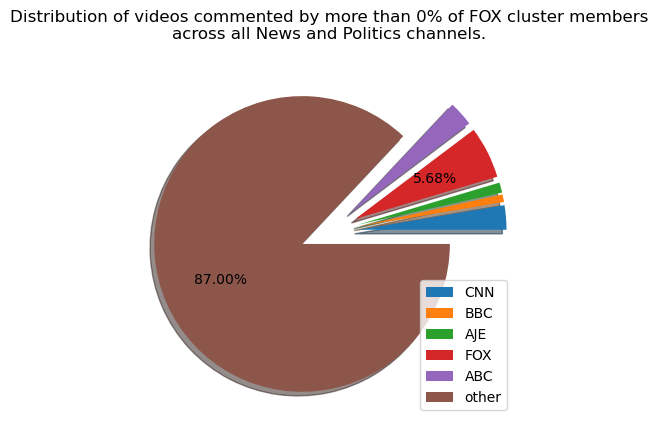

13504 out of 679447 total viceos commented are taken into account in this pie chart


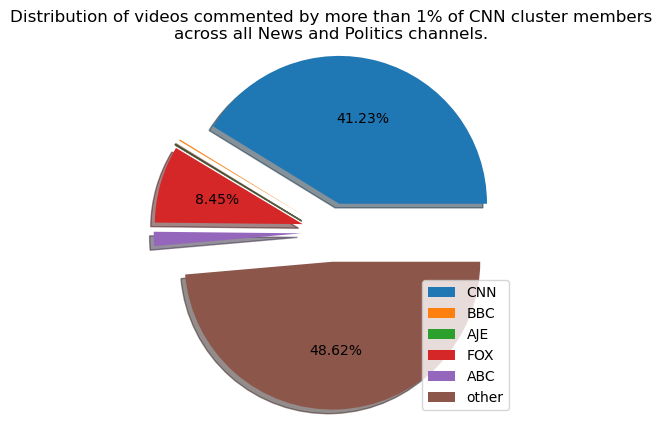

3559 out of 679921 total viceos commented are taken into account in this pie chart


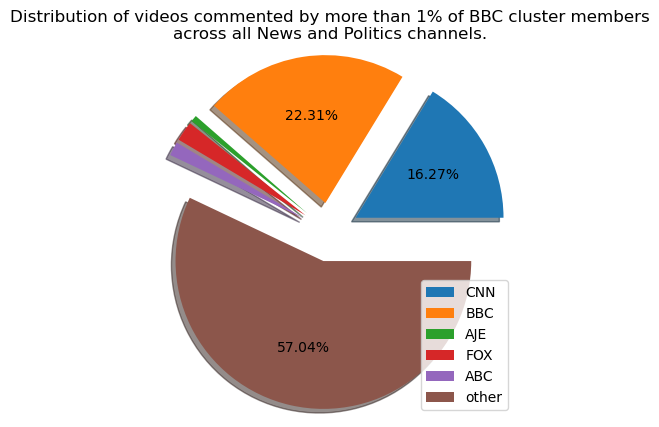

4518 out of 737843 total viceos commented are taken into account in this pie chart


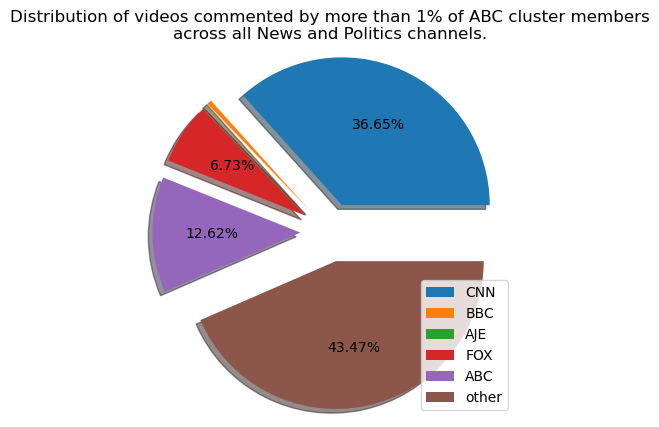

4770 out of 589119 total viceos commented are taken into account in this pie chart


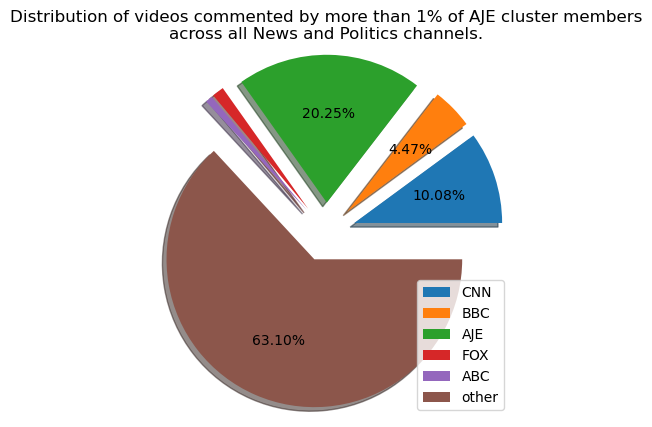

15198 out of 654572 total viceos commented are taken into account in this pie chart


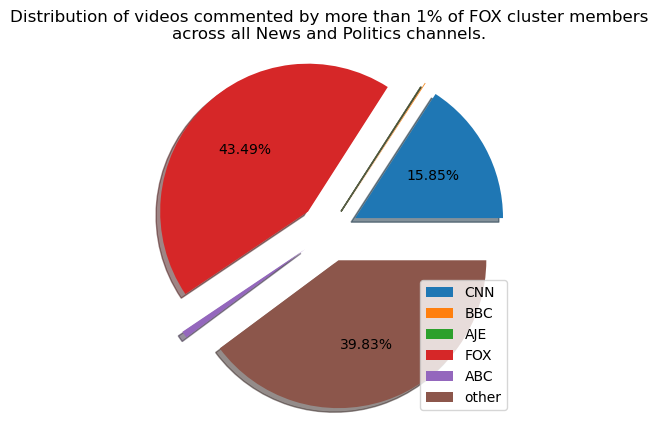

In [20]:
#plotting a pie chart for each cluster of the repartition of commented videos depending on which channel they are from
dp.pie_chart_repartition_media(bubbles_channels , main_channel_ids, videos_new_pol) #no threshold
dp.pie_chart_repartition_media(bubbles_channels , main_channel_ids, videos_new_pol, 0.01) #thershold of 1%

### Content pattern

 But what do the videos talk about ? Can we find the most popular subject based on the title?

#### Looking at cluster bubbles : CNN, ABC, BBC, FOX, AJE.

##### 1. Country leader


As we are looking at News & Politics category, one think that obviously crossed our mind was to look at the most popular country leader. We've handpicked 5 leaders : Trump, Obama, Cameron, Al Thani and finally Poutine.

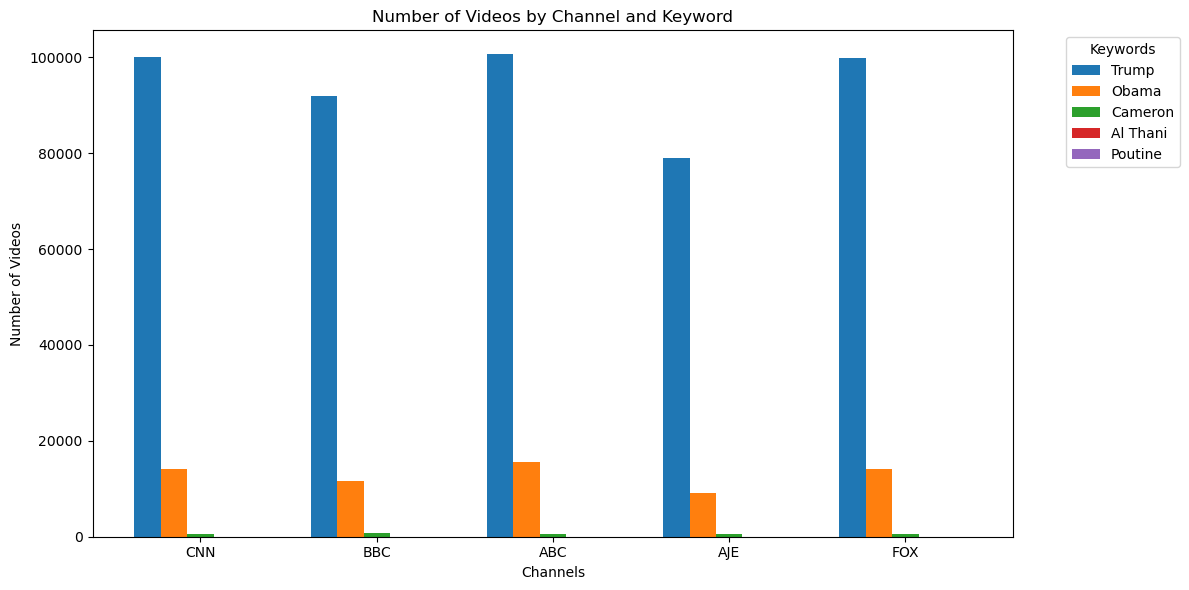

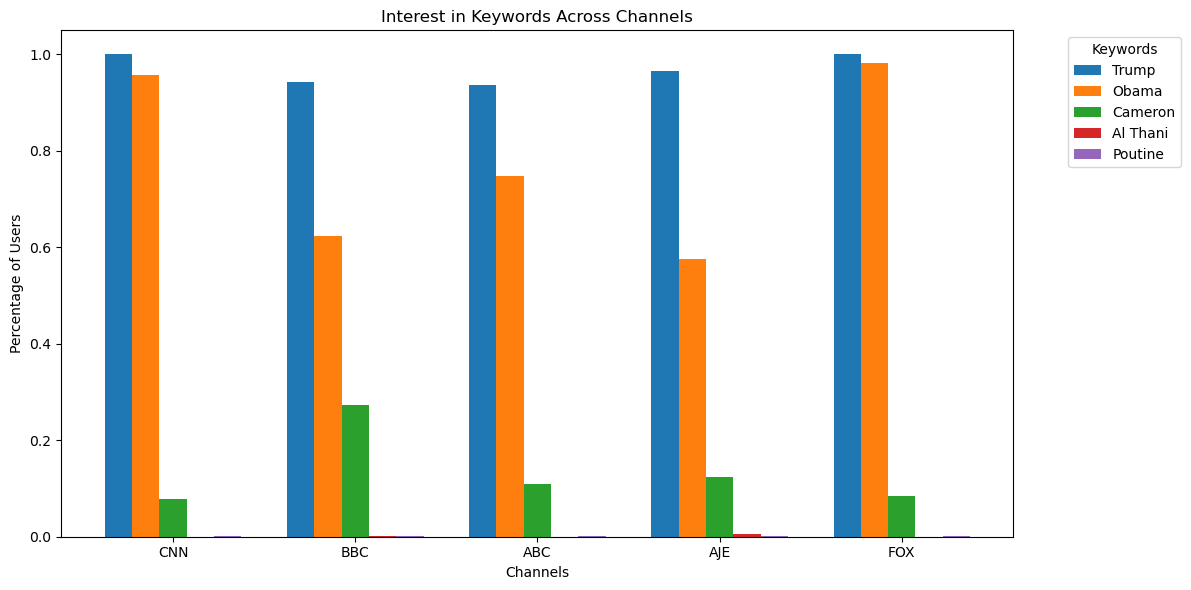

In [114]:
#Popularity 
keywords = ['Trump', 'Obama', 'Cameron', 'Al Thani', 'Poutine']
dp.process_and_plot_word_interest(bubbles_channels, videos_new_pol, video_ids_news_pol_int_mapping, keywords)


Trump seems to be the most popular! He is cited in the title of more than 100000 videos for the different clusters. That’s a lot ! Furthermore, almost all the users in each cluster have commented on videos with his name… This doesn’t mean that they are fans. They could also be haters. On the other hand, Al Thani and Putin don’t seem to be very popular. Almost no videos featuring them were retrieved. Nevertheless, a small portion of Al Jazeera’s users (AJE) seems to be interested in Al Thani! That makes sense, as he is the Emir of Qatar, and AJE is a Middle Eastern news channel.

##### 2. Interest in subject

What about the different subject in the title of the videos ? Let's look at acual subject : Climate, education, gender, religion and abortion

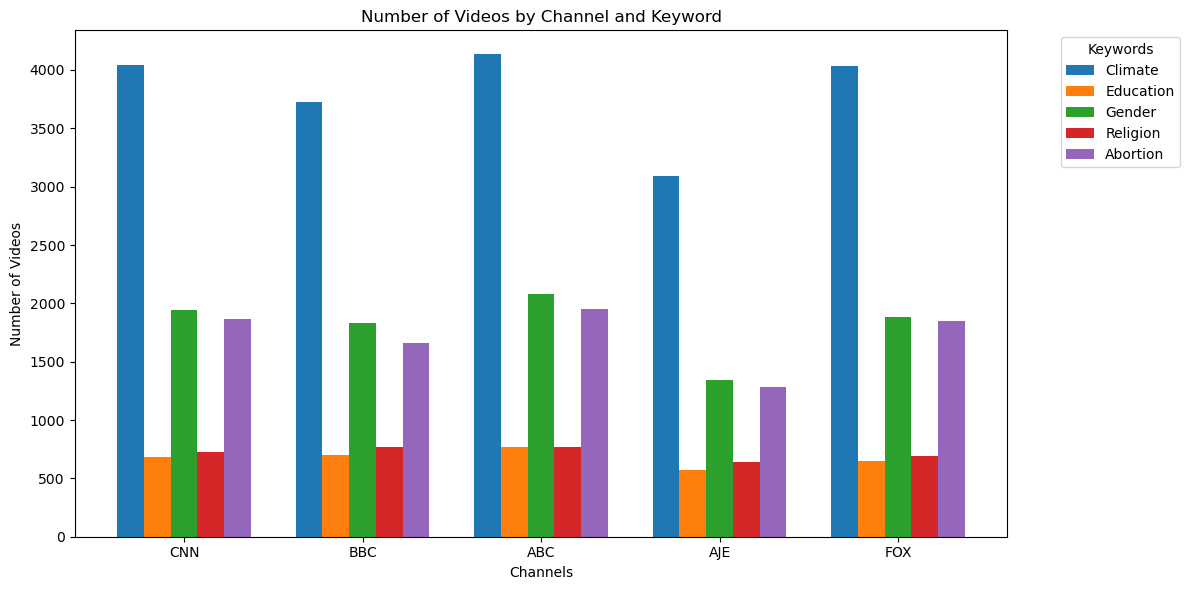

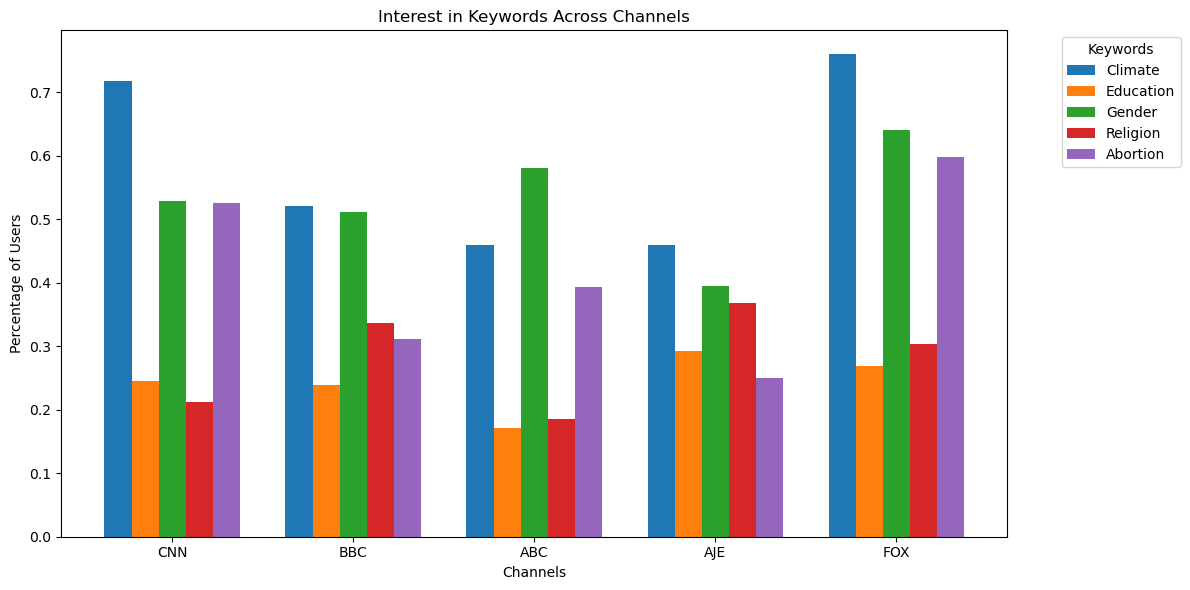

In [115]:
#Category
keywords = ['Climate', 'Education', 'Gender', 'Religion', 'Abortion']
dp.process_and_plot_word_interest(bubbles_channels, videos_new_pol, video_ids_news_pol_int_mapping, keywords)


##### Looking at bubbles within a cluster

What about within the channel bubbles ? Can we generalize this to all the users or just to specific ones? Let’s look at the top 3 bubbles having the highest number of users engaging with the same videos and having at least 10 users within the channels.

In [117]:
#CNN

bubbles_cnn = {

    'bubble 1': bubbles_video_author_matrices['cnn'][0],
    'bubble 2':  bubbles_video_author_matrices['cnn'][2],
    'bubble 3':  bubbles_video_author_matrices['cnn'][5],
}

#ABC

bubbles_abc = {

    'bubble 1': bubbles_video_author_matrices['abc'][0],
    'bubble 2':  bubbles_video_author_matrices['abc'][3],
    'bubble 3':  bubbles_video_author_matrices['abc'][6],
}

#BBC

bubbles_bbc = {

    'bubble 1': bubbles_video_author_matrices['bbc'][0],
    'bubble 2':  bubbles_video_author_matrices['bbc'][6],
    'bubble 3':  bubbles_video_author_matrices['bbc'][8],
}

#AJE

bubbles_aje = {

    'bubble 1': bubbles_video_author_matrices['aje'][0],
    'bubble 2':  bubbles_video_author_matrices['aje'][2],
    'bubble 3':  bubbles_video_author_matrices['aje'][3],
}

#Fox

bubbles_fox = {

    'bubble 1': bubbles_video_author_matrices['fox'][0],
    'bubble 2':  bubbles_video_author_matrices['fox'][1],
    'bubble 3':  bubbles_video_author_matrices['fox'][2],
}


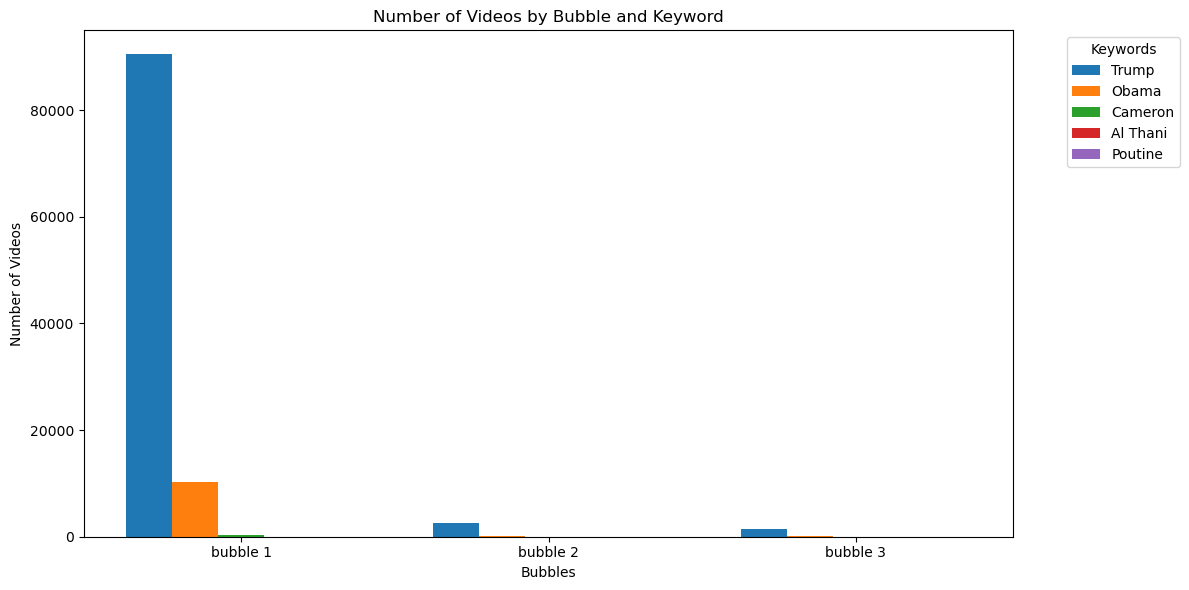

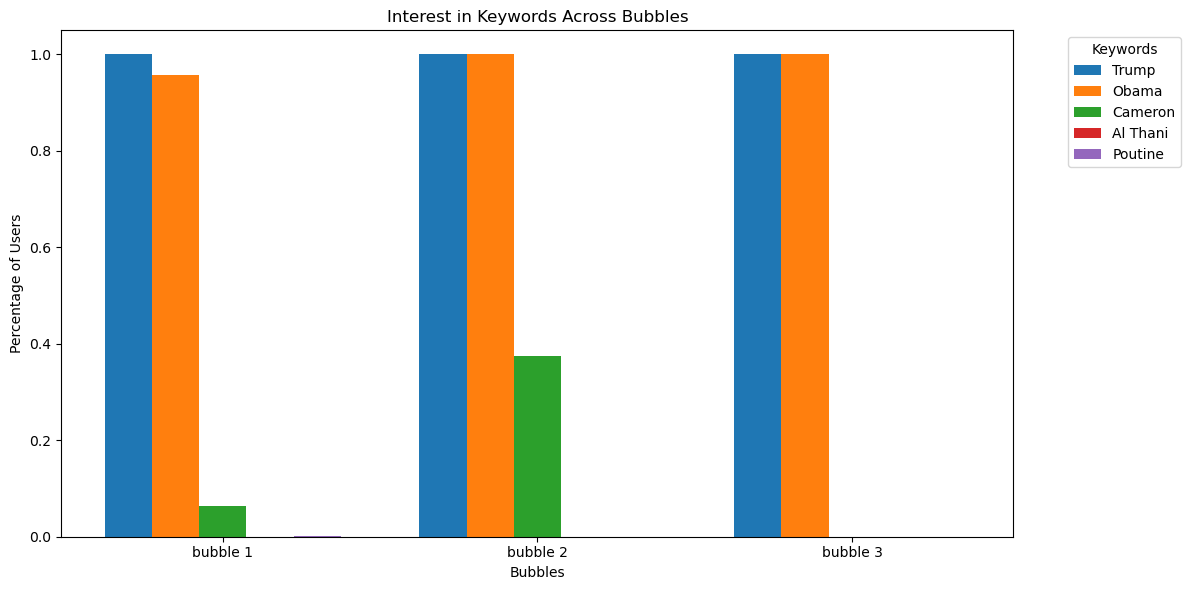

In [128]:
#Popularity 

#CNN
keywords = ['Trump', 'Obama', 'Cameron', 'Al Thani', 'Poutine']
dp.process_and_plot_word_interest(bubbles_cnn, videos_new_pol, video_ids_news_pol_int_mapping, keywords)


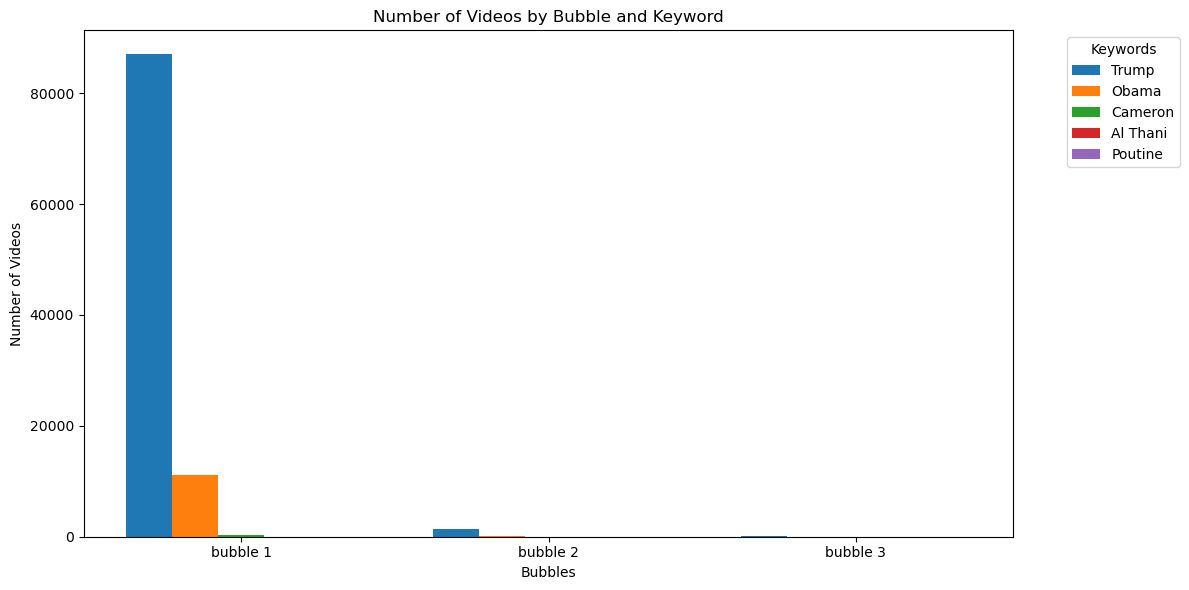

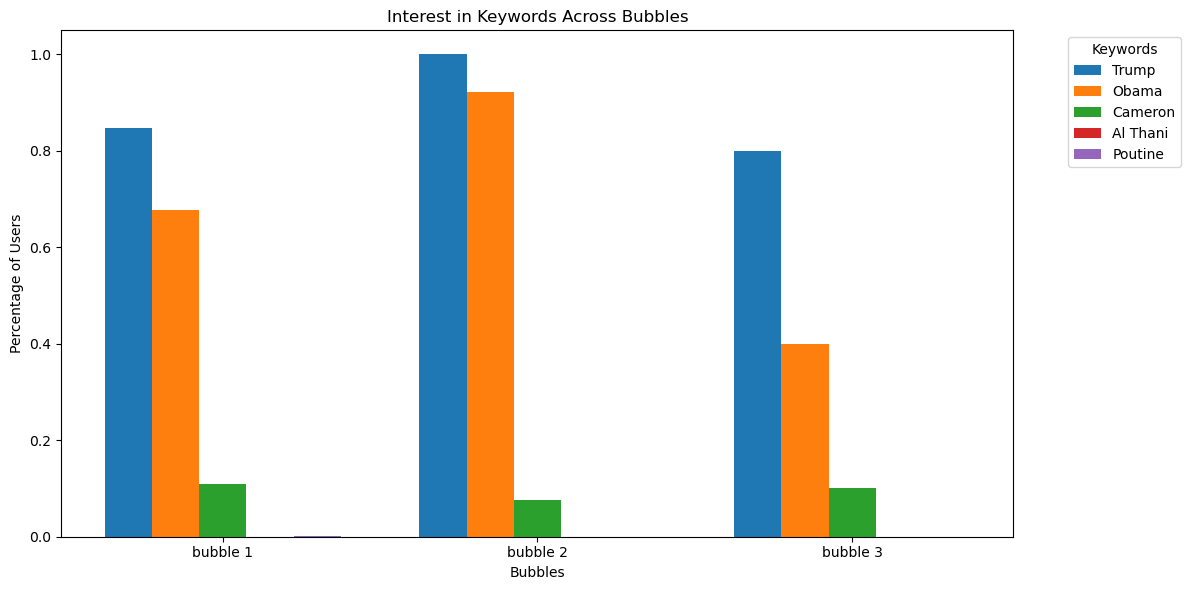

In [129]:
#ABC
keywords = ['Trump', 'Obama', 'Cameron', 'Al Thani', 'Poutine']
dp.process_and_plot_word_interest(bubbles_abc, videos_new_pol, video_ids_news_pol_int_mapping, keywords)


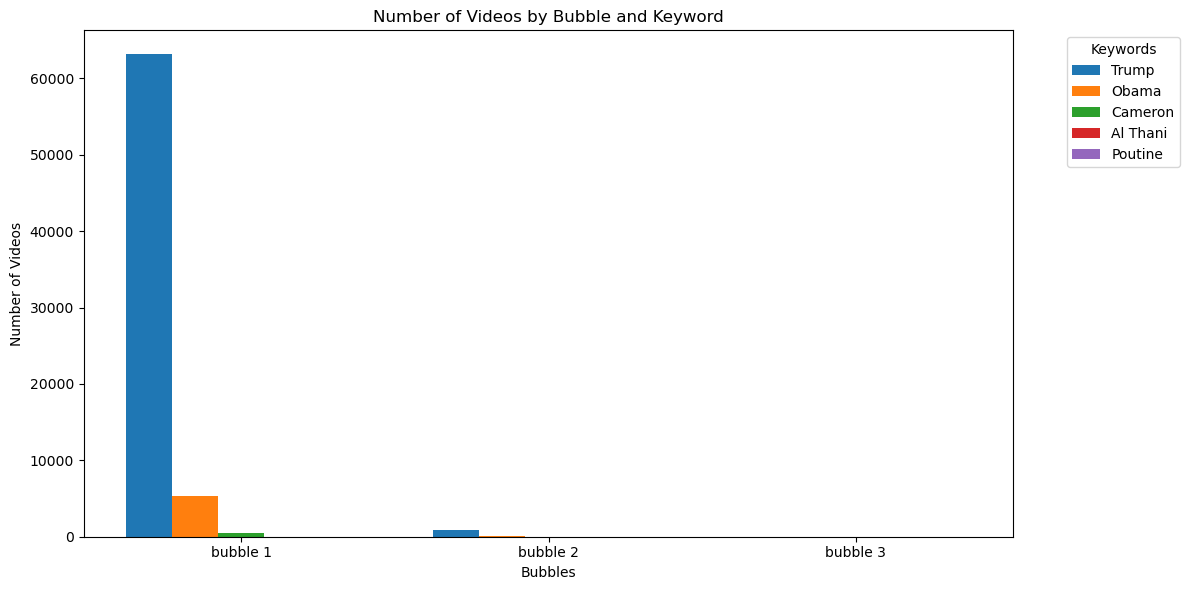

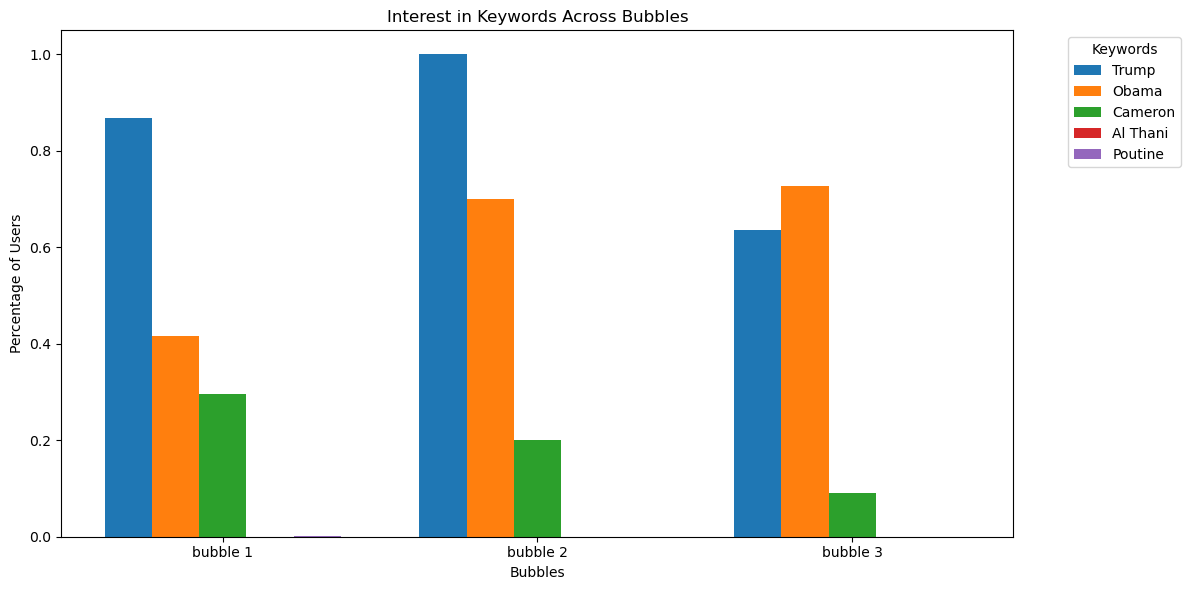

In [130]:
#BBC
keywords = ['Trump', 'Obama', 'Cameron', 'Al Thani', 'Poutine']
dp.process_and_plot_word_interest(bubbles_bbc, videos_new_pol, video_ids_news_pol_int_mapping, keywords)


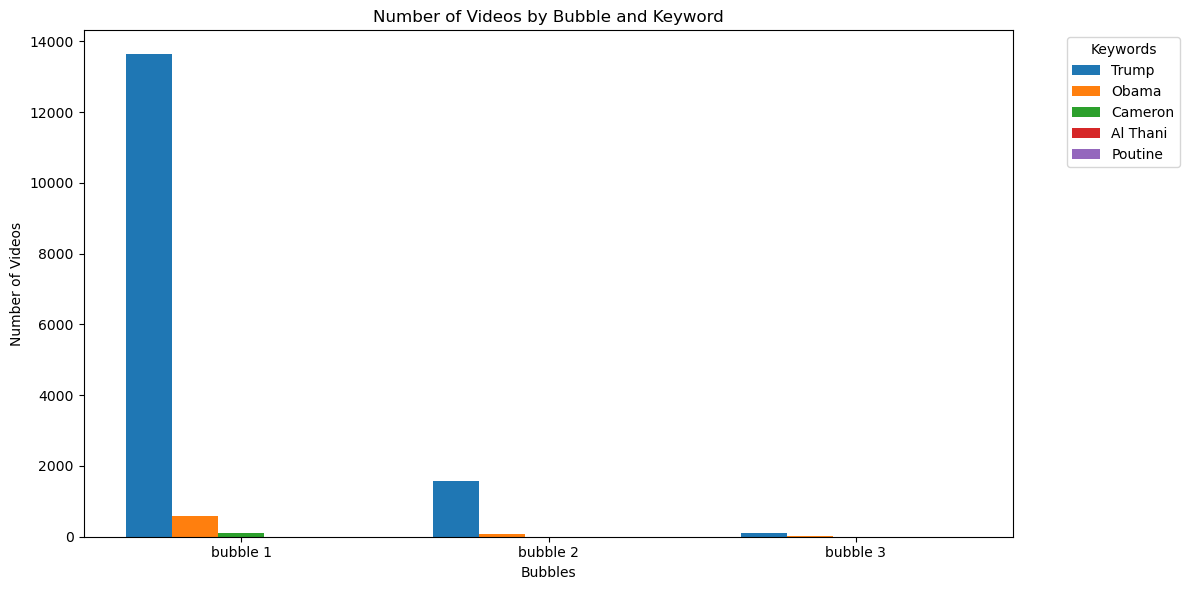

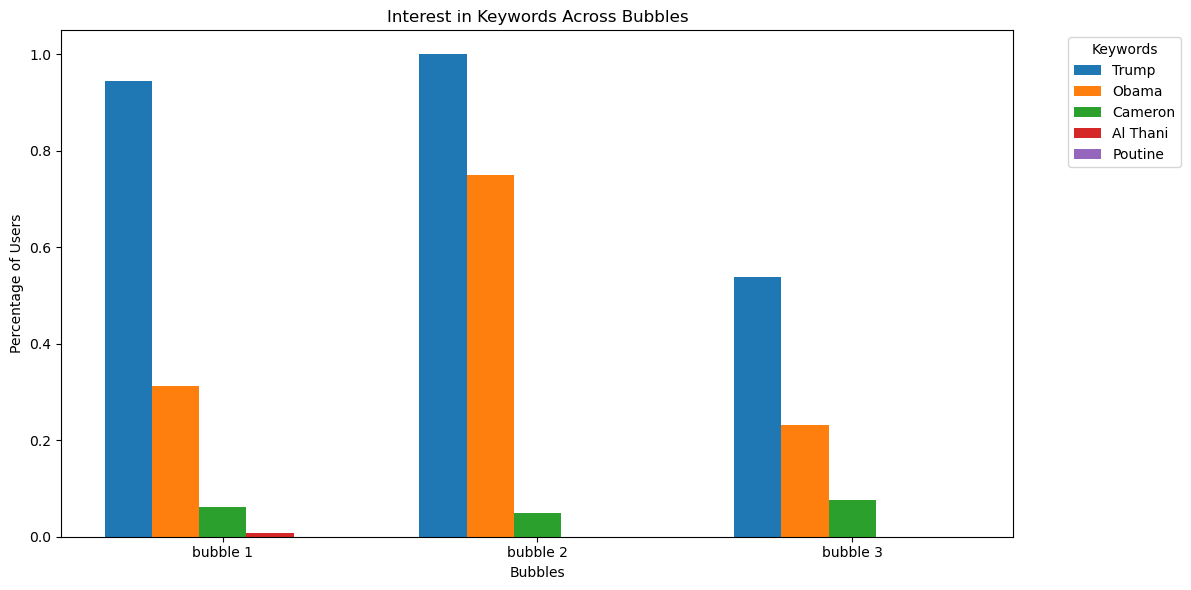

In [131]:
#AJE
keywords = ['Trump', 'Obama', 'Cameron', 'Al Thani', 'Poutine']
dp.process_and_plot_word_interest(bubbles_aje, videos_new_pol, video_ids_news_pol_int_mapping, keywords)


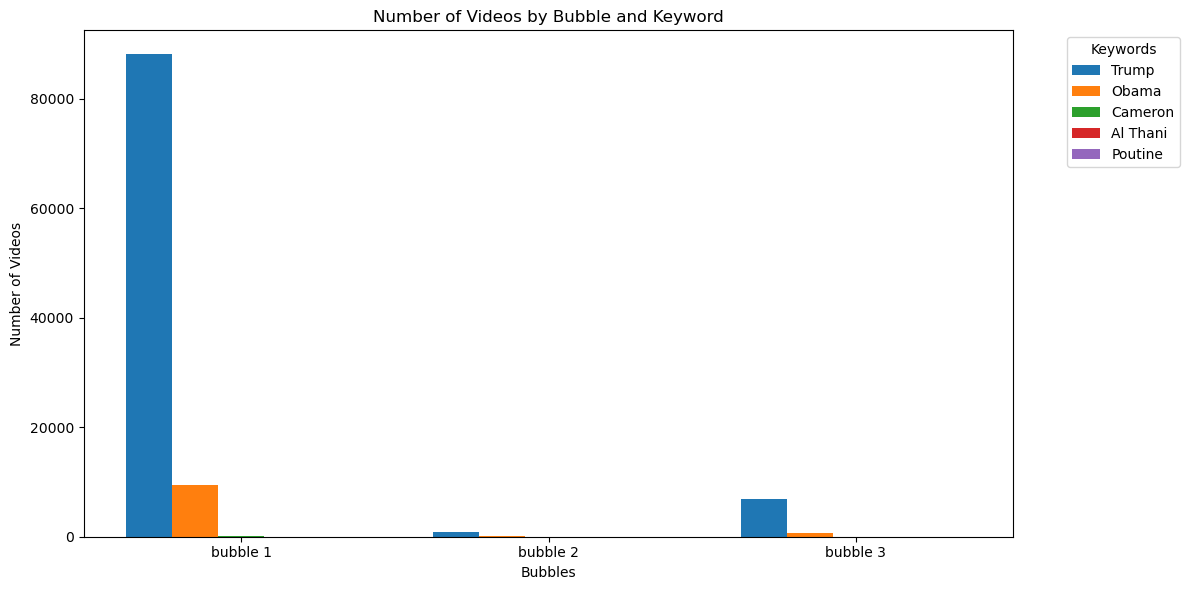

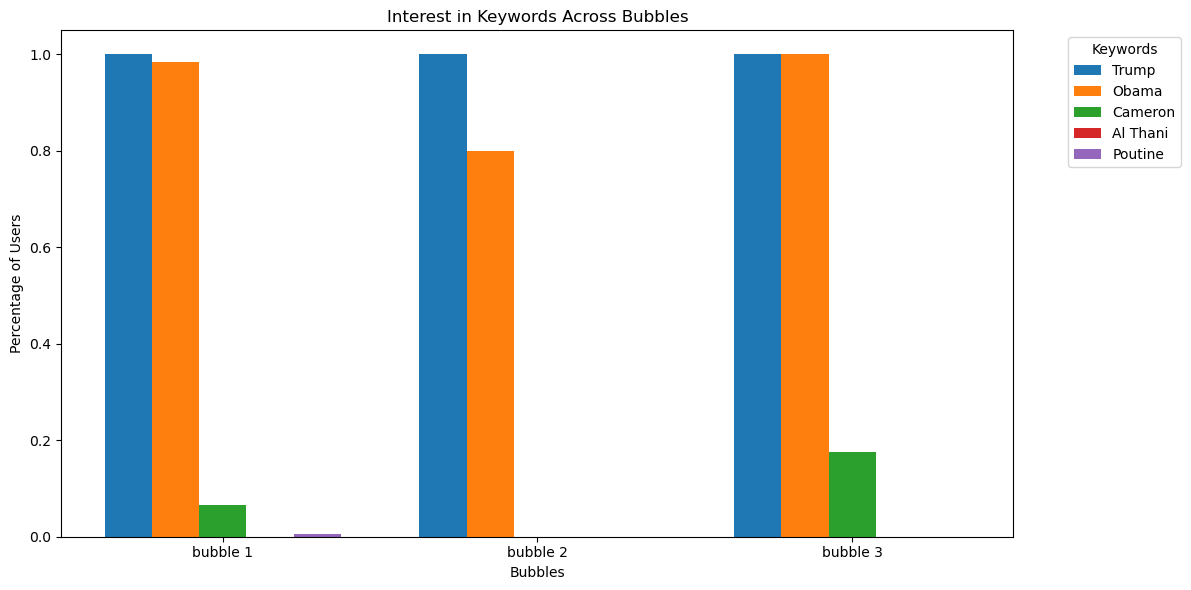

In [132]:
#Fox
keywords = ['Trump', 'Obama', 'Cameron', 'Al Thani', 'Poutine']
dp.process_and_plot_word_interest(bubbles_fox, videos_new_pol, video_ids_news_pol_int_mapping, keywords)


### What about the different categories ?

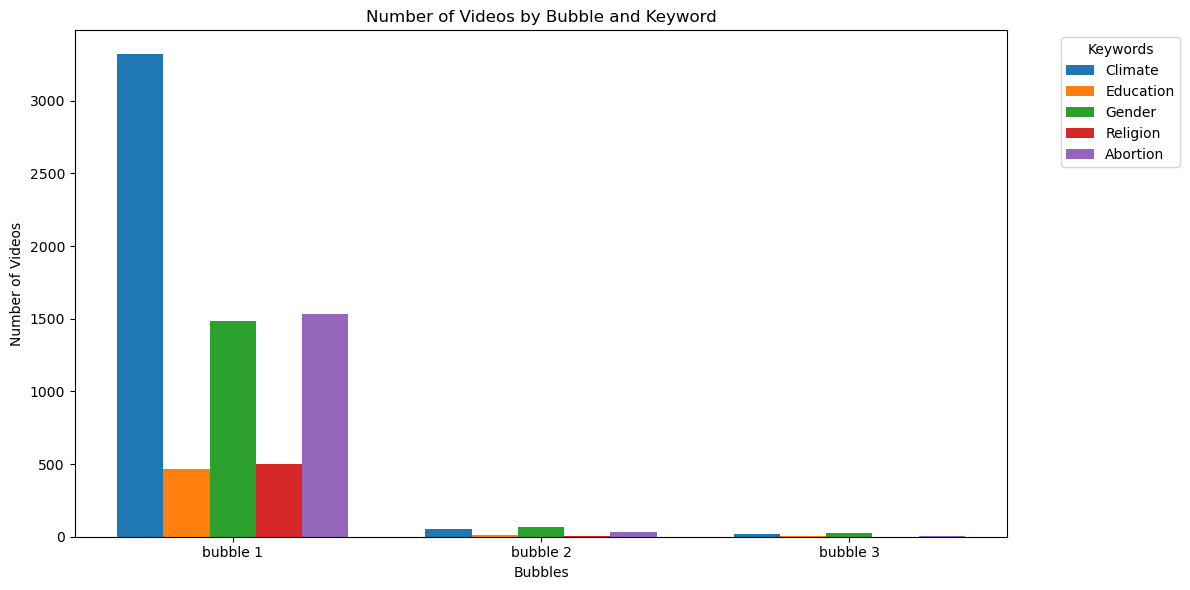

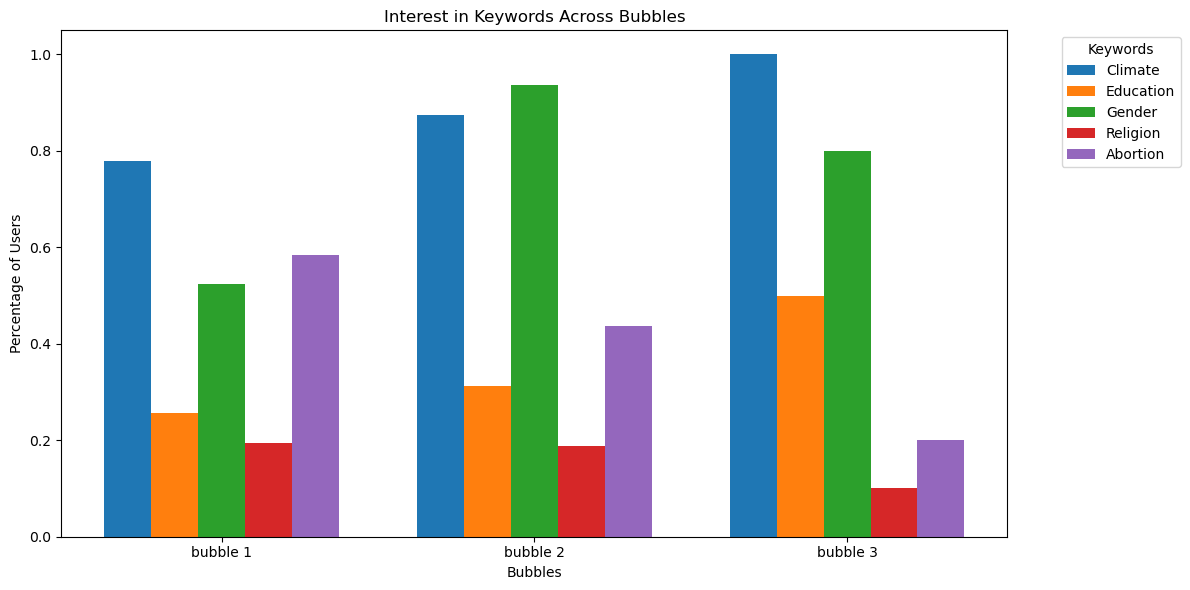

In [133]:
#Popularity 

#CNN
keywords = ['Climate', 'Education', 'Gender', 'Religion', 'Abortion']
dp.process_and_plot_word_interest(bubbles_cnn, videos_new_pol, video_ids_news_pol_int_mapping, keywords)


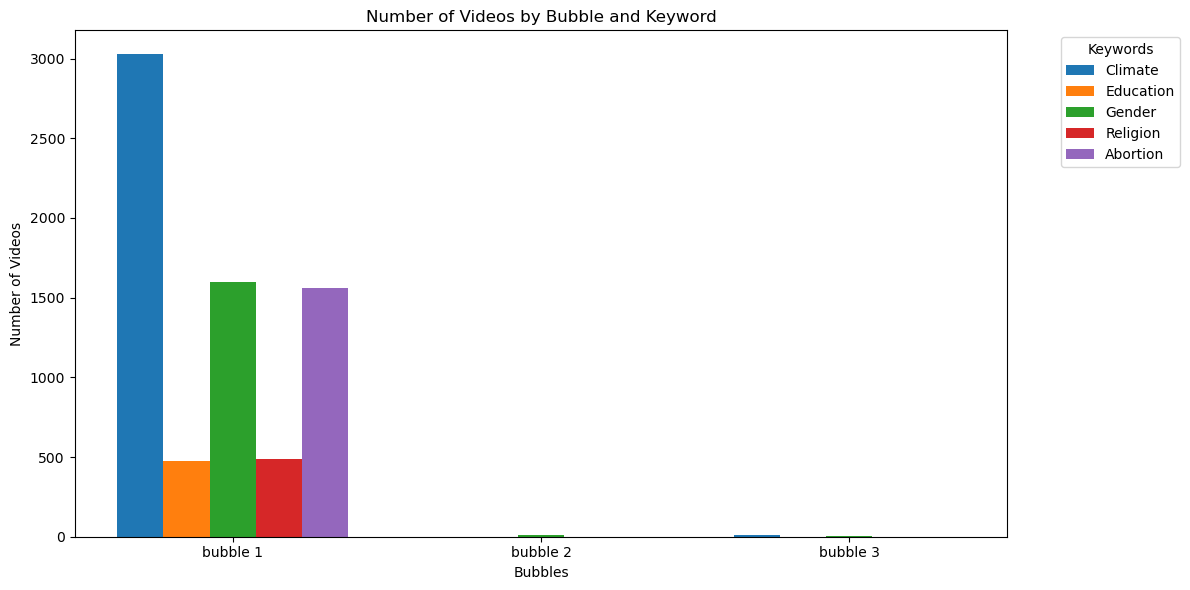

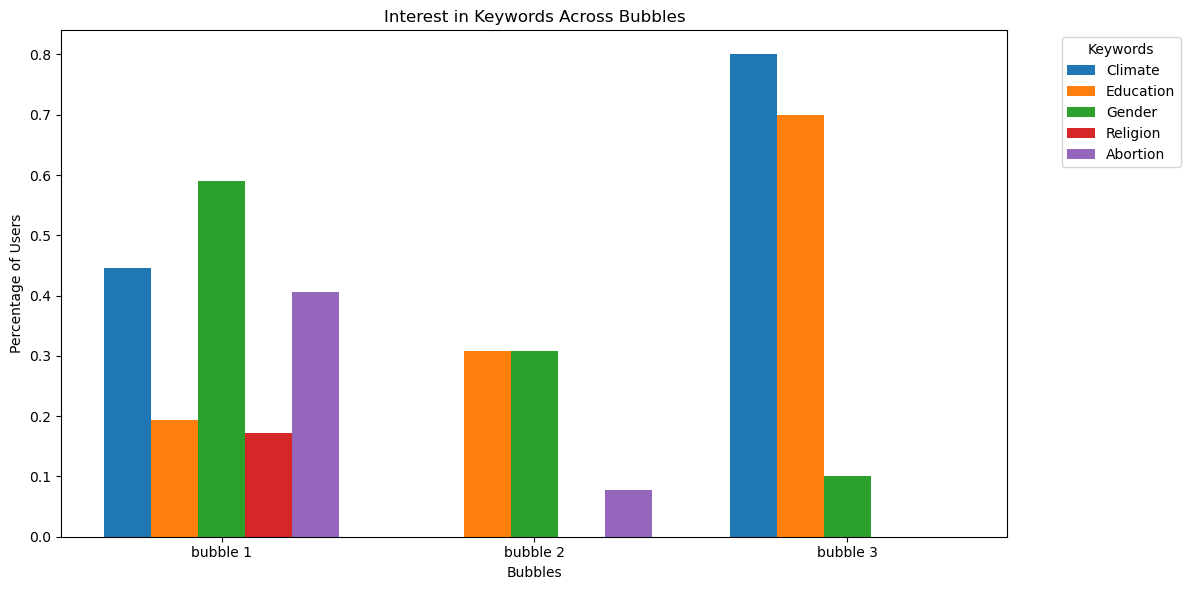

In [134]:
#ABC
keywords =['Climate', 'Education', 'Gender', 'Religion', 'Abortion']
dp.process_and_plot_word_interest(bubbles_abc, videos_new_pol, video_ids_news_pol_int_mapping, keywords)


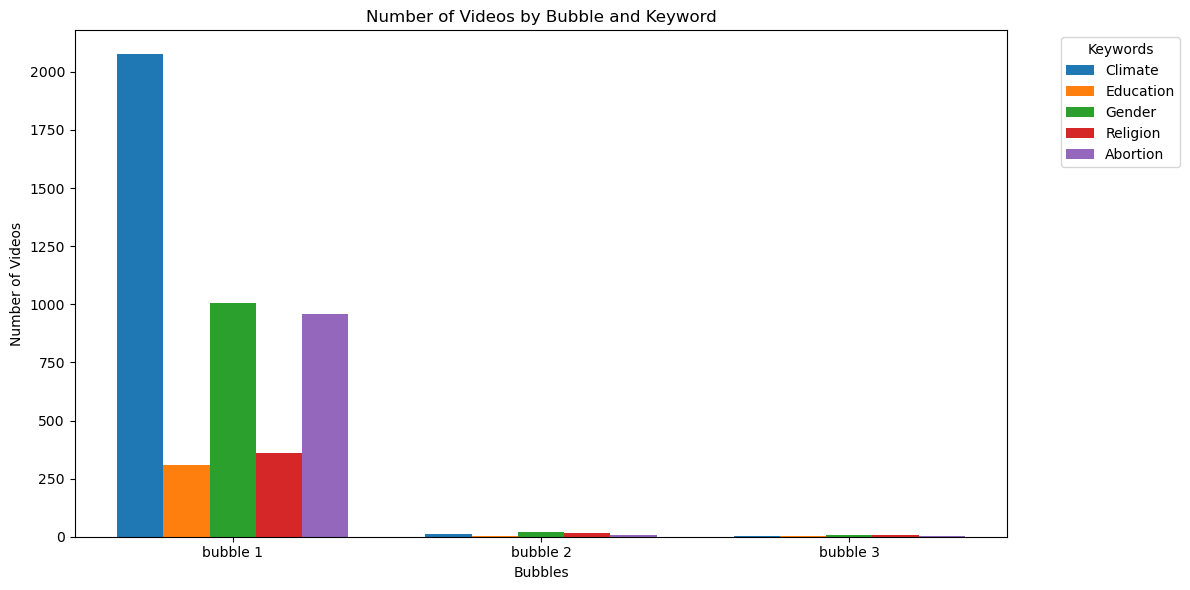

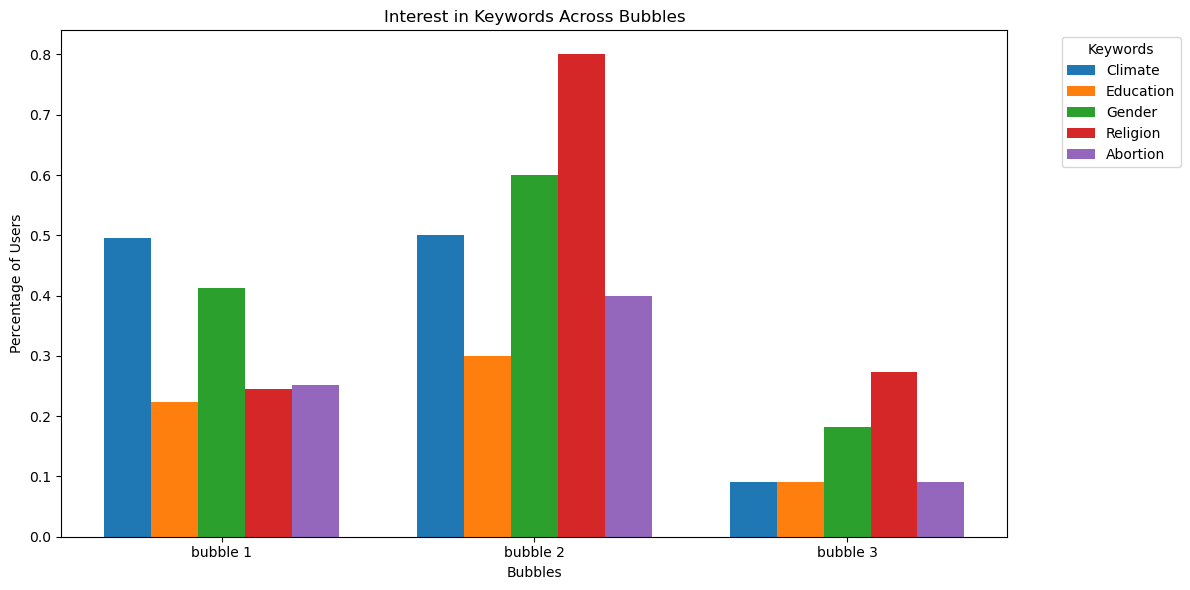

In [135]:
#BBC
keywords =['Climate', 'Education', 'Gender', 'Religion', 'Abortion']
dp.process_and_plot_word_interest(bubbles_bbc, videos_new_pol, video_ids_news_pol_int_mapping, keywords)


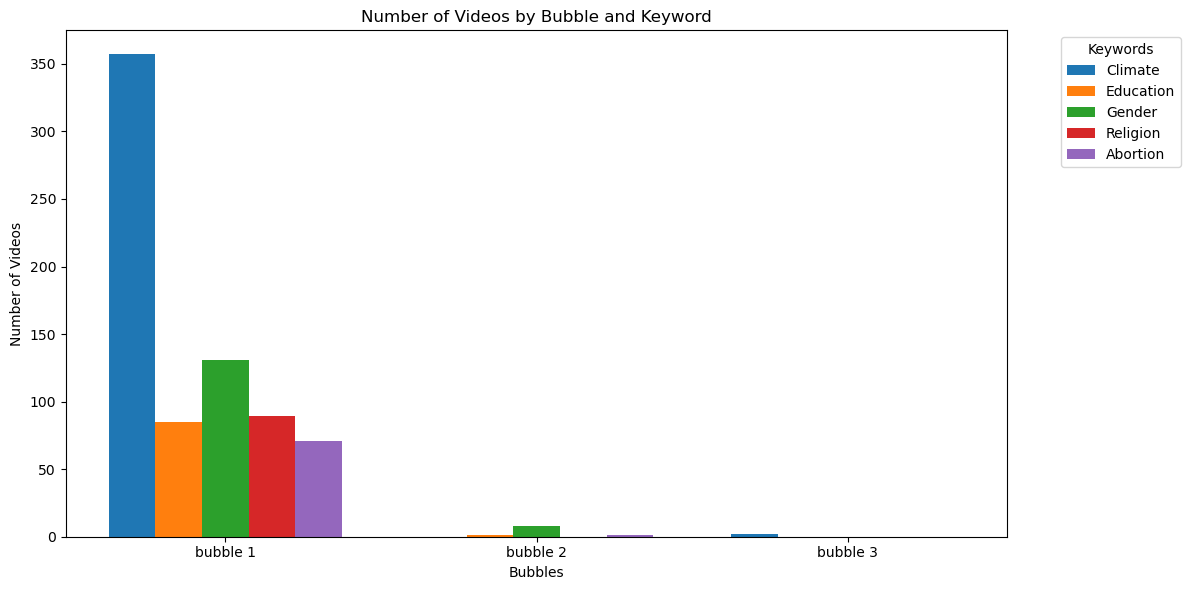

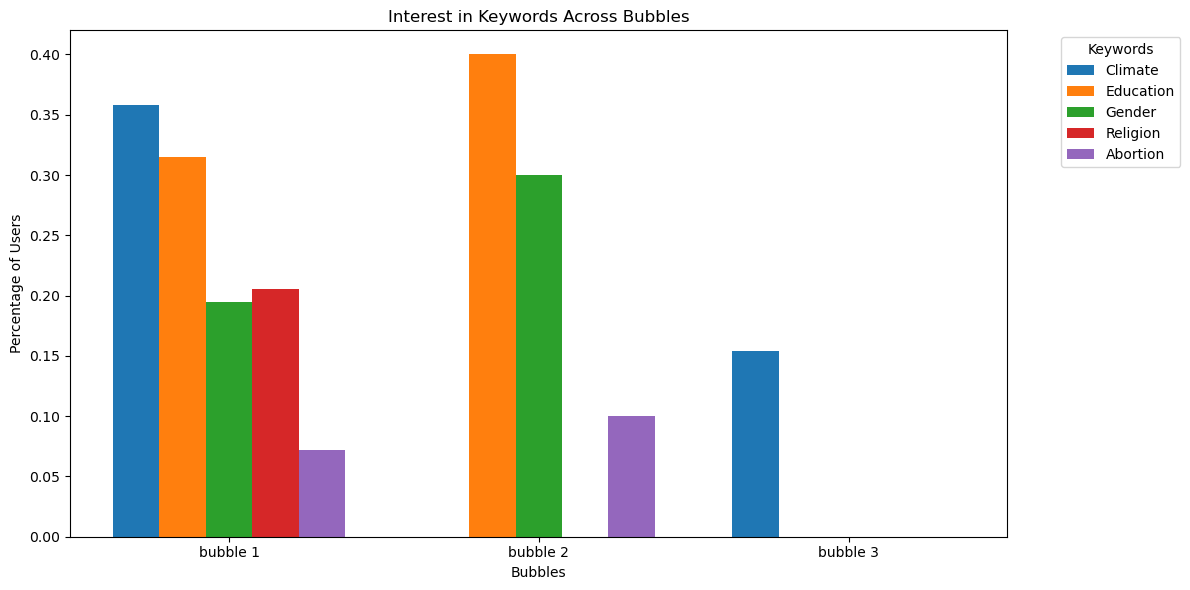

In [136]:
#AJE
keywords = ['Climate', 'Education', 'Gender', 'Religion', 'Abortion']
dp.process_and_plot_word_interest(bubbles_aje, videos_new_pol, video_ids_news_pol_int_mapping, keywords)


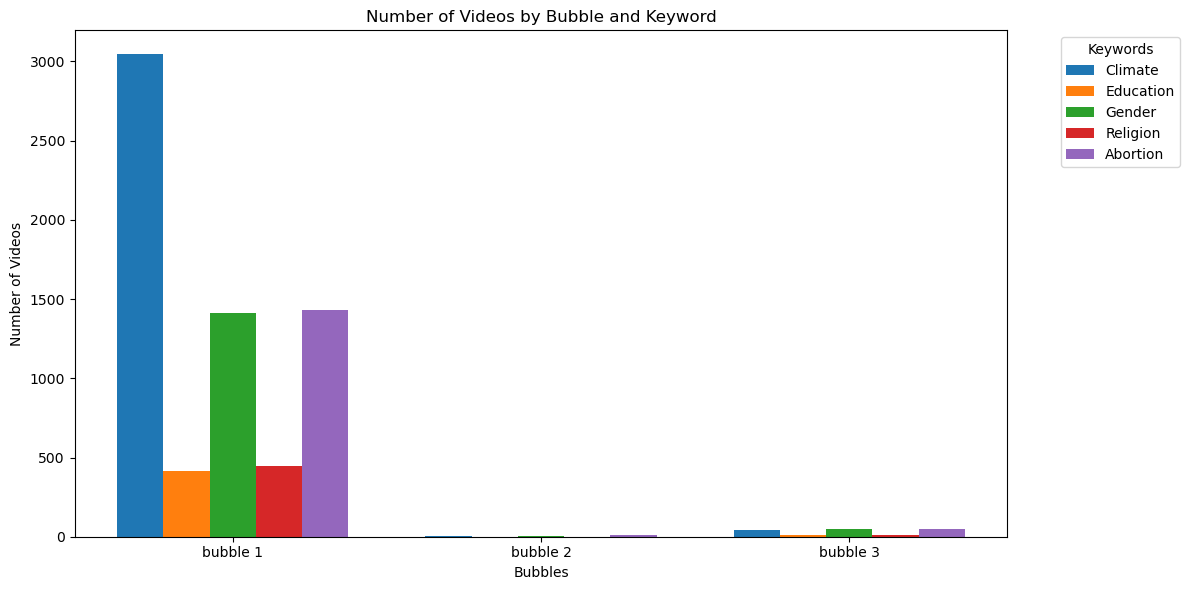

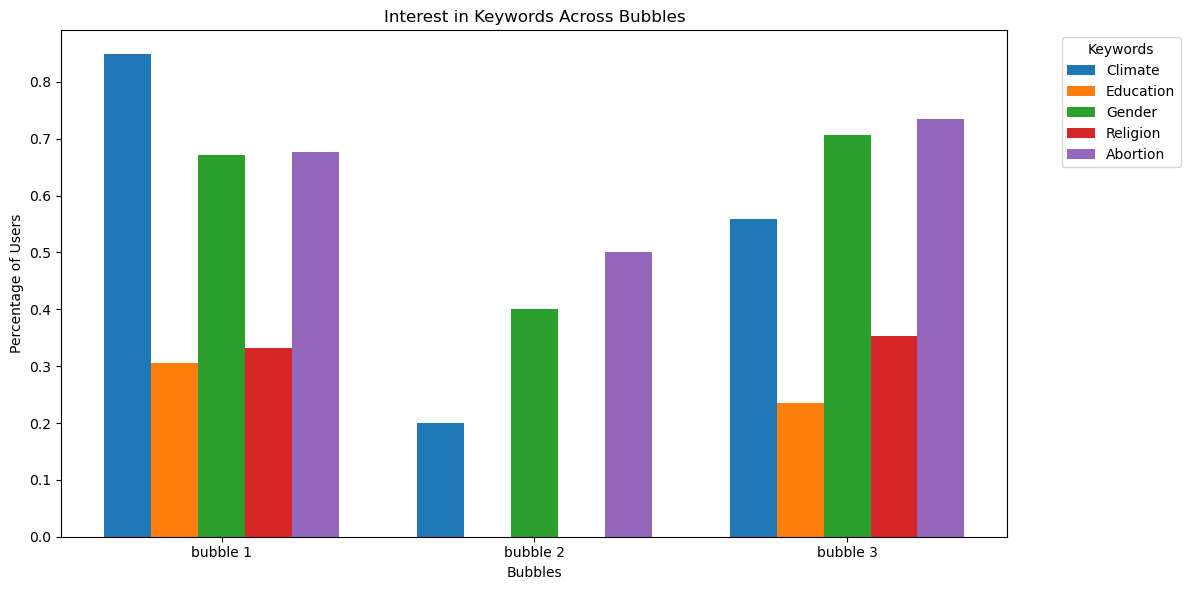

In [137]:
#Fox
keywords = ['Climate', 'Education', 'Gender', 'Religion', 'Abortion']
dp.process_and_plot_word_interest(bubbles_fox, videos_new_pol, video_ids_news_pol_int_mapping, keywords)


That’s interesting—while subject seem equally popular in CNN and BBC, the other three channels show distinct preferences within each bubble. In ABC, one bubble appears uninterested in religion and climate, while another seems to disregard religion and abortion. In AJE, the differences are even more pronounced! One bubble seems to focus solely on climate, though it remains a small category, suggesting another topic might capture their interest. In BBC, one bubble appears particularly interested in religion-related videos. This analysis highlights that even within the same channel, bubbles exhibit distinct preferences for certain topics. This suggests that bubbles within a channel are not homogeneous but rather reflect diverse interests among their members.